In [75]:
import numpy as np

dist_matrix = np.array([[0, 1, 2, 1], [1, 0, 4, 2], [2, 4, 0, 3], [1, 2, 3, 0]], dtype=float)
print("Original Shape:", np.shape(dist_matrix))

q1 = np.percentile(dist_matrix, 25)
q3 = np.percentile(dist_matrix, 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr

# 篩選離群值，將不符合條件的元素設為 inf
dist_without_outliers = dist_matrix
# dist_without_outliers[(dist_without_outliers <= 0) | (dist_without_outliers > upper_bound)] = np.nan
dist_without_outliers = np.where((dist_without_outliers <= 0) | (dist_without_outliers > upper_bound), np.inf, dist_without_outliers)
print("Filtered Shape:", np.shape(dist_without_outliers))
print("Filtered Dist Matrix:")
print(dist_without_outliers)


Original Shape: (4, 4)
Filtered Shape: (4, 4)
Filtered Dist Matrix:
[[inf  1.  2.  1.]
 [ 1. inf  4.  2.]
 [ 2.  4. inf  3.]
 [ 1.  2.  3. inf]]


In [78]:
np.median(dist_without_outliers,axis=1)

array([1.5, 3. , 3.5, 2.5])

In [25]:
import numpy as np
from torchvision import datasets, transforms
from collections import Counter
def labels_eval(label_dict):
    merge_dict = defaultdict(list)
    for d in label_dict:
        for key, value in d.items():
            merge_dict[key].append(value)
    outdict = {key: round(np.mean(values),4) for key, values in merge_dict.items()}
    return outdict

def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    labels = np.array(dataset.targets)
    users_label ,dict_users, all_idxs = {}, {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        label_count = Counter(labels[np.array(list(dict_users[i]))].tolist())
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / len(dict_users[i]) >= 0.1
        users_label[i] =  list(label_count_dict.keys())
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users , users_label

def mnist_noniid_one(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs --> assign each user 1 shard eg: 600 imgs/shard X 100 users(shards)
    num_imgs = int(len(dataset)/num_users)
    idx_shard = [i for i in range(num_users)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    # resample each labels dataset to 6000
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    # idxs = np.arange(len(dataset))

    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # divide and assign 1 shards to client
    for i in range(num_users):
        rnd_shard = np.random.choice(idx_shard, 1, replace=False)
        idx_shard = np.delete(idx_shard, np.where(idx_shard == rnd_shard))
        dict_users[i] = idxs[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs]
        label_ls = id_labels[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs].tolist()
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls)
        # 將 Counter 轉換為字典格式
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label

def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  assign each user 2 shard eg: 300 imgs/shard X 2 shards X 100 users
    num_imgs = int(len(dataset)/(2*num_users))
    idx_shard = [i for i in range(2*num_users)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    labels = np.array(dataset.targets)
    
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    
    # idxs = np.arange(len(dataset))
    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        label_ls = np.array([])
        for rand in rand_set:
            label_ls = np.concatenate([label_ls, id_labels[rand*num_imgs:(rand+1)*num_imgs]],axis=0)
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls.tolist())
        # 將 Counter 轉換為字典格式
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label


def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, int(len(dataset)/1200)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {}

    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    # resample each labels dataset to 6000
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    # idxs = np.arange(len(dataset))
    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    for i in range(num_users):
        index_ls = np.where(np.isin(idxs, dict_users[i]))[0]
        label_count = Counter(id_labels[index_ls].tolist())
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / len(dict_users[i]) >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label

num_users=100
frac = 1.0
# device = 'cpu'
device = 'cuda:0'
# load dataset and user groups
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data/fmnist/', train=True, download=True,
                                transform=apply_transform)

test_dataset = datasets.MNIST('../data/fmnist/', train=False, download=True,
                                transform=apply_transform)
user_groups_one , users_label_one = mnist_noniid_one(train_dataset, num_users)
user_groups_iid , users_label_iid = mnist_iid(train_dataset, num_users)
user_groups_non , users_label_non = mnist_noniid(train_dataset, num_users)
user_groups_ls = [user_groups_iid,user_groups_non, user_groups_one]
users_label_ls = [users_label_iid,users_label_non,users_label_one]
m = max(int(frac * num_users), 1) #8/1
idxs_users = list(range(num_users)) #8/1
clients_ndata=[]
selected_users = np.random.choice(idxs_users, m, replace=False)
for i,idx in enumerate(selected_users):
    clients_ndata.append(len(user_groups_iid[idx]))

In [31]:
set(np.array(train_dataset.targets))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

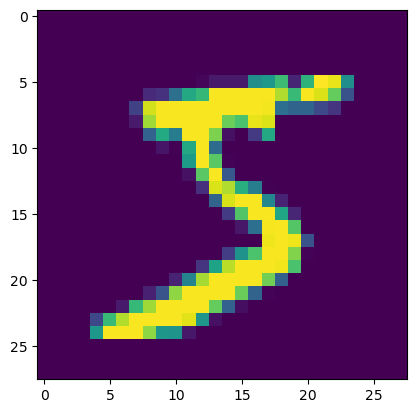

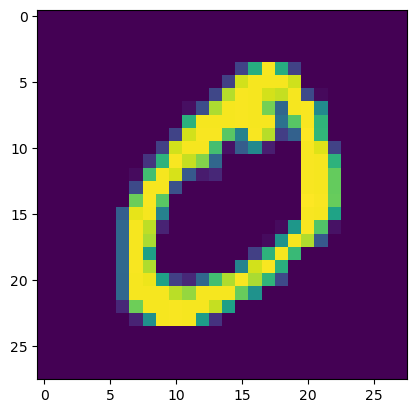

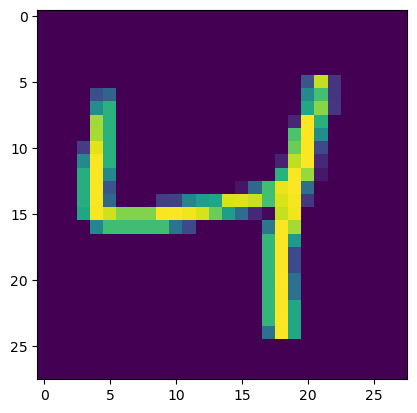

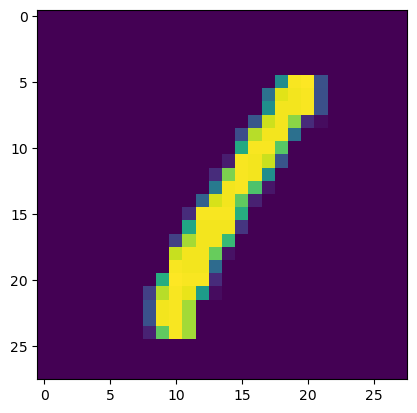

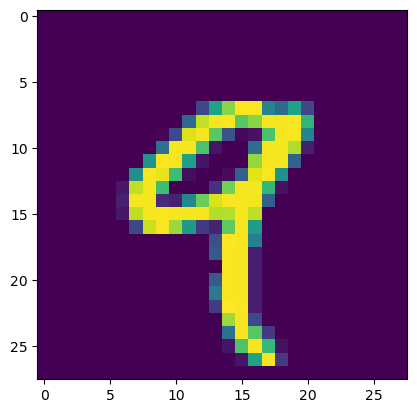

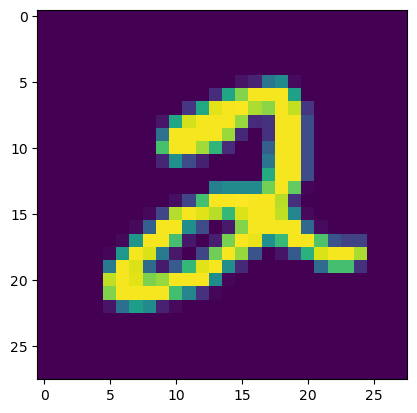

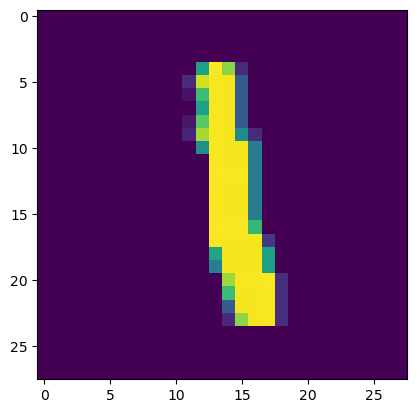

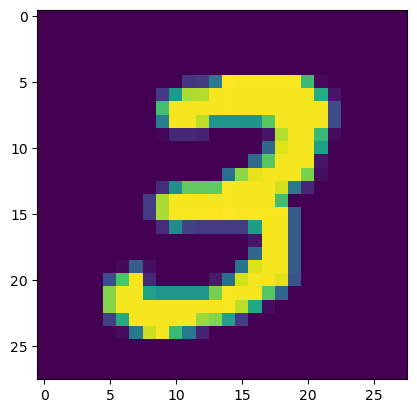

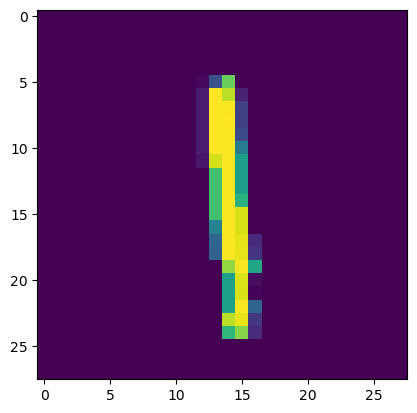

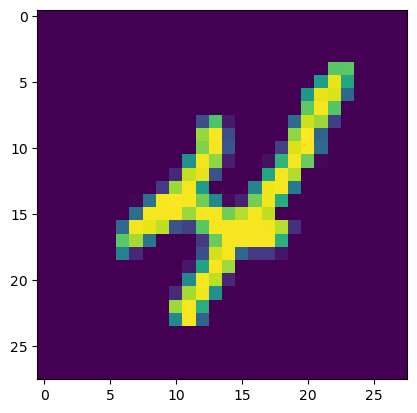

In [28]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # denormalize if you have normalized the images while loading
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
for i in range(10):
    sample_img = train_dataset[i][0]
    imshow(sample_img)
    print(classes[train_dataset.targets[i]])

In [3]:
import numpy as np
from torchvision import datasets, transforms
from collections import Counter
def labels_eval(label_dict):
    merge_dict = defaultdict(list)
    for d in label_dict:
        for key, value in d.items():
            merge_dict[key].append(value)
    outdict = {key: round(np.mean(values),4) for key, values in merge_dict.items()}
    return outdict

def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    labels = np.array(dataset.targets)
    users_label ,dict_users, all_idxs = {}, {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        label_count = Counter(labels[np.array(list(dict_users[i]))].tolist())
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / len(dict_users[i]) >= 0.1
        users_label[i] =  list(label_count_dict.keys())
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users , users_label

def mnist_noniid_one(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs --> assign each user 1 shard eg: 600 imgs/shard X 100 users(shards)
    num_imgs = int(len(dataset)/num_users)
    idx_shard = [i for i in range(num_users)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    # resample each labels dataset to 6000
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    # idxs = np.arange(len(dataset))

    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # divide and assign 1 shards to client
    for i in range(num_users):
        rnd_shard = np.random.choice(idx_shard, 1, replace=False)
        idx_shard = np.delete(idx_shard, np.where(idx_shard == rnd_shard))
        dict_users[i] = idxs[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs]
        label_ls = id_labels[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs].tolist()
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls)
        # 將 Counter 轉換為字典格式
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label

def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  assign each user 2 shard eg: 300 imgs/shard X 2 shards X 100 users
    num_imgs = int(len(dataset)/(2*num_users))
    idx_shard = [i for i in range(2*num_users)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    labels = np.array(dataset.targets)
    
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    
    # idxs = np.arange(len(dataset))
    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        label_ls = np.array([])
        for rand in rand_set:
            label_ls = np.concatenate([label_ls, id_labels[rand*num_imgs:(rand+1)*num_imgs]],axis=0)
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls.tolist())
        # 將 Counter 轉換為字典格式
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label


def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, int(len(dataset)/1200)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {}

    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    # resample each labels dataset to 6000
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    # idxs = np.arange(len(dataset))
    # # sort labels
    # idxs_labels = np.vstack((idxs, labels))
    # idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    # idxs = idxs_labels[0, :]
    # id_labels = idxs_labels[1, :]
    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    for i in range(num_users):
        index_ls = np.where(np.isin(idxs, dict_users[i]))[0]
        label_count = Counter(id_labels[index_ls].tolist())
        label_count_dict = {int(label): count for label, count in label_count.items()} # if count / len(dict_users[i]) >= 0.1
        users_label[i] =  list(label_count_dict.keys())
    return dict_users , users_label

num_users=100
frac = 1.0
# device = 'cpu'
device = 'cuda:0'
# load dataset and user groups
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data/mnist/', train=True, download=True,
                                transform=apply_transform)

test_dataset = datasets.MNIST('../data/mnist/', train=False, download=True,
                                transform=apply_transform)
user_groups_one , users_label_one = mnist_noniid_one(train_dataset, num_users)
user_groups_iid , users_label_iid = mnist_iid(train_dataset, num_users)
user_groups_non , users_label_non = mnist_noniid(train_dataset, num_users)
user_groups_ls = [user_groups_iid,user_groups_non, user_groups_one]
users_label_ls = [users_label_iid,users_label_non,users_label_one]
m = max(int(frac * num_users), 1) #8/1
idxs_users = list(range(num_users)) #8/1
clients_ndata=[]
selected_users = np.random.choice(idxs_users, m, replace=False)
for i,idx in enumerate(selected_users):
    clients_ndata.append(len(user_groups_iid[idx]))

In [56]:
import numpy as np
from torchvision import datasets, transforms
from sampling import mnist_iid, mnist_noniid, mnist_noniid_one
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
num_users = 100
train_dataset = datasets.MNIST('../data/mnist/', train=True, download=True,
                                transform=apply_transform)

user_groups , users_label = mnist_noniid_one(train_dataset, num_users)

In [101]:
apply_transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10('../data/cifar/', train=True, download=True,
                                       transform=apply_transform)

Files already downloaded and verified


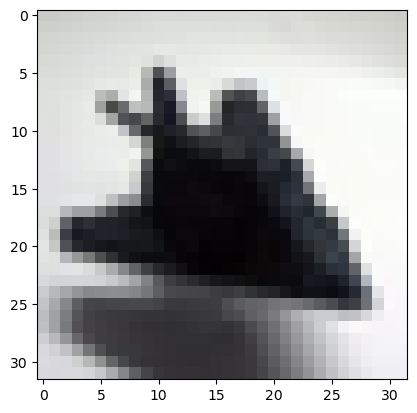

plane


In [116]:
sample_img = train_dataset[29][0]
imshow(sample_img)
print(classes[train_dataset.targets[29]])

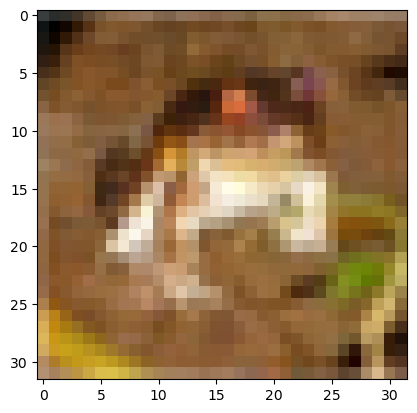

frog


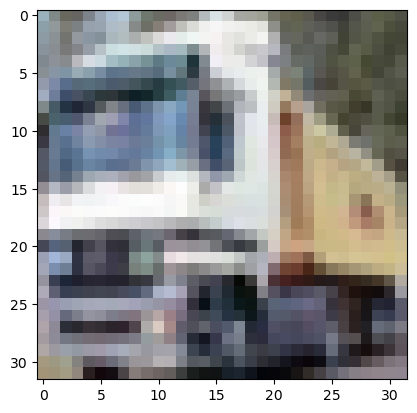

truck


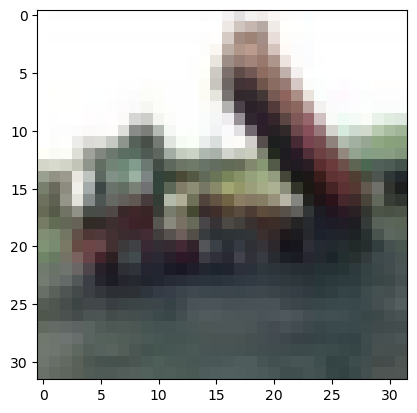

truck


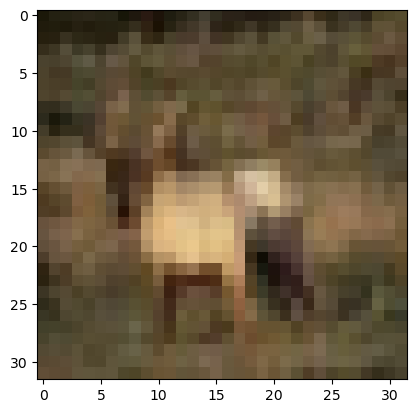

deer


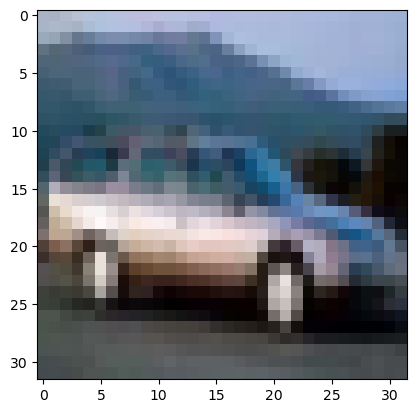

car


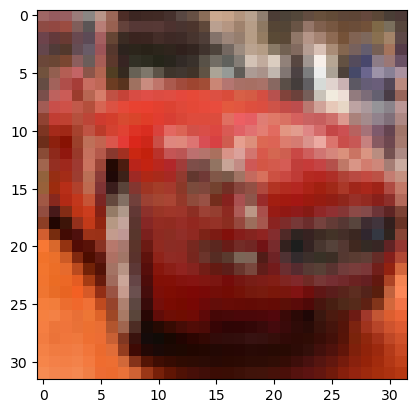

car


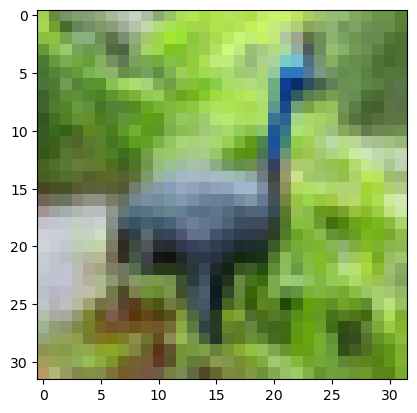

bird


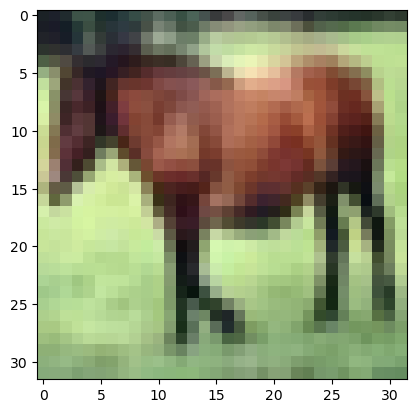

horse


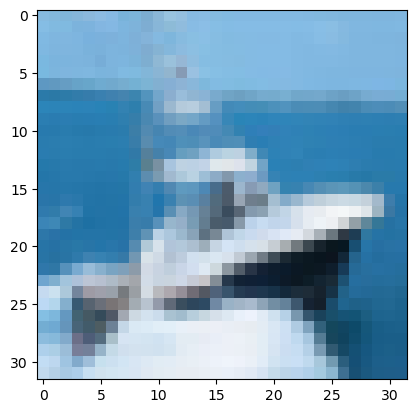

ship


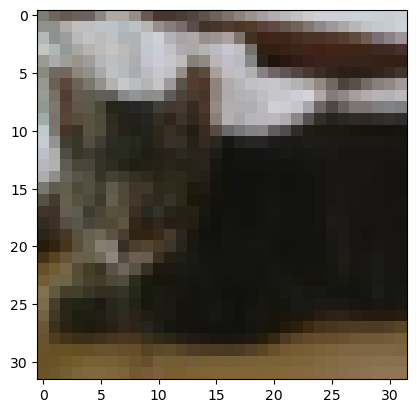

cat


In [115]:
import matplotlib.pyplot as plt
import numpy as np
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Function to denormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # denormalize if you have normalized the images while loading
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Display the image
for i in range(10):
    sample_img = train_dataset[i][0]
    imshow(sample_img)
    print(classes[train_dataset.targets[i]])

In [1]:
import numpy as np
dist_matrix = np.random.rand(30,30)

# 將矩陣填充為對稱矩陣
dist_matrix = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(dist_matrix, 0)


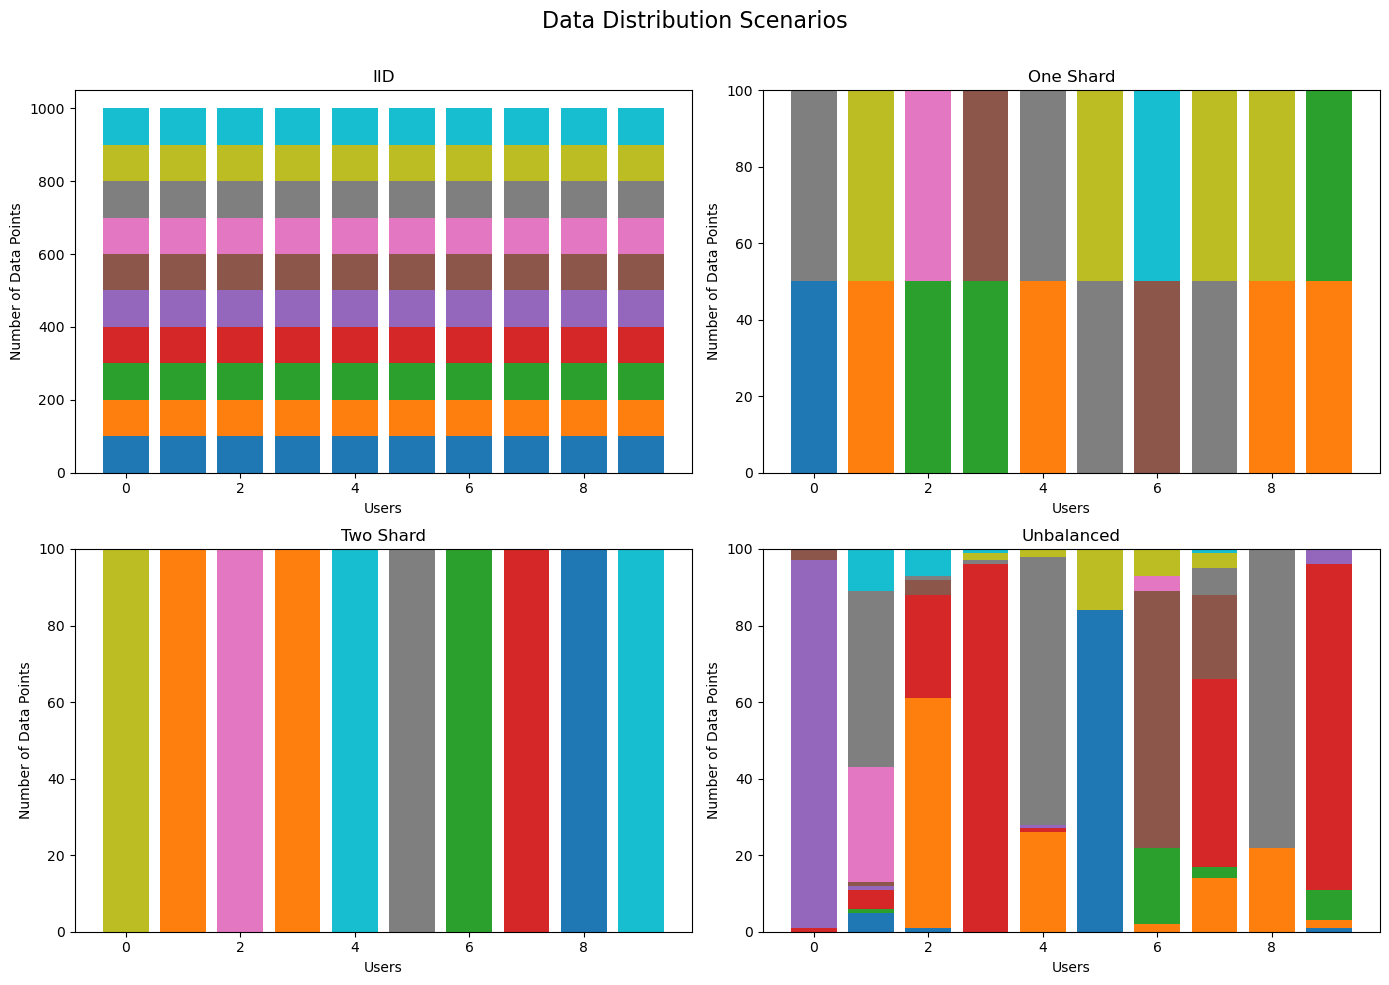

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data simulation for 10 users
num_users = 10
num_labels = 10
data_per_label = 100  # for visualization simplicity

# iid scenario
iid_data = np.full((num_users, num_labels), data_per_label)

# one shard scenario
one_shard_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    chosen_labels = np.random.choice(num_labels, 2, replace=False)
    for label in chosen_labels:
        one_shard_data[user, label] = data_per_label / 2

# two shard scenario
two_shard_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    chosen_label = np.random.choice(num_labels)
    two_shard_data[user, chosen_label] = data_per_label

# unbalanced scenario
unbalanced_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    remaining_data = data_per_label
    while remaining_data > 0:
        chosen_label = np.random.choice(num_labels)
        allocation = np.random.randint(1, remaining_data+1)
        unbalanced_data[user, chosen_label] += allocation
        remaining_data -= allocation

# Using a distinct color palette
colors = plt.cm.tab10(np.linspace(0, 1, num_labels))

# Modified plotting function
def plot_stacked_bar(ax, data, title):
    labels = np.arange(num_users)
    bottom_data = np.zeros(num_users)
    for i in range(num_labels):
        ax.bar(labels, data[:, i], color=colors[i], label=f'Label {i}', bottom=bottom_data)
        bottom_data += data[:, i]
    ax.set_title(title)
    ax.set_xlabel("Users")
    ax.set_ylabel("Number of Data Points")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Distribution Scenarios', fontsize=16)

plot_stacked_bar(axs[0, 0], iid_data, 'IID')
plot_stacked_bar(axs[0, 1], one_shard_data, 'One Shard')
plot_stacked_bar(axs[1, 0], two_shard_data, 'Two Shard')
plot_stacked_bar(axs[1, 1], unbalanced_data, 'Unbalanced')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


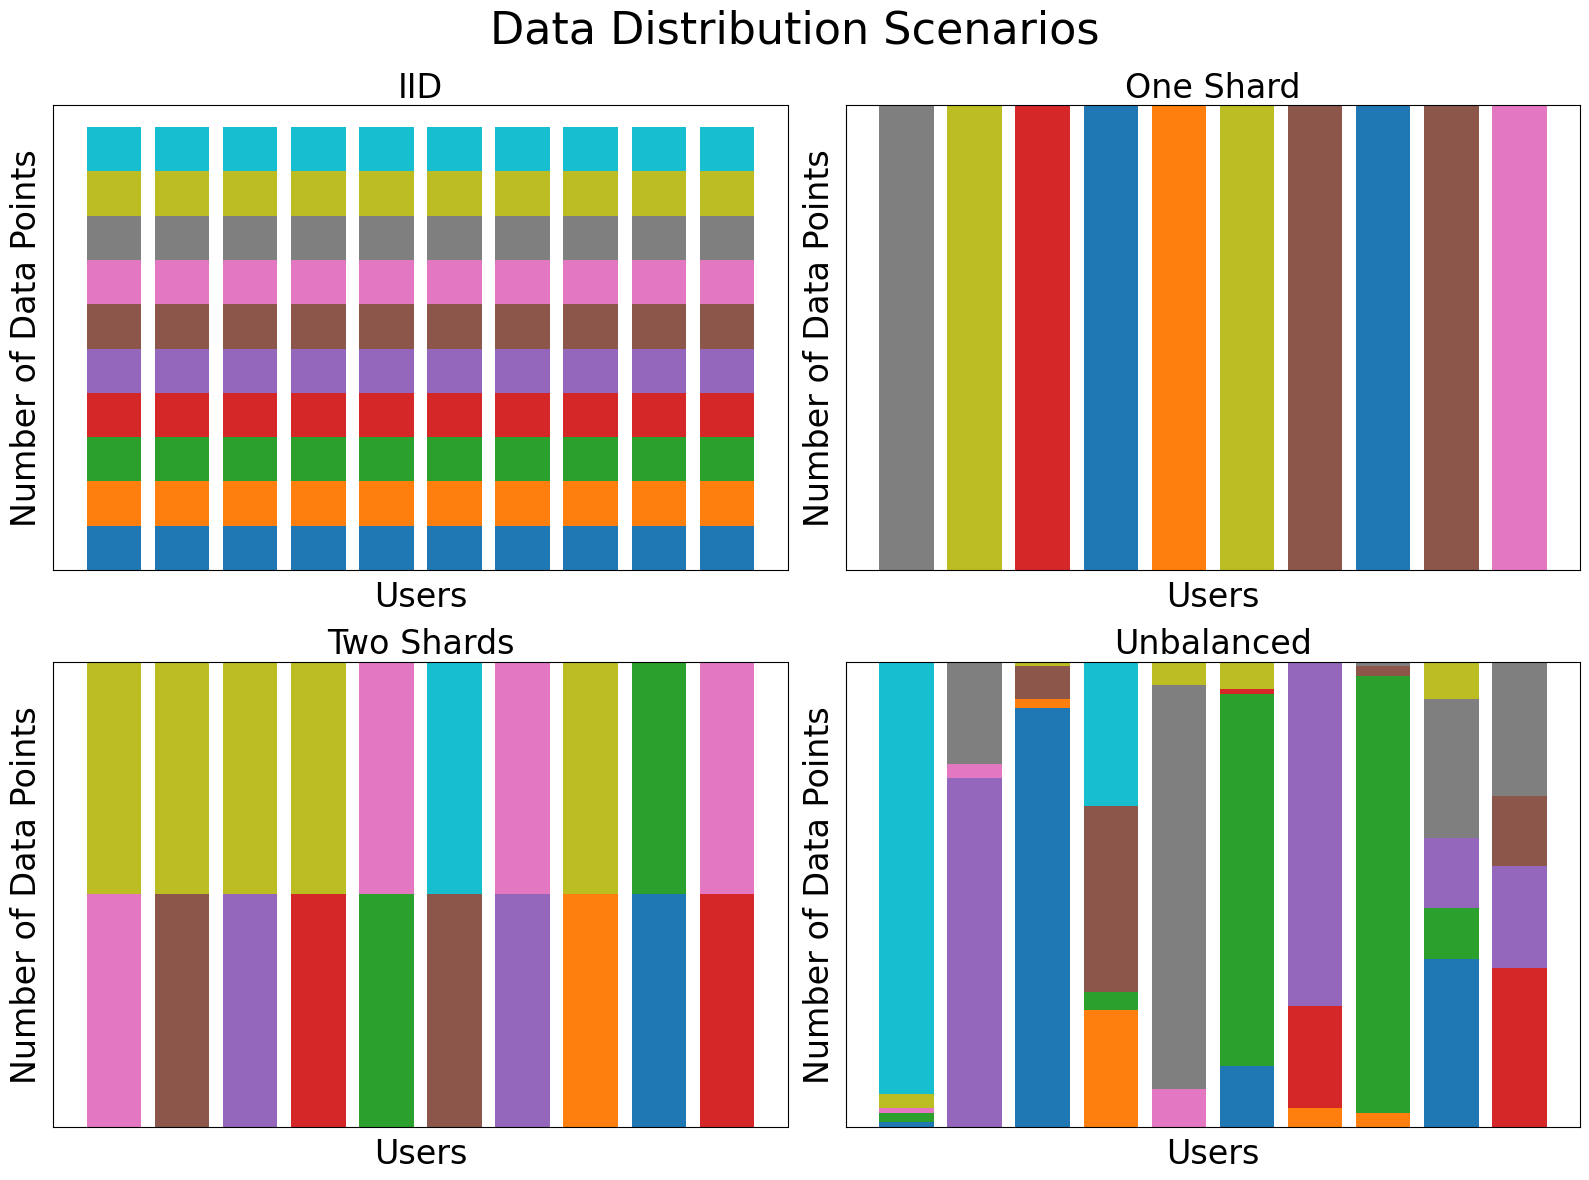

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data simulation for 10 users
num_users = 10
num_labels = 10
data_per_label = 100  # for visualization simplicity

# iid scenario
iid_data = np.full((num_users, num_labels), data_per_label)

# one shard scenario
one_shard_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    chosen_labels = np.random.choice(num_labels, 2, replace=False)
    for label in chosen_labels:
        one_shard_data[user, label] = data_per_label / 2

# two shard scenario
two_shard_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    chosen_label = np.random.choice(num_labels)
    two_shard_data[user, chosen_label] = data_per_label

# unbalanced scenario
unbalanced_data = np.zeros((num_users, num_labels))
for user in range(num_users):
    remaining_data = data_per_label
    while remaining_data > 0:
        chosen_label = np.random.choice(num_labels)
        allocation = np.random.randint(1, remaining_data+1)
        unbalanced_data[user, chosen_label] += allocation
        remaining_data -= allocation

# Using a distinct color palette
colors = plt.cm.tab10(np.linspace(0, 1, num_labels))

# Modified plotting function
def plot_stacked_bar(ax, data, title):
    labels = np.arange(num_users)
    bottom_data = np.zeros(num_users)
    for i in range(num_labels):
        ax.bar(labels, data[:, i], color=colors[i], label=f'Label {i}', bottom=bottom_data)
        bottom_data += data[:, i]
    ax.set_title(title, fontsize=24)
    ax.set_xlabel("Users", fontsize=24)
    ax.set_ylabel("Number of Data Points", fontsize=24)
    
    # Hide X and Y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Distribution Scenarios', fontsize=32)

plot_stacked_bar(axs[0, 0], iid_data, 'IID')
plot_stacked_bar(axs[1, 0], one_shard_data, 'Two Shards')
plot_stacked_bar(axs[0, 1], two_shard_data, 'One Shard')
plot_stacked_bar(axs[1, 1], unbalanced_data, 'Unbalanced')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [2]:
import numpy as np

clients = np.array([2, 0, 1, 5, 4, 3])
labels = np.array([0, 2, 1, 0, 2, 1])

# 使用clients作為索引來提取對應的labels值
label_with_client = labels[clients]

print("label_with_client:", label_with_client.tolist())


label_with_client: [1, 0, 2, 1, 2, 0]


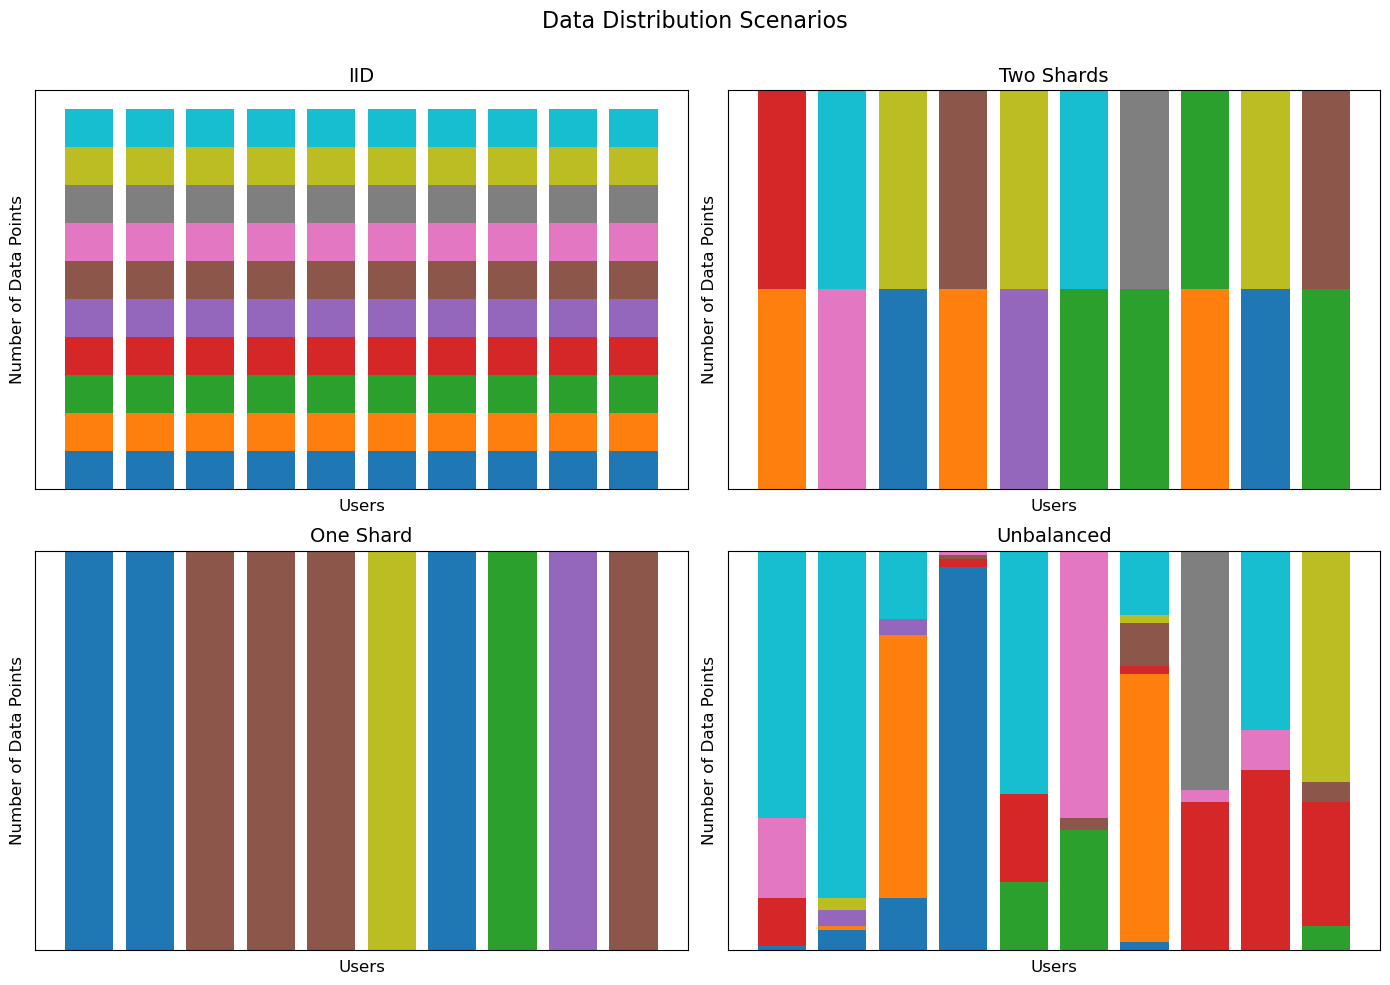

In [2]:
def plot_stacked_bar(ax, data, title):
    labels = np.arange(num_users)
    bottom_data = np.zeros(num_users)
    for i in range(num_labels):
        ax.bar(labels, data[:, i], color=colors[i], label=f'Label {i}', bottom=bottom_data)
        bottom_data += data[:, i]
    ax.set_title(title, fontsize=14)  # Increase font size for subplot title
    ax.set_xlabel("Users", fontsize=12)  # Increase font size for x-axis label
    ax.set_ylabel("Number of Data Points", fontsize=12)  # Increase font size for y-axis label
    
    # Hide X and Y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Distribution Scenarios', fontsize=16)

plot_stacked_bar(axs[0, 0], iid_data, 'IID')
plot_stacked_bar(axs[0, 1], one_shard_data, 'Two Shards')
plot_stacked_bar(axs[1, 0], two_shard_data, 'One Shard')
plot_stacked_bar(axs[1, 1], unbalanced_data, 'Unbalanced')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [52]:
def dfs(node, visited, adj_matrix):
    cluster = []
    stack = [node]
    while stack:
        current = stack.pop()
        if current not in visited:
            visited.add(current)
            cluster.append(current)
            neighbors = np.where(adj_matrix[current] == 1)[0]
            stack.extend(neighbors)
    return cluster
num_vectors = 30
dc = max(np.min(np.where(dist_matrix != 0, dist_matrix, np.inf), axis=1))
print(f"dc: {round(dc,4)}")
# 考慮節點的密度和中心性(該點與其他點的平均距離)
densities = np.sum(dist_matrix <= dc, axis=1)
mask = (dist_matrix <= dc) & (dist_matrix > 0)
centralities = np.sum(dist_matrix * mask, axis=1) / np.sum(mask, axis=1)
neighbors_id = [np.where(row)[0] for row in mask]

# 使用密度和局部中心性來更新鄰接矩陣
adj_matrix = np.zeros_like(dist_matrix)
for i in range(num_vectors):
    if densities[i] >= np.median(densities) and centralities[i] <= np.median(centralities):
        adj_matrix[i, neighbors_id[i]] = 1 # closest_indices


# DFS algo
visited = set()
clusters = []
for i in range(num_vectors):
    if i not in visited:
        cluster = dfs(i, visited, adj_matrix)
        clusters.append(cluster)
# print(f'clusters: {clusters}')

dc: 0.2215


In [54]:

print(clusters)

print(clusters)

[[0], [1], [2], [3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4], [5], [13], [18], [21], [26], [28], [29]]
[[26], [21], [1], [3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4], [5], [29], [13], [0], [28], [2], [18]]


In [51]:
def min_distance_between_clusters(cluster1, cluster2, dist_matrix):
    distances = dist_matrix[np.ix_(cluster1, cluster2)]
    return distances.min()
print(f'dc: {round(dc,4)}')
dist_matrix[28][29] = 0.22
dist_matrix[29][28] = 0.22
print(clusters)
# 合併距離較近的小群
merged_clusters = []
merged = set()
for i, cluster1 in enumerate(clusters):
    if i in merged:
        continue
    close_clusters = [i]
    for j, cluster2 in enumerate(clusters):
        if j != i and j not in merged:
            distance = min_distance_between_clusters(cluster1, cluster2, dist_matrix)
            if distance < dc:  # 使用先前計算的dc作為閾值
                close_clusters.append(j)
                merged.add(j)
    merged_cluster = []
    for idx in close_clusters:
        merged_cluster.extend(clusters[idx])
    merged_clusters.append(merged_cluster)
clusters = merged_clusters
# 後處理：合併小群和移除雜訊
min_cluster_size = 3  # 可以根據需要調整
valid_clusters = []
noise = []
for cluster in clusters:
    if len(cluster) >= min_cluster_size:
        valid_clusters.append(cluster)
    else:
        noise.extend(cluster)
print(f'valid clusters: {valid_clusters}')
print(np.array(valid_clusters).shape)
print(f'noise: {noise}')
print(len(noise))

dc: 0.2215
[[0], [1], [2], [3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4], [5], [13], [18], [21], [26], [28], [29]]
valid clusters: [[0, 1, 3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4]]
(1, 22)
noise: [2, 5, 21, 13, 18, 26, 28, 29]
8


dc: 0.2215
[[0], [1], [2], [3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4], [5], [13], [18], [21], [26], [28], [29]]
valid clusters: [[0, 1, 3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4]]
(1, 22)
noise: [2, 5, 21, 13, 18, 26, 28, 29]
8

[[0], [1], [2], [3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4], [5], [13], [18], [21], [26], [28], [29]]
valid clusters: [[0, 3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4]]
(1, 21)
noise: [1, 18, 2, 5, 21, 13, 26, 28, 29]
9

In [22]:
cluster_centers = [cluster[np.argmin(np.mean(dist_matrix[cluster][:, cluster], axis=1))] for cluster in valid_clusters] # clusters
# cluster_centers = [np.mean(dist_matrix[cluster], axis=0) for cluster in valid_clusters] # clusters
# 合併距離較近的小群
merged_clusters = []
merged = set()
for i, center1 in enumerate(cluster_centers):
    if i in merged:
        continue
    close_clusters = [i]
    for j, center2 in enumerate(cluster_centers):
        if j != i and j not in merged:
            distance = np.linalg.norm(center1 - center2) # distance = dist_matrix[center1][center2] 
            # print(f'clust_dist: {round(distance,4)}')
            if distance < dc:  # 使用先前計算的dc作為閾值
                close_clusters.append(j)
                merged.add(j)
    merged_cluster = []
    for idx in close_clusters:
        merged_cluster.extend(valid_clusters[idx]) # clusters
    merged_clusters.append(merged_cluster)
valid_clusters = merged_clusters
print(f'valid clusters: {valid_clusters}')
print(np.array(valid_clusters).shape)
print(f'noise: {noise}')
print(len(noise))


valid clusters: [[3, 19, 25, 24, 27, 16, 14, 10, 22, 15, 12, 11, 9, 20, 17, 8, 7, 23, 6, 4]]
(1, 20)
noise: [0, 1, 2, 5, 13, 18, 21, 26, 28, 29]
10


In [15]:
dc = max(np.min(np.where(dist_matrix != 0, dist_matrix, np.inf), axis=1))
mask = (dist_matrix <= dc) & (dist_matrix > 0)
centralities = np.sum(dist_matrix * mask, axis=1) / np.sum(mask, axis=1)
neighbors_id = [np.where(row)[0] for row in mask]
print(neighbors_id)

[array([12, 17, 19]), array([17, 26]), array([13]), array([16, 17, 23]), array([10, 22]), array([ 6,  9, 15, 16, 21, 26, 28, 29]), array([ 5, 10, 14, 25, 27]), array([19]), array([18, 22, 23]), array([ 5, 15, 19, 22]), array([ 4,  6, 15, 22, 24, 25]), array([15, 20, 21, 23, 27]), array([ 0, 13, 14, 18, 24, 25, 29]), array([ 2, 12, 27, 29]), array([ 6, 12, 25, 27, 28]), array([ 5,  9, 10, 11, 18, 19]), array([ 3,  5, 17, 20, 25, 26]), array([ 0,  1,  3, 16, 21, 23, 27]), array([ 8, 12, 15, 22]), array([ 0,  7,  9, 15, 26]), array([11, 16]), array([ 5, 11, 17]), array([ 4,  8,  9, 10, 18, 24, 26, 27, 29]), array([ 3,  8, 11, 17, 29]), array([10, 12, 22, 26]), array([ 6, 10, 12, 14, 16, 26]), array([ 1,  5, 16, 19, 22, 24, 25, 27, 28, 29]), array([ 6, 11, 13, 14, 17, 22, 26, 28]), array([ 5, 14, 26, 27]), array([ 5, 12, 13, 22, 23, 26])]


In [18]:
centralities = np.array([0.3, 0.2, 0.5, 0.1, 0.25])
neighbors_id = [np.array([1, 4]), np.array([0, 3]), np.array([4]), np.array([1]), np.array([0, 2])]

min_centralities = [all_points[np.argmin(centralities[all_points])] for all_points in [np.append(neighbors, i) for i, neighbors in enumerate(neighbors_id)]]

print(min_centralities)  # 輸出: [1, 3, 4, 3, 1]


[1, 3, 4, 3, 4]


In [17]:
centralities = [0.3, 0.2, 0.5, 0.1, 0.25]
neighbors_id = [np.array([1, 4]), np.array([0, 3]), np.array([4]), np.array([1]), np.array([0, 2])]

min_centralities = []

for i, neighbors in enumerate(neighbors_id):
    # 將當前點自己加入鄰居列表
    all_points = np.append(neighbors, i)
    
    # 找到這些點的centralities的最小值的索引
    min_index = all_points[np.argmin([centralities[j] for j in all_points])]
    
    min_centralities.append(min_index)

print(min_centralities)  # 輸出: [1, 3, 4, 3, 1]


[1, 3, 4, 3, 4]


In [16]:
print(centralities)

[0.08790663 0.0903045  0.17104385 0.25093573 0.26786147 0.16200244
 0.17439452 0.27822099 0.1393373  0.17915767 0.1348609  0.16968578
 0.14890131 0.15703041 0.15042863 0.20410972 0.13507258 0.18466742
 0.1675549  0.18241145 0.17079281 0.16613203 0.14378638 0.19829722
 0.11399984 0.13516102 0.13742245 0.17479908 0.13269113 0.19154062]


In [13]:
a = np.mean(dist_matrix[[0,1]], axis=0)
b = np.mean(dist_matrix[[0,2]], axis=0)
c = np.mean(dist_matrix[[2,3,4]], axis=0)
print(np.linalg.norm(a-b))
print(np.linalg.norm(a-c))
print(np.linalg.norm(b-c))

0.9444366470859256
1.4210239687009287
0.7503801489733877


In [10]:
dist_matrix[[2,3,4]]

array([[0.71037412, 0.67172354, 0.        , 0.47698684, 0.28907575,
        0.65703544, 0.86945669, 0.58826193, 0.46001705, 0.60460564,
        0.30394251, 0.39230931, 0.28058441, 0.17104385, 0.69554472,
        0.57934952, 0.4580025 , 0.53907584, 0.36904063, 0.76045199,
        0.89104539, 0.52987371, 0.42139303, 0.51596377, 0.46253814,
        0.90951636, 0.75811133, 0.48374229, 0.43884684, 0.57472762],
       [0.5478697 , 0.52458456, 0.47698684, 0.        , 0.41995568,
        0.56248393, 0.91748413, 0.60685652, 0.5433636 , 0.91085816,
        0.56589454, 0.81550315, 0.69819244, 0.43112963, 0.47256693,
        0.71135469, 0.222454  , 0.27772704, 0.36707477, 0.53913317,
        0.64691507, 0.49698822, 0.51533144, 0.25262614, 0.63129186,
        0.343272  , 0.76539167, 0.53567923, 0.27979979, 0.74768449],
       [0.47168554, 0.85121092, 0.28907575, 0.41995568, 0.        ,
        0.55905355, 0.65295434, 0.66541568, 0.67449835, 0.35806001,
        0.27197651, 0.89617092, 0.29805159, 0.

In [8]:
dist_matrix[[0,1]]

array([[0.        , 0.35668914, 0.71037412, 0.5478697 , 0.47168554,
        0.5569402 , 0.48948049, 0.49959583, 0.60985031, 0.56521519,
        0.66329749, 0.64558813, 0.08306816, 0.51631963, 0.76032736,
        0.37638087, 0.37728578, 0.15701478, 0.77141008, 0.02363695,
        0.65670291, 0.32692315, 0.36927131, 0.88798577, 0.36050125,
        0.44452506, 0.37662479, 0.37900692, 0.63062451, 0.48604777],
       [0.35668914, 0.        , 0.67172354, 0.52458456, 0.85121092,
        0.59714733, 0.66057952, 0.47153763, 0.65315828, 0.40704572,
        0.4268152 , 0.3016278 , 0.41617944, 0.8905988 , 0.81470649,
        0.30124489, 0.91788832, 0.0784359 , 0.52941272, 0.69329045,
        0.31301717, 0.54937304, 0.48054286, 0.65093245, 0.34999757,
        0.55953826, 0.10217309, 0.46508068, 0.67943763, 0.58555491]])

In [5]:
dc = np.mean(dist_matrix)
print(dc)

0.47533863475598953


In [6]:
densities = np.sum(dist_matrix <= dc, axis=1)
# centralities = np.mean(dist_matrix, axis=1)
# centralities = np.zeros(num_vectors)
# for i in range(num_vectors):
#     # 找到距離小於或等於dc的鄰居，但排除自己
#     neighbors_id = np.where((dist_matrix[i] <= dc) & (dist_matrix[i] > 0))[0]
#     centralities[i] = np.mean(dist_matrix[i, neighbors_id])
mask = (dist_matrix <= dc) & (dist_matrix > 0)
centralities = np.sum(dist_matrix * mask, axis=1) / np.sum(mask, axis=1)
neighbors_id = [np.where(row)[0] for row in mask]

In [7]:
neighbors_id

[array([ 1,  4, 12, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27]),
 array([ 0,  7,  9, 10, 11, 12, 15, 17, 20, 24, 26, 27]),
 array([ 4,  8, 10, 11, 12, 13, 16, 18, 22, 24, 28]),
 array([ 4, 13, 14, 16, 17, 18, 23, 25, 28]),
 array([ 0,  2,  3,  9, 10, 12, 16, 17, 19, 21, 22, 23, 24]),
 array([ 6,  9, 15, 16, 17, 21, 22, 23, 26, 27, 28, 29]),
 array([ 5,  8, 10, 14, 16, 22, 24, 25, 26, 27, 28, 29]),
 array([ 1,  8, 10, 13, 15, 19, 20, 21, 22]),
 array([ 2,  6,  7, 16, 17, 18, 19, 21, 22, 23, 29]),
 array([ 1,  4,  5, 11, 14, 15, 19, 22, 27]),
 array([ 1,  2,  4,  6,  7, 12, 15, 16, 17, 22, 23, 24, 25, 28, 29]),
 array([ 1,  2,  9, 13, 14, 15, 20, 21, 23, 27, 28]),
 array([ 0,  1,  2,  4, 10, 13, 14, 15, 18, 22, 24, 25, 26, 29]),
 array([ 2,  3,  7, 11, 12, 15, 23, 24, 27, 29]),
 array([ 3,  6,  9, 11, 12, 24, 25, 26, 27, 28]),
 array([ 0,  1,  5,  7,  9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 28, 29]),
 array([ 0,  2,  3,  4,  5,  6,  8, 10, 17, 20, 21, 25, 26, 27]),
 array([ 0,  1,  3,  4,  5

In [63]:
dist_matrix = np.random.rand(30,30)

# 將矩陣填充為對稱矩陣
dist_matrix = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(dist_matrix, 0)
centralities = np.mean(dist_matrix, axis=1)
print(centralities)

[0.47927514 0.47150572 0.45148494 0.48450317 0.47386449 0.53376341
 0.47981032 0.47279764 0.48621589 0.41400818 0.48340585 0.43968792
 0.50237309 0.51854618 0.51349224 0.5244157  0.49052074 0.53891765
 0.51296266 0.42553036 0.4388157  0.48439594 0.5126633  0.52675073
 0.56007608 0.47816218 0.51224761 0.52532606 0.48981152 0.45763138]


In [74]:
# print(dist_matrix)
dc = 0.4
# 創建一個布林矩陣，其中的每個元素表示對應的距離是否小於或等於dc且大於0
mask = (dist_matrix <= dc) & (dist_matrix > 0)
# print(mask)

# 使用這個布林矩陣來計算每一行的平均值
centralities = np.sum(dist_matrix * mask, axis=1) / np.sum(mask, axis=1)

# 如果需要找到每一行的鄰居的索引，我們可以使用argmax或其他方法，但這通常會返回第一個鄰居的索引，而不是所有鄰居的索引
neighbors_id = np.argmax(mask, axis=1)
print(neighbors_id)

[ 4  4  4  4  0  0  1  0  0  0  1  0  0  2  0  1  4  2  1  2  0  4  7  5
 12  1  4  2  1  0]


In [76]:
print(neighbors_id)

[array([ 4,  5,  7,  8,  9, 11, 12, 14, 20, 29]), array([ 4,  6,  7,  8,  9, 10, 15, 18, 20, 25, 28]), array([ 4,  5,  6, 11, 12, 13, 17, 19, 20, 25, 27]), array([ 4,  5,  6, 11, 18, 25, 28]), array([ 0,  1,  2,  3, 12, 15, 16, 17, 21, 26, 29]), array([ 0,  2,  3,  7,  9, 10, 16, 23, 25, 26]), array([ 1,  2,  3,  7, 12, 18]), array([ 0,  1,  5,  6,  9, 11, 22, 28]), array([ 0,  1, 10, 14, 15, 17, 19, 25, 26]), array([ 0,  1,  5,  7, 13, 14, 17, 19, 21, 23, 25, 26]), array([ 1,  5,  8, 11, 15, 16, 19, 20, 23, 25, 26]), array([ 0,  2,  3,  7, 10, 12, 13, 15, 18, 20, 22, 29]), array([ 0,  2,  4,  6, 11, 14, 17, 21, 23, 24, 28]), array([ 2,  9, 11, 14, 19, 20, 21]), array([ 0,  8,  9, 12, 13, 21, 26, 28, 29]), array([ 1,  4,  8, 10, 11, 20, 21, 24, 28]), array([ 4,  5, 10, 18, 21, 23, 27, 28, 29]), array([ 2,  4,  8,  9, 12, 22, 27, 29]), array([ 1,  3,  6, 11, 16, 19, 22, 27, 29]), array([ 2,  8,  9, 10, 13, 18, 25, 27, 28, 29]), array([ 0,  1,  2, 10, 11, 13, 15, 24, 27, 28, 29]), array(

In [78]:
print(neighbors_id[0])

[ 4  5  7  8  9 11 12 14 20 29]


In [69]:
min_values = np.min(np.where(dist_matrix != 0, dist_matrix, np.inf), axis=1)
print(max(min_values))

0.22919405268453974


In [ ]:
    if args.gpu:
        torch.cuda.set_device(args.gpu)
    device = 'cuda' if args.gpu else 'cpu'

    # load datasets
    train_dataset, test_dataset, _ = get_dataset(args)

    # BUILD MODEL
    if args.model == 'cnn':
        # Convolutional neural netork
        if args.dataset == 'mnist':
            global_model = CNNMnist(args=args)
        elif args.dataset == 'fmnist':
            global_model = CNNFashion_Mnist(args=args)
        elif args.dataset == 'cifar':
            global_model = CNNCifar(args=args)
    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=64,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')

    # Set the model to train and send it to device.
    global_model.to(device)
    global_model.train()
    print(global_model)

    # Training
    # Set optimizer and criterion
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(global_model.parameters(), lr=args.lr,
                                    momentum=0.5)
    elif args.optimizer == 'adam':
        optimizer = torch.optim.Adam(global_model.parameters(), lr=args.lr,
                                     weight_decay=1e-4)

    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    criterion = torch.nn.NLLLoss().to(device)
    epoch_loss = []

    for epoch in tqdm(range(args.epochs)):
        batch_loss = []

        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = global_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(images), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))
            batch_loss.append(loss.item())

        loss_avg = sum(batch_loss)/len(batch_loss)
        print('\nTrain loss:', loss_avg)
        epoch_loss.append(loss_avg)

    # Plot loss
    plt.figure()
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('Train loss')
    plt.savefig('../save/nn_{}_{}_{}.png'.format(args.dataset, args.model,
                                                 args.epochs))

    # testing
    test_acc, test_loss = test_inference(args, global_model, test_dataset)
    print('Test on', len(test_dataset), 'samples')
    print("Test Accuracy: {:.2f}%".format(100*test_acc))

In [99]:
from torch import nn
import torch.nn.functional as F
# class CNNCifar(nn.Module):
#     def __init__(self):
#         super(CNNCifar, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(64 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.device = 'cpu'

#     def forward(self, x):
#         x = x.to(self.device)
#         x = F.max_pool2d(F.relu(self.conv1(x)), 2)
#         x = F.max_pool2d(F.relu(self.conv2_drop(self.conv2(x))), 2)
#         x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)
class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.device = 'cpu'
    def forward(self, x):
        x = x.to(self.device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
global_model = CNNCifar()
global_weights = global_model.state_dict()
layer_name = list(global_model.state_dict().keys())
print(layer_name)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']

In [81]:
def org_kmeans(w , clients_ndata, clients , centers , args):
    device = 'cuda:0' if args.gpu else 'cpu'
    w_ls = []
    ndata = sum(clients_ndata)
    for client_weights , client_ndata in zip(w,clients_ndata):
        if args.w :
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()]) * (client_ndata / ndata)
        else:
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)
    X = torch.stack(w_ls).to('cpu') # reduce gpu memory consumption
    # 隨機初始化群集中心
    if centers == 1:
        centers = torch.empty(args.num_clusters, X.size(1)).uniform_(torch.min(X), torch.max(X))
        K = args.num_clusters
    else:
        K = len(centers)
        c_ls = []
        for centers_weights in centers:
            c_flat = torch.cat([l.view(-1) for l in centers_weights.values()])
            c_ls.append(c_flat)
        centers = torch.stack(copy.deepcopy(c_ls)).to('cpu')
    for i in range(5):
        # 計算每個client到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centers) ** 2, dim=2)) #X_cpu 
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        # 更新群集中心
        if args.w :
            new_centers = torch.stack([X[labels == k].sum(dim=0) for k in range(K)])
        else:
            new_centers = torch.stack([X[labels == k].mean(dim=0) for k in range(K)])

        # 檢查是否收斂
        if torch.all(torch.eq(centers, new_centers)):
            break
        centers = new_centers
    
    #校正labels至int[0,len(centers)]
    labels_ls = list(set(labels.tolist()))
    labels_revise = [labels_ls.index(label) for label in labels.tolist()]
    # print(f'labels_revise: {labels_revise}')
    # 指派client至對應的cluster
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in zip(clients,labels_revise)]
    
    #當centers存在nan時，則center_revise只存放無nan的centers
    filter_centers = [cw for cw in centers if not torch.isnan(cw).any() and not (cw == 0).all()]
    if len(filter_centers) != 0:
        center_revise = torch.stack(filter_centers)
    else:
        print(f'center has nan: {centers}')
    # 將flatten過的centers按K(num_cluster)，逐一還原成OrderedDict([('layer',tensor(layer))])
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s).to(device) # transfer to gpu
            start_idx += numel
        centers_ls.append(centers_od)
        
    return centers_ls , labels_revise , dict(membership)

tensor([[ 0.0029,  0.0021],
        [ 0.0041,  0.0081],
        [-0.0035,  0.0035]])


In [83]:
print(torch.empty(3, 2).uniform_(-1.5, 1.5))

tensor([[ 0.8510,  0.3882],
        [ 1.2560, -0.6968],
        [-0.7170,  0.1692]])


In [ ]:
def dfs_cluster(w , clients_ndata, clients, args):
    device = 'cuda:0' if args.gpu else 'cpu'
    w_ls = []
    ndata = sum(clients_ndata)
    num_vectors = len(w)
    labels = np.full(num_vectors, -1)
    dist_matrix = np.zeros((num_vectors, num_vectors))
    for i, client_ndata in enumerate(clients_ndata):
        if args.w :
            w_flat = torch.cat([l.view(-1) for l in w[i].values()]) * (client_ndata / ndata)
        else:
            w_flat = torch.cat([l.view(-1) for l in w[i].values()])
        w_ls.append(w_flat)
        for j in range(i + 1, num_vectors):
            total_dist = 0
            for (k,i_v),j_v in zip(w[i].items(),w[j].values()):
                lw = 0.8 if 'conv' in k else 0.2
                ww = 0.4 if 'weight' in k else 0.1
                total_dist += torch.norm(i_v - j_v)*ww*lw
            dist_matrix[i, j] = total_dist.to('cpu').numpy()
            dist_matrix[j, i] = dist_matrix[i, j]
    X = torch.stack(w_ls).to('cpu')

    # 動態調整dc(使用平均距離和標準差來動態調整dc)
    # 使 dc 更具適應性，以反映數據的實際分佈
    mean_dist = np.mean(dist_matrix[np.triu_indices(num_vectors, k=1)])
    std_dist = np.std(dist_matrix[np.triu_indices(num_vectors, k=1)])
    dc = mean_dist + 0.5 * std_dist

    # 考慮節點的密度和中心性(該點與其他點的平均距離)
    densities = np.sum(dist_matrix <= dc, axis=1)
    centralities = np.mean(dist_matrix, axis=1)

    # 使用密度和中心性來更新鄰接矩陣
    adj_matrix = np.zeros_like(dist_matrix)
    for i in range(num_vectors):
        if densities[i] > np.median(densities) and centralities[i] < np.median(centralities):
            # 找到距離最近的10個點
            closest_indices = np.intersect1d(dist_matrix[i].argsort()[1:args.near+1], np.where(dist_matrix[i] <= dc)[0])
            adj_matrix[i, closest_indices] = 1

    # DFS algo
    visited = set()
    clusters = []
    for i in range(adj_matrix.shape[0]):
        if i not in visited:
            cluster = dfs(i, visited, adj_matrix)
            clusters.append(cluster)

    # 後處理：合併小群和移除雜訊
    min_cluster_size = 3  # 可以根據需要調整
    valid_clusters = []
    noise = []
    for cluster in clusters:
        if len(cluster) >= min_cluster_size:
            valid_clusters.append(cluster)
        else:
            noise.extend(cluster)

    # 計算每個小群的中心
    cluster_centers = [np.mean(dist_matrix[cluster], axis=0) for cluster in valid_clusters]

    # 合併距離較近的小群
    merged_clusters = []
    merged = set()
    for i, center1 in enumerate(cluster_centers):
        if i in merged:
            continue
        close_clusters = [i]
        for j, center2 in enumerate(cluster_centers):
            if j != i and j not in merged:
                distance = np.linalg.norm(center1 - center2)
                if distance < dc:  # 使用先前計算的dc作為閾值
                    close_clusters.append(j)
                    merged.add(j)
        merged_cluster = []
        for idx in close_clusters:
            merged_cluster.extend(valid_clusters[idx])
        merged_clusters.append(merged_cluster)
    valid_clusters = merged_clusters

    for cluster_idx, cluster in enumerate(valid_clusters):
        for p_idx in cluster:
            labels[p_idx] = cluster_idx
    # 輸出centers
    if args.w :
        centers = torch.stack([X[labels == k].sum(dim=0) for k in range(max(labels)+1)])
    else:
        centers = torch.stack([X[labels == k].mean(dim=0) for k in range(max(labels)+1)])
    #校正labels至int[0,len(centers)]，並保留-1(noise)
    labels_ls = list(set([label for label in labels.tolist() if label != -1]))
    labels_revise = [-1 if label == -1 else labels_ls.index(label) for label in labels.tolist()]
    # 指派client至對應的cluster
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in zip(clients,labels_revise)]
    
    #當centers存在nan時，則center_revise只存放無nan的centers
    filter_centers = [cw for cw in centers if not torch.isnan(cw).any() and not (cw == 0).any()]
    if filter_centers:
        center_revise = torch.stack(filter_centers)
    else:
        # Handle the case where the list is empty, maybe assign a default value or raise an error.
        print(f'center has 0 or nan: {centers}')
    # center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any() and not (cw == 0).any()])
    # 將flatten過的centers按K(num_cluster)，逐一還原成OrderedDict([('layer',tensor(layer))])
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s).to(device) # transfer to gpu
            start_idx += numel
        centers_ls.append(centers_od)

    return centers_ls , labels_revise , dict(membership)


In [66]:
dist_matrix.shape

(30, 30)

In [8]:
m = max(int(0.1 * 100), 1) #8/1
idxs_users = list(range(100)) #8/1
selected_users = np.random.choice(idxs_users, m, replace=False)

print(selected_users)
for i, (idx,g_idx) in enumerate(zip(selected_users,g_idxs)):
    if epoch % 5 ==0:
        g_idxs = np.random.choice(idxs_users, m, replace=False)
        user_groups[idx] = np.concatenate((user_groups[idx], user_groups[g_idx][:(len(user_groups[g_idx])// 10)]))

[47 42 80 11 81 52 83 51 38 31]


In [227]:
import numpy as np
import os

# Generate random distances between 0.1 and 2.0
np.random.seed(0)
num_elements = 100
distances = np.random.uniform(0.1, 2.0, size=(num_elements, num_elements))
np.fill_diagonal(distances, 0)
for i in range(num_elements):
    for j in range(i+1,num_elements):
        distances[j,i] = distances[i, j]
# Define the file path
folder_path = '../data/dpc'
file_path = os.path.join(folder_path, 'mdist.txt')

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save distances to mdist.txt
with open(file_path, 'w') as f:
    for i in range(num_elements):
        for j in range(num_elements):
            distance = distances[i, j]
            f.write(f'{i+1} {j+1} {distance:.6f}\n')
            
# import numpy as np
# import os

# # Generate random distances between 0.1 and 2.0
# np.random.seed(0)
# num_elements = 100
# distances = np.random.uniform(0.1, 2.0, size=(num_elements, num_elements))
# np.fill_diagonal(distances, 0)  # Set diagonal elements to 0

# # Define the file path
# folder_path = '../data/dpc'
# file_path = os.path.join(folder_path, 'mdist.txt')

# # Create the folder if it doesn't exist
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Save distances to mdist.txt
# with open(file_path, 'w') as f:
#     for i in range(num_elements):
#         for j in range(i + 1, num_elements):
#             f.write(f'{i} {j} {distances[i, j]:.6f}\n')

# print(f'Distance matrix saved to {file_path}')


[[0.         1.4588598  1.24525041 ... 0.13820434 1.67498606 0.1089214 ]
 [1.4588598  0.         1.49686864 ... 0.58327732 0.2102554  0.92539159]
 [1.24525041 1.49686864 0.         ... 1.73816388 1.94854703 1.92558585]
 ...
 [0.13820434 0.58327732 1.73816388 ... 0.         1.50085317 0.52787703]
 [1.67498606 0.2102554  1.94854703 ... 1.50085317 0.         0.36967345]
 [0.1089214  0.92539159 1.92558585 ... 0.52787703 0.36967345 0.        ]]


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [21]:
import numpy as np
test_accuracy2=list(range(0,100,2))
test_accuracy2=test_accuracy2[:-11]
test_accuracy2.extend(np.random.randint(low=80,high=85,size=5))
test_accuracy2.extend(np.random.randint(low=86,high=90,size=5))
test_accuracy2.extend(np.random.randint(low=91,high=95,size=5))
test_accuracy2.extend(np.random.randint(low=95,high=98,size=5))
test_accuracy2.append(99)
test_accuracy2 = np.array(test_accuracy2)/100
print(test_accuracy2)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.82 0.84 0.81
 0.84 0.82 0.89 0.86 0.87 0.89 0.87 0.93 0.94 0.93 0.91 0.93 0.97 0.95
 0.97 0.97 0.95 0.99]


In [25]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
a=1
test_accuracy=list(range(100))
test_accuracy= np.array(test_accuracy)/100
# test_loss=test_accuracy[::-1]
    
# Plot Loss curve
# plt.figure()
# plt.title('Testing Loss vs Communication rounds')
# plt.plot(range(len(test_loss)), test_loss, color='r')
# plt.ylabel('Testing loss')
# plt.xlabel('Communication Rounds')
# plt.savefig('../save/test_loss_{a}.png')

# Plot Testing Accuracy vs Communication rounds
plt.figure()
plt.title('Testing Accuracy vs Communication rounds')
plt.plot(range(len(test_accuracy)), test_accuracy, c='b',ls=':',label = 'test_acc1')
plt.plot(range(len(test_accuracy2)), test_accuracy2, c='r',ls='-.',label = 'test_acc2')
# plt.plot(x1, y1, 'k--+')   # black dashed line, with "+" markers
# plt.plot(x2, y2, 'gd')     # green dimonds (no line)
# plt.plot(x3, y3, 'r:')     # red dotted line (no marker)
plt.legend(loc=0)
# plt.legend(['test_acc1','test_acc2'])
plt.axhline(y=0.99, c='gray',ls='--')
plt.ylabel('Testing Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('../save/test_acc_%d.png'%a)

In [23]:
a='a'
type(a) == int

False

In [24]:
arg_bs = 'inf'
b=1000
def test1(bs):
    bs +=1
    return bs
print(test1(arg_bs if type(arg_bs) == int else b))

1001


In [19]:
from tqdm import tqdm
import time
for epoch in tqdm(range(10)):
    time.sleep(1)
    print(epoch)

 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

0


 20%|██        | 2/10 [00:02<00:08,  1.01s/it]

1


 30%|███       | 3/10 [00:03<00:07,  1.01s/it]

2


 40%|████      | 4/10 [00:04<00:06,  1.01s/it]

3


 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

4


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

5


 70%|███████   | 7/10 [00:07<00:03,  1.01s/it]

6


 80%|████████  | 8/10 [00:08<00:02,  1.01s/it]

7


 90%|█████████ | 9/10 [00:09<00:01,  1.01s/it]

8


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

9


In [2]:
import numpy as np
m=2
num_users=10
client_ids = list(range(num_users))
for round in range(10):
    print('round:',round+1)
    print('select client id:',np.random.choice(client_ids, m, replace=False))

round: 1
select client id: [5 0]
round: 2
select client id: [0 3]
round: 3
select client id: [7 5]
round: 4
select client id: [6 2]
round: 5
select client id: [9 0]
round: 6
select client id: [2 7]
round: 7
select client id: [3 9]
round: 8
select client id: [3 2]
round: 9
select client id: [9 4]
round: 10
select client id: [5 3]


In [7]:
val = ""
learned_cluster = [(3,['a','b','c']),(2,['d','e']),(1,['f'])]
for counter, grp in enumerate(learned_cluster): # learned_cluster = [(num_clients, clients),..]
    val = val + "cluster_%d=%d, " % (counter, grp[0])
if len(val) > 1 :
    val = val[:-2]
print(val)

cluster_0=3, cluster_1=2, cluster_2=1


In [6]:
_users = ['a','b','c']
groups = [[] for _ in _users]
for u, g in zip(_users, groups):
    print('u:',u)
    print('g:',g)

u: a
g: []
u: b
g: []
u: c
g: []


In [67]:
# w_avg = copy.deepcopy(w[0])
# for key in w_avg.keys():
#     print('{}.shape: {}'.format(key,w_avg[key].size()))
#     for i in range(1, len(w)):
#         w_avg[key] += w[i][key]
#     w_avg[key] = torch.div(w_avg[key], len(w))
# return w_avg
import numpy as np
import torch
w = [{1:{'a':[1,2,3],'b':[9,8,7]}},{2:{'a':[3,2,1],'b':[6,5,4]}},{3:{'a':[2,3,4],'b':[7,6,5]}},{4:{'a':[2,4,6],'b':[6,8,10]}}]
client0_w = w[0]
w_avg = list(client0_w.values())[0]
for k in w_avg.keys():
    for i in range(1,len(w)):
        # w_avg[k] = torch.tensor(np.sum([w_avg[k],list(w[i].values())[0][k]],axis=0))
        w_avg[k] = torch.tensor(w_avg[k]) + torch.tensor(list(w[i].values())[0][k])
    w_avg[k] = torch.div(w_avg[k],len(w))
print(w_avg)

{'a': tensor([2.0000, 2.7500, 3.5000]), 'b': tensor([7.0000, 6.7500, 6.5000])}


/var/folders/0s/tf3v9tp531db3dwln1kdf5v00000gn/T/ipykernel_995/2443617766.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_avg[k] = torch.tensor(w_avg[k]) + torch.tensor(list(w[i].values())[0][k])


In [71]:
w = [{1:{'a':[1,2,3],'b':[9,8,7]}},{2:{'a':[3,2,1],'b':[6,5,4]}},{3:{'a':[2,3,4],'b':[7,6,5]}},{4:{'a':[2,4,6],'b':[6,8,10]}}]
w_key = list(w[0].values())[0]
print(w_key)

{'a': [1, 2, 3], 'b': [9, 8, 7]}


In [79]:
# in utils.py => def cluster_aggregate(w,k):
w = [{1:{'a':[1,2,3],'b':[9,8,7]}},{2:{'a':[3,2,1],'b':[6,5,4]}},{3:{'a':[2,3,4],'b':[7,6,5]}},{4:{'a':[2,4,6],'b':[6,8,10]}}]
select_K = np.random.choice(w, 2, replace=False)
print(select_K)
w_key = list(w[0].values())[0]
for k in w_key.keys():
    for i in range(len(w)):
        for c in select_K:
            print(torch.sqrt(torch.sum((torch.tensor(list(w[i].values())[0][k]) - torch.tensor(list(c.values())[0][k]))** 2)))
            # torch.sqrt(torch.sum((w[:, None] - c) ** 2, dim=2))
            # w_avg[k] = torch.tensor(w_avg[k]) + torch.tensor(list(w[i].values())[0][k])
# print(w_avg)
    
# dist = torch.sqrt(torch.sum((w[:, None] - select_K) ** 2, dim=2))
# print(dist)

[{2: {'a': [3, 2, 1], 'b': [6, 5, 4]}}
 {1: {'a': [1, 2, 3], 'b': [9, 8, 7]}}]
tensor(2.8284)
tensor(0.)
tensor(0.)
tensor(2.8284)
tensor(3.3166)
tensor(1.7321)
tensor(5.4772)
tensor(3.7417)
tensor(5.1962)
tensor(0.)
tensor(0.)
tensor(5.1962)
tensor(1.7321)
tensor(3.4641)
tensor(6.7082)
tensor(4.2426)


In [125]:
import torch
a = torch.arange(6,dtype= float).reshape((2,3))
print(a)
a = a.mean(dim=0)
print(a)

tensor([[0., 1., 2.],
        [3., 4., 5.]], dtype=torch.float64)
tensor([1.5000, 2.5000, 3.5000], dtype=torch.float64)


In [22]:
import copy
gm = [1, [2,3]]
print('gm:',gm)
gm_ls = [copy.deepcopy(gm), copy.deepcopy(gm) ,copy.deepcopy(gm)]
print('gm_ls:',gm_ls)
gm_ls[0][0] = 4
print('after gm_ls[0][0] = 4 for gm_ls:',gm_ls)
print('after gm_ls[0][0] = 4 for gm:',gm)
gm_ls[0][1][1] = 5
print('after gm_ls[0][1][1] = 5 for gm_ls:',gm_ls)
print('after gm_ls[0][1][1] = 5 for gm:',gm)

gm = [1, [2,3]]
print('gm:',gm)
gm_ls = [gm, gm ,gm]
print('gm_ls:',gm_ls)
gm_ls[0][0] = 4
print('after gm_ls[0][0] = 4 for gm_ls:',gm_ls)
print('after gm_ls[0][0] = 4 for gm:',gm)
gm_ls[0][1][1] = 5
print('after gm_ls[0][1][1] = 5 for gm_ls:',gm_ls)
print('after gm_ls[0][1][1] = 5 for gm:',gm)

gm: [1, [2, 3]]
gm_ls: [[1, [2, 3]], [1, [2, 3]], [1, [2, 3]]]
after gm_ls[0][0] = 4 for gm_ls: [[4, [2, 3]], [1, [2, 3]], [1, [2, 3]]]
after gm_ls[0][0] = 4 for gm: [1, [2, 3]]
after gm_ls[0][1][1] = 5 for gm_ls: [[4, [2, 5]], [1, [2, 3]], [1, [2, 3]]]
after gm_ls[0][1][1] = 5 for gm: [1, [2, 3]]
gm: [1, [2, 3]]
gm_ls: [[1, [2, 3]], [1, [2, 3]], [1, [2, 3]]]
after gm_ls[0][0] = 4 for gm_ls: [[4, [2, 3]], [4, [2, 3]], [4, [2, 3]]]
after gm_ls[0][0] = 4 for gm: [4, [2, 3]]
after gm_ls[0][1][1] = 5 for gm_ls: [[4, [2, 5]], [4, [2, 5]], [4, [2, 5]]]
after gm_ls[0][1][1] = 5 for gm: [4, [2, 5]]


In [13]:
import copy
a = [1, [2,3]]
a_ref = a
a_shallowcopy = copy.copy(a)
a_deepcopy = copy.deepcopy(a)

print("{:<15}{:<20}{}".format("a:", f"{a}", f"id:{id(a_ref)}"))
print("{:<15}{:<20}{}".format("a_shallow_copy:", f"{a_shallowcopy}", f"id:{id(a_shallowcopy)}"))
print("{:<15}{:<20}{}".format("a_deepcopy:", f"{a_deepcopy}", f"id:{id(a_deepcopy)}"))

a[0] = 4
print("\nChange immutable part: a[0] = 4")
print("{:<15}{:<20}{}".format("a:", f"{a}", f"id:{id(a_ref)}"))
print("{:<15}{:<20}{}".format("a_shallow_copy:", f"{a_shallowcopy}", f"id:{id(a_shallowcopy)}"))
print("{:<15}{:<20}{}".format("a_deepcopy:", f"{a_deepcopy}", f"id:{id(a_deepcopy)}"))

a[1][1] = 5
print("\nChange mutable part: a[1][1] = 5")
print("{:<20}{:<20}{}".format("a:", f"{a}", f"id:{id(a_ref)}"))
print("{:<20}{:<20}{}".format("a_shallow_copy:", f"{a_shallowcopy}", f"id:{id(a_shallowcopy)}"))
print("{:<20}{:<20}{}".format("a_deepcopy:", f"{a_deepcopy}", f"id:{id(a_deepcopy)}"))

print("\nCheck variable id at deep level")
print("{:<20}{:<20}{}".format("a[1][1]:", f"{a[1][1]}", f"id:{id(a[1][1])}"))
print("{:<20}{:<20}{}".format("a_shallowcopy[1][1]:", f"{a_shallowcopy[1][1]}", f"id:{id(a_shallowcopy[1][1])}"))
print("{:<20}{:<20}{}".format("a_deepcopy[1][1]:", f"{a_deepcopy[1][1]}", f"id:{id(a_deepcopy[1][1])}"))

a:             [1, [2, 3]]         id:140290745121216
a_shallow_copy:[1, [2, 3]]         id:140290958886720
a_deepcopy:    [1, [2, 3]]         id:140290745063552

Change immutable part: a[0] = 4
a:             [4, [2, 3]]         id:140290745121216
a_shallow_copy:[1, [2, 3]]         id:140290958886720
a_deepcopy:    [1, [2, 3]]         id:140290745063552

Change mutable part: a[1][1] = 5
a:                  [4, [2, 5]]         id:140290745121216
a_shallow_copy:     [1, [2, 5]]         id:140290958886720
a_deepcopy:         [1, [2, 3]]         id:140290745063552

Check variable id at deep level
a[1][1]:            5                   id:140291214600624
a_shallowcopy[1][1]:5                   id:140291214600624
a_deepcopy[1][1]:   3                   id:140291214600560


In [82]:
import torch
t_ls= []
for i in range(5):
    t_ls.append(torch.randn(3, 5))
t_stack = torch.stack(t_ls)
t_ls_back = [tensor.tolist() for tensor in t_stack]
print(t_stack)
print(t_stack.tolist())
print(t_ls_back)

tensor([[[ 0.6269, -0.2278, -0.1929, -1.3334,  0.9190],
         [ 0.3340,  1.1974, -1.1798,  0.3473,  0.1905],
         [-1.3897,  1.4883, -0.5959,  1.4888,  1.5696]],

        [[ 0.9045, -0.3278,  1.0561,  0.8575, -0.3502],
         [ 0.1336, -0.1053, -2.1624, -0.6294,  0.3464],
         [-2.1564, -0.0483, -0.9131,  0.6667,  1.9566]],

        [[-0.4356, -0.0210,  0.0180,  0.3055, -0.4377],
         [-0.4254,  0.4684, -1.5632, -0.3373,  1.4767],
         [ 0.2073, -1.2979, -0.2795, -1.1734,  0.5807]],

        [[ 0.0585,  1.8939, -1.1009,  1.1015,  1.6401],
         [ 1.0819,  1.6366, -0.0849, -1.3909, -1.1325],
         [ 0.1989, -0.2247, -0.2631,  1.0595, -0.1483]],

        [[-1.2451,  0.0789, -1.2110,  0.6185, -1.0512],
         [ 0.4577,  1.9256, -0.8620,  0.2643, -0.3664],
         [ 0.5655,  0.4485, -1.8425,  0.3557,  1.8145]]])
[[[0.6269466280937195, -0.22775256633758545, -0.19292211532592773, -1.333371877670288, 0.9190463423728943], [0.3340356945991516, 1.1974036693572998, -

In [37]:
a = torch.randn(3, 5)
print(a)
a = a.view(-1)
print(a)
a = a.view(3, 5)
print(a)

tensor([[ 1.2037, -0.5533,  1.1656,  0.6220,  1.0080],
        [-0.6433,  0.0513, -0.0387, -0.5146, -1.4630],
        [ 0.9736,  0.2460, -1.2761,  0.1470, -1.2528]])
tensor([ 1.2037, -0.5533,  1.1656,  0.6220,  1.0080, -0.6433,  0.0513, -0.0387,
        -0.5146, -1.4630,  0.9736,  0.2460, -1.2761,  0.1470, -1.2528])
tensor([[ 1.2037, -0.5533,  1.1656,  0.6220,  1.0080],
        [-0.6433,  0.0513, -0.0387, -0.5146, -1.4630],
        [ 0.9736,  0.2460, -1.2761,  0.1470, -1.2528]])


In [105]:
tuple(range(1,len(list(network_weights_list.size()))+1))[1:]

(2, 3, 4, 5)

In [46]:
w = OrderedDict([
        ('conv1.weight', torch.randn(10, 5)),
        ('conv1.bias', torch.randn(3,2))])
layer_size = [v.size() for v in w.values()]
layer_name = w.keys()


centers_ls=[]
for i in range(len(centers)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
                numel = s.numel()
                centers_od[k] = centers[i][start_idx:start_idx + numel].view(s)
                start_idx += numel
        centers_ls.append(centers_od)
print(centers_ls[0])

OrderedDict([('conv1.weight', tensor([[ 0.1457, -0.7203, -0.0570,  0.9035,  0.2897],
        [ 0.0811,  0.2283,  0.0428, -0.6147, -0.1576],
        [-0.0934, -0.0235,  0.1312,  1.0205, -0.2146],
        [ 0.2828,  1.1180,  1.2903,  0.4254,  0.0953],
        [ 0.1266, -0.9094,  0.5187, -0.5267, -0.4181],
        [-0.0494,  0.3583, -1.2221,  0.4134,  0.6780],
        [ 0.7118, -0.5523, -0.8081, -0.6817, -0.8280],
        [-0.0223, -0.6601,  0.0504, -1.1514,  0.5990],
        [ 0.2989, -0.2368,  0.6401, -0.8842, -1.3355],
        [ 0.1793, -0.2308,  0.5097,  0.3988, -0.4652]])), ('conv1.bias', tensor([[-1.2156,  1.5376],
        [ 0.0135,  1.1644],
        [-0.2703,  0.5945]]))])


In [73]:
ij_ls = []
for i in [[2,4,6,8,10],[1,3,5,7,9],[10,11,12,13,14]]:
    j_ls = []
    for j in i:
        j_ls.append(j)
    print(j_ls)
    ij_ls.extend(j_ls)
print(ij_ls)

[2, 4, 6, 8, 10]
[1, 3, 5, 7, 9]
[10, 11, 12, 13, 14]
[2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 10, 11, 12, 13, 14]


In [28]:
from collections import defaultdict
#labels = [1,1,1,2,1,2,1,2] => shift to (0,1)
selected_users = [39,79,66,75,0,68,46,12,19,38,63,18,43]
labels = [1,5,8,4,1,5,1,1,1,5,4,1,10]# => shift to (0,1)
labels_ls = list(set(labels))
labels_revise = [labels_ls.index(label) for label in labels]
membership = defaultdict(list)
[membership[label].append(idx) for idx, label in zip(selected_users,labels_revise)]
print(labels)
print(labels_ls)
print(labels_revise)
print(membership)

[1, 5, 8, 4, 1, 5, 1, 1, 1, 5, 4, 1, 10]
[1, 4, 5, 8, 10]
[0, 2, 3, 1, 0, 2, 0, 0, 0, 2, 1, 0, 4]
defaultdict(<class 'list'>, {0: [39, 0, 46, 12, 19, 18], 2: [79, 68, 38], 3: [66], 1: [75, 63], 4: [43]})


In [152]:
import torch
from collections import OrderedDict
w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
w2 = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
a = torch.cat([l.view(-1) for l in w.values()])
b = torch.cat([l.view(-1) for l in w2.values()])
print(torch.norm(a - b))

1824.9281005859375


In [100]:
X = []
w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
for i in range(20):
    X.append(w)
clients_ndata = [10]*20
centers = 1
clients = list(range(20))
args_num_clusters, args_km, args_gpu = 3, 'w' , 0

In [142]:
ls = ['b','a','d','e','f']
c = [s for s in ls if not s=='b' and s !='a']
print(c)

['d', 'e', 'f']


In [112]:
w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
w_ls = [OrderedDict([(k, torch.randn(v.size())) for k, v in w.items()]) for i in range(3)]


In [140]:
from collections import defaultdict

min_max = defaultdict(lambda: [float('inf'), float('-inf')])

for client_weights in w_ls:
    for k, v in client_weights.items():
        minv , maxv = torch.min(v).item() , torch.max(v).item()
        min_max[k][0] = min(min_max[k][0], minv)
        min_max[k][1] = max(min_max[k][1], maxv)
print(dict(min_max))

{'conv1.weight': [-3.20031476020813, 3.1048378944396973], 'conv1.bias': [-2.4855852127075195, 2.5468027591705322], 'conv2.weight': [-4.81075382232666, 4.406741142272949], 'conv2.bias': [-3.4566524028778076, 3.1024086475372314], 'fc1.weight': [-4.908822059631348, 5.22067928314209], 'fc1.bias': [-3.6642684936523438, 3.517134666442871], 'fc2.weight': [-3.6974637508392334, 3.8058922290802], 'fc2.bias': [-1.8666695356369019, 1.6259686946868896]}


In [137]:
min_max = {}
for i in range(len(w_ls)):
    for k,v in w_ls[i].items():
        minv = torch.min(v).item()
        maxv = torch.max(v).item()
        if i == 0:
            min_max[k] = [minv,maxv]
        else:
            if min_max[k][0] > minv:
                min_max[k][0] = minv
            if min_max[k][1] < maxv:
                min_max[k][1] = maxv
print(min_max)

{'conv1.weight': [-3.20031476020813, 3.1048378944396973], 'conv1.bias': [-2.4855852127075195, 2.5468027591705322], 'conv2.weight': [-4.81075382232666, 4.406741142272949], 'conv2.bias': [-3.4566524028778076, 3.1024086475372314], 'fc1.weight': [-4.908822059631348, 5.22067928314209], 'fc1.bias': [-3.6642684936523438, 3.517134666442871], 'fc2.weight': [-3.6974637508392334, 3.8058922290802], 'fc2.bias': [-1.8666695356369019, 1.6259686946868896]}


In [138]:
rnd_w = OrderedDict()
for k,v in w.items():
    rnd_tensor = torch.randn(v.size())
    clamp = torch.clamp(rnd_tensor, min_max[k][0], min_max[k][1])
    rnd_w[k] = clamp
print(rnd_w['fc2.bias'])

tensor([-1.8667, -0.5035, -0.2017,  0.6836, -1.0625, -1.0639, -1.8667, -0.0150,
         0.4916,  0.1966])


In [124]:
import torch

# 定義範圍上下限
lower_limit = -1.0
upper_limit = 1.0

# 生成隨機數，然後限制在指定範圍內
random_tensor = torch.randn(3, 3)  # 例如，生成一個 3x3 的隨機張量
clamped_tensor = torch.clamp(random_tensor, lower_limit, upper_limit)

print("Random Tensor:")
print(random_tensor)

print("\nClamped Tensor:")
print(clamped_tensor)

Random Tensor:
tensor([[-0.2342,  1.7422, -0.8393],
        [ 1.1602,  0.1908,  0.1291],
        [ 1.1353, -0.7746, -0.6552]])

Clamped Tensor:
tensor([[-0.2342,  1.0000, -0.8393],
        [ 1.0000,  0.1908,  0.1291],
        [ 1.0000, -0.7746, -0.6552]])


In [234]:
w_ls = []
for i in range(10):
    w_ls.append(torch.randn(3))
w_ls = torch.stack(w_ls)

In [118]:
w_flat_ls = []
for w in w_ls:
    w_flat = torch.cat([l.view(-1) for l in w.values()])
    w_flat_ls.append(w_flat)
w_flat_ls = torch.stack(w_flat_ls)

In [249]:
import numpy as np

# Your list of values
your_list = [1.9762, 0.0000, 2.4267, 1.8375, 3.4730, 1.7309, 3.5805, 2.8804, 1.8476, 2.6715]

# Calculate the 25th percentile (first quartile)
first_quartile = np.percentile(your_list, 10)

print(first_quartile)
print(sorted(your_list))


1.5578100000000001
[0.0, 1.7309, 1.8375, 1.8476, 1.9762, 2.4267, 2.6715, 2.8804, 3.473, 3.5805]


In [244]:
import heapq

# Your list of values
your_list = [1.9762, 0.0000, 2.4267, 1.8375, 3.4730, 1.7309, 3.5805, 2.8804, 1.8476, 2.6715]

# Find the 10th smallest value
k = 10
kth_smallest = heapq.nsmallest(k, your_list)[-1]

print(kth_smallest)
print(max(your_list))

3.5805
3.5805


In [24]:
import numpy as np
test_acc  =  [0.8,0.81,0.85,0.99,0.92,0.96,0.97,0.991,0.992]
# 使用np.where找出符合條件的索引
if len(np.where(np.array(test_acc) >= 0.99)[0]) == 0:
    indices = 'nan'
else:
    indices = int(np.where(np.array(test_acc) >= 0.99)[0][0])
print(indices)

3


In [ ]:
# for i in range(num_vectors):
#     for j in range(i + 1, num_vectors):
#         dist_matrix[i,j] = torch.sqrt(torch.sum((w_ls[i] - w_ls[j]) ** 2))
#         dist_matrix[j,i] = dist_matrix[i,j]

In [341]:
while args.test_acc > all_test_acc:
            local_weights, local_losses = [] , []
            print(f'\n| Global Training Round : {epoch} |\n')
            for i,idx in enumerate(selected_users):
                if idx not in clients_model:
                    clients_ndata.append(len(user_groups[idx]))
                    global_model.train()
                    local_model = LocalUpdate(args=args, dataset=train_dataset,
                                        idxs=user_groups[idx], logger=logger)
                    w, loss = local_model.update_weights(
                        model = copy.deepcopy(global_model), dist=dist , global_round=epoch) # copy.deepcopy(global_model)
                    local_weights.append(copy.deepcopy(w))
                    local_losses.append(copy.deepcopy(loss))
                    clients_model[idx] = copy.deepcopy(global_model)
                    
                else:
                    clients_model[idx].train()
                    local_model = LocalUpdate(args=args, dataset=train_dataset,
                                            idxs=user_groups[idx], logger=logger)
                    w, loss = local_model.update_weights(
                            model = clients_model[idx], dist = users_dist[idx] ,global_round=epoch) # dist # assign global model to client then train)
                    local_weights.append(copy.deepcopy(w))
                    local_losses.append(copy.deepcopy(loss))
            if args.algo in 'kmeans':
                centers , labels , membership  = kmeans_flat(local_weights, clients_ndata, selected_users , centers ,args )
            elif args.algo in 'dbscan':
                centers , labels , membership  = dbscan_cluster(local_weights, clients_ndata, selected_users, args )
            elif args.algo in 'dfs':
                centers , labels , membership  = dfs_cluster(local_weights, clients_ndata, selected_users, args )
            print(f'membership: {membership}')
    
            for i in range(len(centers)): # for debug
                print(f"centers[{i}]['{last_layer}']:",centers[i][last_layer])
            
            # Calculate avg training accuracy over all users at every epoch
            list_acc_ls , list_loss_ls = [] , []
            test_acc_ls , test_lo_ls = [] , []
            ndata = sum(clients_ndata)
            # cluster_ndata_ls = []
            if -1 in membership:
                print(f'Noise client: {membership[-1]}')
                # noise_ndata = 0
                list_acc, list_loss = [], []
                list_test_acc ,list_test_loss = [] , []
                label_acc_ls , label_loss_ls = [] , []
                noise_ids = [list(selected_users).index(idx) for idx in membership[-1]]
                lws = np.array(local_weights)
                cnd = np.array(clients_ndata)
                noise_lws = lws[noise_ids].tolist()
                noise_cnd = cnd[noise_ids].tolist()
                noise_avg = average_weights(noise_lws,noise_cnd)
                noise_ndata = sum(noise_cnd)
                for idx in membership[-1]:
                    i = list(selected_users).index(idx)
                    w = torch.cat([l.view(-1) for l in local_weights[i].values()])
                    noise_avg_flat = torch.cat([l.view(-1) for l in noise_avg.values()])
                    users_dist[idx] = torch.norm(w - noise_avg_flat)
                    # noise_ndata += clients_ndata[i]
                    # clients_model[idx].load_state_dict(noise_avg)
                    w = OrderedDict({key: local_weights[i][key]*0.5*(2-args.lam) + noise_avg[key]*0.5*args.lam for key in local_weights[i].keys()})
                    clients_model[idx].load_state_dict(w)
                    # clients_model[idx].load_state_dict(average_weights(centers,cluster_ndata_ls))
                    local_model = LocalUpdate(args=args, dataset=train_dataset,
                                                idxs=user_groups[idx], logger=logger)
                    acc, loss = local_model.inference(model=clients_model[idx])
                    list_acc.append(acc * clients_ndata[i]) # weighted by train dataset in user
                    list_loss.append(loss * clients_ndata[i])
                    label_acc , label_loss , test_acc, test_lo = local_test_inference(
                        args,clients_model[idx],test_dataset,users_label[idx],clients_ndata[i]*0.2)
                    # print(f'cluster {cluster} user {idx} labels:',users_label[idx])
                    users_acc[idx] = test_acc
                    users_loss[idx] = test_lo
                    list_test_acc.append(test_acc)
                    list_test_loss.append(test_lo)
                    label_acc_ls.append(label_acc)
                    label_loss_ls.append(label_loss)
                list_acc_ls.extend(list_acc)
                list_loss_ls.extend(list_loss)
                test_acc_ls.extend(list_test_acc)
                test_lo_ls.extend(list_test_loss)
                print(f' \nTraining & Testing Stats after {epoch} global rounds for noise:')
                print(f"|---- Train Accuracy: {100*round(sum(list_acc)/noise_ndata,4):.2f}%")
                print(f'|---- Train Loss: {round(sum(list_loss)/noise_ndata,4)}')
                print(f"|---- Test Accuracy: {100*round(np.mean(list_test_acc),4):.2f}%")
                print(f'|---- Test Loss: {round(np.mean(list_test_loss),4)}')
                print(f"|---- Test Label Accuracy: {labels_eval(label_acc_ls)}")
                print(f"|---- Test Label Loss: {labels_eval(label_loss_ls)}")
            for cluster in range(len(centers)):
                cluster_ndata = 0
                list_acc, list_loss = [], []
                list_test_acc ,list_test_loss = [] , []
                label_acc_ls , label_loss_ls = [] , []
                
                for idx in membership[cluster]:
                    i = list(selected_users).index(idx)
                    w = torch.cat([l.view(-1) for l in local_weights[i].values()])
                    center = torch.cat([l.view(-1) for l in centers[cluster].values()])
                    users_dist[idx] = torch.norm(w - center)
                    # print(f'round {epoch} distance between client{idx} and center{cluster}: {users_dist[idx]}') # w = local_weights[i]
                    w = OrderedDict({key: local_weights[i][key]*0.5*(2-args.lam) + centers[cluster][key]*0.5*args.lam for key in local_weights[i].keys()}) # labels[i]
                    clients_model[idx].load_state_dict(w) # w #local_weights[i]
                    local_model = LocalUpdate(args=args, dataset=train_dataset,
                                            idxs=user_groups[idx], logger=logger)
                    acc, loss = local_model.inference(model=clients_model[idx])
                    list_acc.append(acc * clients_ndata[i]) # weighted by train dataset in user
                    list_loss.append(loss * clients_ndata[i])
                    cluster_ndata += clients_ndata[i]
                    label_acc , label_loss , test_acc, test_lo = local_test_inference(
                        args,clients_model[idx],test_dataset,users_label[idx],clients_ndata[i]*0.2)
                    # print(f'cluster {cluster} user {idx} labels:',users_label[idx])
                    users_acc[idx] = test_acc
                    users_loss[idx] = test_lo
                    list_test_acc.append(test_acc)
                    list_test_loss.append(test_lo)
                    label_acc_ls.append(label_acc)
                    label_loss_ls.append(label_loss)
                # cluster_ndata_ls.append(cluster_ndata)
                cluster_acc = sum(list_acc)/cluster_ndata # train acc/loss in cluster
                cluster_loss = sum(list_loss)/cluster_ndata
                list_acc_ls.extend(list_acc)
                list_loss_ls.extend(list_loss)
                cluster_test_acc = np.mean(list_test_acc) # test acc/loss in cluster
                cluster_test_loss = np.mean(list_test_loss)
                test_acc_ls.extend(list_test_acc)
                test_lo_ls.extend(list_test_loss)
                print(f' \nTraining & Testing Stats after {epoch} global rounds for cluster{cluster}:')
                print(f"|---- Train Accuracy: {100*cluster_acc:.2f}%")
                print(f'|---- Train Loss: {round(cluster_loss,4)}')
                print(f"|---- Test Accuracy: {100*cluster_test_acc:.2f}%")
                print(f'|---- Test Loss: {round(cluster_test_loss,4)}')
                print(f"|---- Test Label Accuracy: {labels_eval(label_acc_ls)}")
                print(f"|---- Test Label Loss: {labels_eval(label_loss_ls)}")
            #以num_clusters中各user的train sample數加權平均的train acc/loss作為每round的train結果
            all_test_acc = np.mean(list(users_acc.values()))
            train_loss.append(sum(list_loss_ls)/ndata)
            train_accuracy.append(sum(list_acc_ls)/ndata)
            test_accuracy.append(all_test_acc) # test acc/loss for "all clients ever trained"
            test_loss.append(np.mean(list(users_loss.values())))
            print(f' \nTraining & Testing Stats after {epoch} global rounds from multi-center:')
            print(f'|---- Training Loss: {round(train_loss[-1],4)}')
            print(f'|---- Train Accuracy: {100*train_accuracy[-1]:.2f}%')
            print(f'|---- Test Accuracy: {100*np.mean(test_acc_ls):.2f}%')
            print(f'|---- Test Loss: {round(np.mean(test_lo_ls),4)}')
            print(f' \nAvg Testing Stats for all clients ever trained after {epoch} global rounds:')
            print(f'|---- Test Accuracy: {100*all_test_acc:.2f}%')
            print(f'|---- Test Loss: {round(test_loss[-1],4)}')
            print('users_acc:',users_acc)

In [2]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm
import json
import torch
from torch import nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from options import args_parser
from update import LocalUpdate, local_test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar,MLPv2
from utils_0820 import get_dataset, kmeans_flat, exp_details, average_weights
from torchsummary import summary
from collections import OrderedDict, defaultdict
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sampling import mnist_iid, mnist_noniid, mnist_noniid_one, mnist_noniid_unequal
def labels_eval(label_dict):
    merge_dict = defaultdict(list)
    for d in label_dict:
        for key, value in d.items():
            merge_dict[key].append(value)
    outdict = {key: round(np.mean(values),4) for key, values in merge_dict.items()}
    return outdict
num_users=30
frac = 1.0
# device = 'cpu'
device = 'cuda:0'
# load dataset and user groups
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data/mnist/', train=True, download=True,
                                transform=apply_transform)

test_dataset = datasets.MNIST('../data/mnist/', train=False, download=True,
                                transform=apply_transform)
user_groups_one , users_label_one = mnist_noniid_one(train_dataset, num_users)
user_groups_iid , users_label_iid = mnist_iid(train_dataset, num_users)
user_groups_non , users_label_non = mnist_noniid(train_dataset, num_users)
user_groups_unequal , users_label_unequal = mnist_noniid_unequal(train_dataset, num_users)
user_groups_ls = [user_groups_iid,user_groups_non, user_groups_one, user_groups_unequal]
users_label_ls = [users_label_iid,users_label_non,users_label_one,users_label_unequal]
w_ls_list = []
# BUILD MODEL
class CNNMnist(nn.Module): #total params: 1663370
    def __init__(self):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5 , padding = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding = 2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.device = 'cuda:0'
        # self.device = 'cpu'

    def forward(self, x):
        x = x.to(self.device)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2_drop(self.conv2(x))), 2)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

topics = [' IID ',' Non-IID(two shards)',' Non-IID(one shard)','Non-IID(unbalanced)']
m = max(int(frac * num_users), 1) #8/1
idxs_users = list(range(num_users)) #8/1
selected_users = np.random.choice(idxs_users, m, replace=False)
print('selected users:',selected_users)


class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label #old: torch.tensor(image), torch.tensor(label)


class LocalUpdate(object):
    def __init__(self, dataset, idxs):
        # self.logger = logger
        self.trainloader, self.validloader = self.train_val_test(
            dataset, list(idxs)) # , self.testloader
        self.device = 'cuda:0'
        # self.device = 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.NLLLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split   indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):]
        # idxs_test = idxs[int(0.9*len(idxs)):]
        
        #print(idxs_train,idxs_val,idxs_test)
        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size= 50,
                                 shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10) if len(idxs_val)>10 else len(idxs_val), shuffle=False)
        # testloader = DataLoader(DatasetSplit(dataset, idxs_test),
        #                         batch_size=int(len(idxs_test)/10) if len(idxs_test)>10 else len(idxs_test), shuffle=False)
        return trainloader, validloader # , testloader

    def update_weights(self, model, dist, global_round):
        # Set mode to train model
        model.train()
        epoch_loss = []

        # Set optimizer for the local updates
        optimizer = torch.optim.SGD(model.parameters(), lr= 0.05, momentum=0.5)

        for iter in range(5):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.trainloader):
                images, labels = images.to(self.device), labels.to(self.device)
                model.zero_grad() # clean previous gradient
                log_probs = model(images)
                loss = self.criterion(log_probs, labels)
                loss.backward() # count gradient
                optimizer.step() # gradient descent
                # self.logger.add_scalar('loss', loss.item())
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)
for user_groups, topic in zip(user_groups_ls,topics):
    global_model = CNNMnist()
    # Set the model to train and send it to device.
    global_model.to(device) #use gpu or cpu
    global_model.train() # switch model to train status

    # copy weights
    # global_weights = global_model.state_dict()
    last_layer = list(global_model.state_dict().keys())[-1]
    # print('global weights before train:',global_model.state_dict()[last_layer])
    # Training
    train_loss, train_accuracy = [], []
    val_acc_list, net_list = [], []
    cv_loss, cv_acc = [], []
    val_loss_pre, counter = 0, 0
    users_acc , users_loss , users_dist = {} , {} , {}
    clients_ndata, clients_model = [], {}
    test_accuracy ,test_loss = [],[] #7/24 add
    all_test_acc , dist , centers = 0.0, torch.tensor(0), 1 # for first round
    local_weights, local_losses = [] , []
    epoch = 1
    print(f'\n|{topic} Global Training |\n')
    # 複製前10個client dataset至後10個client，測試模型參數的歐式距離在二維平面上是否相近
    # for i,idx in enumerate(selected_users[-10:]):
    #     user_groups[idx] = user_groups[selected_users[i]]
    for i,idx in enumerate(selected_users):
        clients_ndata.append(len(user_groups[idx]))
        global_model.train()
        local_model = LocalUpdate(dataset=train_dataset,
                            idxs=user_groups[idx])
        w, loss = local_model.update_weights(
            model = copy.deepcopy(global_model), dist=dist , global_round=epoch) # copy.deepcopy(global_model)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
    w_ls = []
    for i,idx in enumerate(selected_users):
        w = torch.cat([l.view(-1) for l in local_weights[i].values()])
        w_ls.append(w)
    w_ls = torch.stack(w_ls)
    w_ls_list.append(w_ls)


selected users: [24  5  9 14 25 13 23  6 20 16  3 12 26 11 29 28 18  2 27  7 10  8 21 15
 17  4  0 19 22  1]

| IID  Global Training |


| Non-IID(two shards) Global Training |


| Non-IID(one shard) Global Training |


|Non-IID(unbalanced) Global Training |



核融合 => 一直融合到何時為止(直到沒有交集)
考慮密度的kmeans

In [79]:
for cluster in clusters:
    print(cluster)

[0, 14, 26, 4, 6]
[1]
[2, 27]
[3, 16]
[5, 24, 28, 21, 9, 8]
[7]
[10, 25, 18]
[11, 20]
[12]
[13, 15, 29, 17]
[19]
[22]
[23]


In [21]:
# org_dist[1,:].argsort()[::-1][1:4]
# np.argsort(-org_dist[1,:])[1:4]
print(org_dist[13,:].argsort()[1:4])

[ 5 17 22]


In [101]:
s = set()
s.add('a')
print(s)

{'a'}


In [304]:
import numpy as np

s = [5, 1, 4, 2, 3]
lw = np.array([0, 2, 4, 6, 8])
m = {-1: [1, 3], 0: [4, 5], 1: [2]}
indices = [s.index(value) for value in m[-1]]
print(indices)

values = lw[indices]
print(values.tolist())


[1, 4]
[2, 8]


In [170]:
def user_label_reverse(user_label):
    label_to_users = {}
    for user, label_list in user_label.items():
        for label in label_list:
            if label not in label_to_users:
                label_to_users[label] = []
            label_to_users[label].append(user)
    return label_to_users
def label_to_set(labels):
    label_to_indices = {}
    noise = set()
    for idx, label in enumerate(labels):
        if label == -1:
            noise.add(idx)
        else:
            if label not in label_to_indices:
                label_to_indices[label] = set()
            label_to_indices[label].add(idx)

    return list(label_to_indices.values()), noise

In [298]:
# num_vectors = len(local_weights)
# label_noise = np.full(num_vectors, -1)
# dist_matrix = np.zeros((num_vectors, num_vectors))
# for i in range(num_vectors):
#     for j in range(i + 1, num_vectors):
#         total_dist = 0
#         for (k,i_v),j_v in zip(local_weights[i].items(),local_weights[j].values()):
#             lw = 0.8 if 'conv' in k else 0.2
#             ww = 0.4 if 'weight' in k else 0.1
#             total_dist += torch.norm(i_v - j_v)*ww*lw
#         dist_matrix[i, j] = total_dist.to('cpu').numpy()
#         dist_matrix[j, i] = dist_matrix[i, j]
clients_weights = local_weights
w_ls = []
ndata = sum(clients_ndata)
num_vectors = len(clients_weights)
dist_matrix = np.zeros((num_vectors, num_vectors))
for i, client_ndata in enumerate(clients_ndata):
    # if args.w == 1:
    #     w_flat = torch.cat([l.view(-1) for l in client_weights.values()]) * (client_ndata / ndata)
    # else:
    #     w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
    # w_ls.append(w_flat)
    for j in range(i + 1, num_vectors):
        total_dist = 0
        for (k,i_v),j_v in zip(clients_weights[i].items(),clients_weights[j].values()):
        # for k,i_v,j_v in zip(client_weights[i].keys(),client_weights[i].values(),client_weights[j].values()):
            lw = 0.8 if 'conv' in k else 0.2
            ww = 0.8 if 'weight' in k else 0.2
            total_dist += torch.norm(i_v - j_v)*ww*lw
        dist_matrix[i, j] = total_dist.to('cpu').numpy()
        dist_matrix[j, i] = dist_matrix[i, j]
# X = torch.stack(w_ls).to('cpu')
dc = round(np.percentile(dist_matrix[np.triu_indices(num_vectors, k=1)],dc_per),4)
# print(f'dc: {dc}')
adj_matrix = np.zeros_like(dist_matrix)
for i in range(num_vectors):
    # 找到距離最近的10個點
    closest_indices = np.intersect1d(dist_matrix[i].argsort()[1:11],np.where(dist_matrix[i] <= dc)[0])
    # closest_indices = org_dist[i].argsort()[1:4]
    adj_matrix[i, closest_indices] = 1

visited = set()
clusters = []
for i in range(adj_matrix.shape[0]):
    if i not in visited:
        cluster = dfs(i, visited, adj_matrix)
        clusters.append(cluster)
# 篩選雜訊
valid_clusters = []
noise = []
for cluster in clusters:
    if len(cluster) >= 3:
        valid_clusters.append(cluster)
    else:
        noise.extend(cluster)
for cluster_idx, cluster in enumerate(valid_clusters):
    for p_idx in cluster:
        label_noise[p_idx] = cluster_idx
# valid_clusters = [cluster for cluster in clusters if len(cluster) >= 3]
# noise = [cluster for cluster in clusters if len(cluster) < 3]
# dbscan
min_samples = max(int(num_vectors/10),1)
dbscan = DBSCAN(eps=dc, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(dist_matrix)
dbscan_cluster, dbscan_noise = label_to_set(labels)

label_to_user = user_label_reverse(user_label)
print(f'label to users:{label_to_user}\n')
print("Valid Clusters:", valid_clusters)
print("Noise:", noise)
plot_2d_noise(dist_matrix,label_noise,f'DFS {topic}')
print(f'DBSCAN Clusters: {dbscan_cluster}')
print(f'DBSCAN Noise: {dbscan_noise}')
plot_2d_noise(dist_matrix,labels,f'DBSCAN {topic}')
# if args.w == 1:
#     centers = torch.stack([X[labels == k].sum(dim=0) for k in range(max(labels))])
# else:
#     centers = torch.stack([X[labels == k].mean(dim=0) for k in range(max(labels))])

label to users:{0: [0, 3, 10], 8: [1, 6, 25], 6: [2, 7, 19], 4: [4, 13, 18], 2: [5, 21, 27], 7: [8, 16, 26], 9: [9, 11, 20], 1: [12, 15, 28], 3: [14, 22, 24], 5: [17, 23, 29]}

Valid Clusters: [[0, 23, 7], [1, 25, 6], [2, 16, 8], [3, 27, 15], [4, 29, 18], [5, 11, 9], [10, 28, 22], [12, 20, 14], [13, 21, 17], [19, 26, 24]]
Noise: []


DBSCAN Clusters: [{0, 23, 7}, {1, 6, 25}, {8, 16, 2}, {27, 3, 15}, {18, 4, 29}, {9, 11, 5}, {10, 28, 22}, {12, 20, 14}, {17, 21, 13}, {24, 26, 19}]
DBSCAN Noise: set()


In [265]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import plotly.graph_objects as go
# DFS進行分群
def dfs(node, visited, adj_matrix):
    cluster = []
    stack = [node]
    # print(f'node: {node}')
    while stack:
        current = stack.pop()
        if current not in visited:
            visited.add(current)
            cluster.append(current)
            neighbors = np.where(adj_matrix[current] == 1)[0]
            # print(print(f'neighbors: {neighbors}'))
            stack.extend(neighbors)
    return cluster
# 自定義距離度量
def custom_distance(x1, x2):
    conv1_weight = x1[:832].reshape(-1) - x2[:832].reshape(-1)
    conv2_weight = x1[832:52096].reshape(-1) - x2[832:52096].reshape(-1)
    fc1_weight = x1[52096:1658240].reshape(-1) - x2[52096:1658240].reshape(-1)
    fc2_weight = x1[1658240:].reshape(-1) - x2[1658240:].reshape(-1)
    # fc1_weight_x1, fc1_weight_x2 = x1[52096:1658240].reshape(1, -1) , x2[52096:1658240].reshape(1, -1)
    # fc2_weight_x1, fc2_weight_x2 = x1[1658240:].reshape(1, -1) , x2[1658240:].reshape(1, -1)
    
    # 計算距離
    conv_dist = np.linalg.norm(conv1_weight) + np.linalg.norm(conv2_weight)
    fc_dist = np.linalg.norm(fc1_weight) + np.linalg.norm(fc2_weight)
    # fc1_dist = cosine_distances(fc1_weight_x1, fc1_weight_x2)[0, 0]
    # fc2_dist = cosine_distances(fc2_weight_x1, fc2_weight_x2)[0, 0]
    
    # 組合距離
    total_dist = conv_dist*0.8 + fc_dist*0.2
    # total_dist = conv_dist*0.8 + fc1_dist*0.1 + fc2_dist*0.1
    
    return total_dist
def plot_2d_noise(dist_matrix, labels, topic):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)

    # Split data into noise and non-noise
    noise_coords = coords[np.where(labels == -1)[0]]
    non_noise_coords = coords[np.where(labels != -1)[0]]
    non_noise_labels = labels[np.where(labels != -1)[0]]
    
    # Create text for non-noise data (Data index and the corresponding label)
    non_noise_text = [f'user:{idx}<br>cluster:{lbl}' for idx, lbl in zip(np.where(labels != -1)[0], non_noise_labels)]
    
    # Create scatter plot for non-noise data
    fig = go.Figure(go.Scatter(x=non_noise_coords[:, 0], y=non_noise_coords[:, 1], 
                                mode='markers', marker=dict(color=non_noise_labels, colorscale='Viridis', showscale=False),
                                text=non_noise_text, name="Clusters")) # Changed name to "Clusters"
    # dict(color=non_noise_labels, colorscale='Viridis',colorbar=dict(x=1.05), showscale=True)
    # Create text for noise data (Data index only)
    noise_text = [f'user:{idx}' for idx in np.where(labels == -1)[0]]

    # Add scatter plot for noise data
    fig.add_trace(go.Scatter(x=noise_coords[:, 0], y=noise_coords[:, 1], 
                             mode='markers', marker=dict(color='grey', opacity=0.5),
                             text=noise_text, name="noise")) # Added name "noise"
    
    fig.update_traces(textposition='top center')
    fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", 
                      xaxis_title="Dimension 1", yaxis_title="Dimension 2",
                      legend=dict(x=0.8, y=1.1),width=900, height=900)
    fig.show()
# # 建立距離矩陣
# # 創建一個100x100的隨機矩陣
# org_dist = np.random.rand(30,30)

# # 將矩陣填充為對稱矩陣
# org_dist = (org_dist + org_dist.T) / 2

# # 將對角元素設為0
# np.fill_diagonal(org_dist, 0)
for w_ls,user_label,topic,dc_per in zip(w_ls_list,users_label_ls,['IID','Non IID','Non IID(one shard)'],[50,30,6.8]):
    w_ls = w_ls.to('cpu')
    w_ls_np = w_ls.numpy()
    num_vectors = w_ls_np.shape[0]
    label_noise = np.full(num_vectors, -1)
    dist_matrix = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            dist_matrix[i, j] = custom_distance(w_ls_np[i], w_ls_np[j]) # torch.sqrt(torch.sum((w_ls[i] - w_ls[i+1:]) ** 2, dim=1))
            dist_matrix[j, i] = dist_matrix[i, j]
    # dist_matrix = pairwise_distances(w_ls_np, metric='euclidean')
    # 建立鄰接矩陣
    dc = round(np.percentile(dist_matrix[np.triu_indices(num_vectors, k=1)],dc_per),4)
    print(f'dc: {dc}')
    adj_matrix = np.zeros_like(dist_matrix)
    for i in range(num_vectors):
        # 找到距離最近的10個點
        closest_indices = np.intersect1d(dist_matrix[i].argsort()[1:11],np.where(dist_matrix[i] <= dc)[0])
        # closest_indices = org_dist[i].argsort()[1:4]
        adj_matrix[i, closest_indices] = 1

    visited = set()
    clusters = []
    for i in range(adj_matrix.shape[0]):
        if i not in visited:
            cluster = dfs(i, visited, adj_matrix)
            clusters.append(cluster)
    # 篩選雜訊
    valid_clusters = []
    noise = []
    for cluster in clusters:
        if len(cluster) >= 3:
            valid_clusters.append(cluster)
        else:
            noise.extend(cluster)
    for cluster_idx, cluster in enumerate(valid_clusters):
        for p_idx in cluster:
            label_noise[p_idx] = cluster_idx
    # valid_clusters = [cluster for cluster in clusters if len(cluster) >= 3]
    # noise = [cluster for cluster in clusters if len(cluster) < 3]
    # dbscan
    min_samples = max(int(num_vectors/10),1)
    dbscan = DBSCAN(eps=dc, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(dist_matrix)
    dbscan_cluster, dbscan_noise = label_to_set(labels)
    
    label_to_user = user_label_reverse(user_label)
    print(f'label to users:{label_to_user}\n')
    print("Valid Clusters:", valid_clusters)
    print("Noise:", noise)
    plot_2d_noise(dist_matrix,label_noise,f'DFS {topic}')
    print(f'DBSCAN Clusters: {dbscan_cluster}')
    print(f'DBSCAN Noise: {dbscan_noise}')
    plot_2d_noise(dist_matrix,labels,f'DBSCAN {topic}')
    
    cluster_weights = []
    for cluster in valid_clusters:
        subset = w_ls[cluster]
        avg = torch.mean(subset)
        cluster_weights.append(avg)

dc: 2.0137
label to users:{5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

DBSCAN Clusters: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}]
DBSCAN Noise: {29}


dc: 2.4071
label to users:{7: [0, 4, 16, 17, 20, 26], 2: [0, 4, 5, 9, 18, 28], 0: [1, 2, 5, 6, 23, 29], 3: [1, 9, 11, 14, 16, 28], 8: [2, 7, 11, 21, 22, 27], 9: [3, 6, 10, 24, 26], 1: [7, 8, 19, 20, 22, 27], 5: [8, 10, 13, 14, 15], 4: [12, 19, 23, 24, 25, 29], 6: [12, 15, 17, 18, 21, 25]}

Valid Clusters: [[0, 29, 28, 19, 24, 27, 7, 17, 21, 14, 1, 10, 11, 12, 18, 15, 4, 9, 5, 2, 8, 13, 6, 26]]
Noise: [3, 16, 20, 22, 23, 25]


DBSCAN Clusters: [{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 24, 26, 27, 28, 29}]
DBSCAN Noise: {3, 16, 20, 22, 23, 25}


dc: 0.463
label to users:{0: [0, 3, 10], 8: [1, 6, 25], 6: [2, 7, 19], 4: [4, 13, 18], 2: [5, 21, 27], 7: [8, 16, 26], 9: [9, 11, 20], 1: [12, 15, 28], 3: [14, 22, 24], 5: [17, 23, 29]}

Valid Clusters: [[0, 23, 7], [1, 25, 6], [2, 16, 8], [3, 27, 15], [4, 29, 18], [5, 11, 9], [10, 28, 22], [12, 20, 14], [13, 21, 17], [19, 26, 24]]
Noise: []


DBSCAN Clusters: [{0, 23, 7}, {1, 6, 25}, {8, 16, 2}, {27, 3, 15}, {18, 4, 29}, {9, 11, 5}, {10, 28, 22}, {12, 20, 14}, {17, 21, 13}, {24, 26, 19}]
DBSCAN Noise: set()


In [96]:
from sklearn.cluster import DBSCAN
def label_to_set(labels):
    label_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = set()
        label_to_indices[label].add(idx)

    return list(label_to_indices.values())

dc = np.percentile(org_dist[np.triu_indices(w_ls_np.shape[0], k=1)],6.8)
min_samples = max(int(w_ls_np.shape[0]/10),1)
dbscan = DBSCAN(eps=dc, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(org_dist)
print(labels)
dbscan_cluster = label_to_set(labels)
print(dbscan_cluster)

[0 1 2 3 4 4 2 5 6 7 8 1 8 0 6 9 7 4 6 9 9 0 2 3 5 5 3 7 1 8]
[{0, 21, 13}, {1, 11, 28}, {2, 6, 22}, {26, 3, 23}, {17, 4, 5}, {24, 25, 7}, {8, 18, 14}, {16, 9, 27}, {10, 12, 29}, {19, 20, 15}]


kmeans labels:[9 7 9 8 8 7 7 9 9 7 0 7 4 5 4 8 9 5 8 3 4 6 2 9 3 7 3 8 1 8]
kmeans cluster:([{0, 2, 7, 8, 16, 23}, {1, 5, 6, 9, 11, 25}, {3, 4, 15, 18, 27, 29}, {10}, {12, 20, 14}, {17, 13}, {24, 26, 19}, {21}, {22}, {28}], set())

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# 假設您已經有一個資料集 X
# X = np.array([...])

# 1. 使用DBSCAN進行集群
dbscan = DBSCAN(eps=0.5, min_samples=5)  # 這裡的參數可能需要根據您的資料調整
dbscan_labels = dbscan.fit_predict(X)

# 2. 識別和移除噪聲
# DBSCAN將噪聲點標記為-1
non_noise_indices = np.where(dbscan_labels != -1)[0]
X_non_noise = X[non_noise_indices]

# 3. 使用K-means進行集群
k = 3  # 假設您想要將資料分為3個集群
kmeans = KMeans(n_clusters=k)
kmeans_labels = kmeans.fit_predict(X_non_noise)

# 顯示結果
plt.scatter(X_non_noise[:, 0], X_non_noise[:, 1], c=kmeans_labels)
plt.title("K-means after removing noise with DBSCAN")
plt.show()


In [244]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
import plotly.graph_objects as go
from sklearn.manifold import MDS

import plotly.graph_objects as go
from sklearn.manifold import MDS

def plot_2d_noise(dist_matrix, labels, topic):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)

    # Split data into noise and non-noise
    noise_coords = coords[np.where(labels == -1)[0]]
    non_noise_coords = coords[np.where(labels != -1)[0]]
    non_noise_labels = labels[np.where(labels != -1)[0]]
    
    # Create text for non-noise data (Data index and the corresponding label)
    non_noise_text = [f'user:{idx}<br>cluster:{lbl}' for idx, lbl in zip(np.where(labels != -1)[0], non_noise_labels)]
    
    # Create scatter plot for non-noise data
    fig = go.Figure(go.Scatter(x=non_noise_coords[:, 0], y=non_noise_coords[:, 1], 
                                mode='markers', marker=dict(color=non_noise_labels, colorscale='Viridis',colorbar=dict(x=1.05), showscale=True),
                                text=non_noise_text, name="Clusters")) # Changed name to "Clusters"
    
    # Create text for noise data (Data index only)
    noise_text = [f'user:{idx}' for idx in np.where(labels == -1)[0]]

    # Add scatter plot for noise data
    fig.add_trace(go.Scatter(x=noise_coords[:, 0], y=noise_coords[:, 1], 
                             mode='markers', marker=dict(color='grey', opacity=0.5),
                             text=noise_text, name="noise")) # Added name "noise"
    
    fig.update_traces(textposition='top center')
    fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", 
                      xaxis_title="Dimension 1", yaxis_title="Dimension 2",
                      legend=dict(x=1, y=1.1),width=900, height=900)
    fig.show()

# def plot_2d_noise(dist_matrix, labels, topic):
#     mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
#     coords = mds.fit_transform(dist_matrix)
#     # noise_idx = np.where(labels == -1)[0]
#     # non_noise_idx = np.where(labels != -1)[0]
#     # print(f'noise index:{np.where(labels == -1)[0]}')
#     # Split data into noise and non-noise
#     noise_coords = coords[np.where(labels == -1)[0]]
#     non_noise_coords = coords[np.where(labels != -1)[0]]
#     non_noise_labels = labels[np.where(labels != -1)[0]]
    
#     # Create scatter plot for non-noise data
#     fig = go.Figure(go.Scatter(x=non_noise_coords[:, 0], y=non_noise_coords[:, 1], 
#                                 mode='markers', marker=dict(color=non_noise_labels),
#                                 text=np.arange(len(non_noise_coords))))
    
#     # Add scatter plot for noise data
#     fig.add_trace(go.Scatter(x=noise_coords[:, 0], y=noise_coords[:, 1], 
#                              mode='markers', marker=dict(color='grey', opacity=0.5),
#                              text=np.arange(len(noise_coords))))
    
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", 
#                       xaxis_title="Dimension 1", yaxis_title="Dimension 2",
#                       width=900, height=900)
    
#     fig.show()
# 定義自定義距離度量
def custom_distance(x1, x2):
    conv1_weight = x1[:832].reshape(-1) - x2[:832].reshape(-1)
    conv2_weight = x1[832:52096].reshape(-1) - x2[832:52096].reshape(-1)
    fc1_weight_x1, fc1_weight_x2 = x1[52096:1658240].reshape(1, -1) , x2[52096:1658240].reshape(1, -1)
    fc2_weight_x1, fc2_weight_x2 = x1[1658240:].reshape(1, -1) , x2[1658240:].reshape(1, -1)
    
    # 計算距離
    conv_dist = np.linalg.norm(conv1_weight) + np.linalg.norm(conv2_weight)
    fc1_dist = cosine_distances(fc1_weight_x1, fc1_weight_x2)[0, 0]
    fc2_dist = cosine_distances(fc2_weight_x1, fc2_weight_x2)[0, 0]
    
    # 組合距離
    total_dist = conv_dist + fc1_dist + fc2_dist
    
    return total_dist

def compute_densities(X):
    densities = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            densities[i] += np.exp(-custom_distance(X[i], X[j])**2)
    return densities

# Density-Based Initialization
def density_based_initialization(X, k):
    # 密度估計
    densities = compute_densities(X.numpy())
    # 初始中心選擇
    center_indices = np.argsort(densities)[-k:]
    # center_indices = np.intersect1d(np.argsort(densities)[-k:], np.where(densities>=np.percentile(densities,99))[0])
    initial_centers = X[center_indices]
    # 執行K-means
    kmeans = KMeans(n_clusters=k, init=initial_centers, n_init=1)
    labels = kmeans.fit_predict(X)
    return labels
# # 定義自定義距離度量
# def custom_distance(x1, x2):
#     # 解析權重
#     conv1_weight = x1[:832].reshape(-1) - x2[:832].reshape(-1)
#     conv2_weight = x1[832:52096].reshape(-1) - x2[832:52096].reshape(-1)
#     fc1_weight_x1, fc1_weight_x2 = x1[52096:1658240].numpy().reshape(1, -1) , x2[52096:1658240].numpy().reshape(1, -1)
#     fc2_weight_x1, fc2_weight_x2 = x1[1658240:].numpy().reshape(1, -1) , x2[1658240:].numpy().reshape(1, -1)
    
#     # 計算距離
#     conv_dist = torch.norm(conv1_weight) + torch.norm(conv2_weight)
#     fc1_dist = cosine_distances(fc1_weight_x1, fc1_weight_x2)[0, 0]
#     fc2_dist = cosine_distances(fc2_weight_x1, fc2_weight_x2)[0, 0]
#     # fc1_dist = cosine_distances(fc1_weight[None, :], fc2_weight[None, :])[0, 0]
#     # fc2_dist = cosine_distances(fc2_weight[None, :], fc2_weight[None, :])[0, 0]
    
#     # 組合距離
#     total_dist = conv_dist + fc1_dist + fc2_dist
    
#     return total_dist

# # Density-Based Initialization
# def density_based_initialization(X, k):
#     # 正規化
#     scaler = MinMaxScaler()
#     X_normalized = scaler.fit_transform(X)
    
#     # 密度估計
#     densities = np.zeros(X.shape[0])
#     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             densities[i] += np.exp(-custom_distance(X[i], X[j])**2)
            
#     # 初始中心選擇
#     center_indices = []
#     center_indices.append(np.argmax(densities))
#     for i in range(1, k):
#         max_density = -np.inf
#         max_index = -1
#         for j in range(X.shape[0]):
#             if j not in center_indices:
#                 dist_to_existing_centers = np.min([custom_distance(X[j], X[idx]) for idx in center_indices])
#                 density = densities[j]
#                 if density * dist_to_existing_centers > max_density:
#                     max_density = density * dist_to_existing_centers
#                     max_index = j
#         center_indices.append(max_index)
    
#     initial_centers = X[center_indices]
#     # 執行K-means
#     kmeans = KMeans(n_clusters=k, init=initial_centers, n_init=1)
#     labels = kmeans.fit_predict(X_normalized)
#     return labels

for w_ls,user_label,topic,dc_per,k in zip(w_ls_list,users_label_ls,['IID','Non IID','Non IID(one shard)'],[50,30,6.8],[3,3,10]):
    w_ls = w_ls.to('cpu')
    w_ls_np = w_ls.numpy()
    # 1. 初始化噪聲標籤
    label_noise = np.full(w_ls_np.shape[0], -1)
    # 2. 計算歐式距離
    org_dist = pairwise_distances(w_ls_np, metric='euclidean')
    label_to_user = user_label_reverse(user_label)
    print(f'label to users:{label_to_user}')
    # 3. 使用DBSCAN進行集群
    dc = round(np.percentile(org_dist[np.triu_indices(w_ls_np.shape[0], k=1)],dc_per),4)
    min_samples = max(int(w_ls_np.shape[0]/10),1)
    dbscan = DBSCAN(eps = dc, min_samples = min_samples, metric='precomputed')  # 這裡的參數可能需要根據您的資料調整
    dbscan_labels = dbscan.fit_predict(org_dist)
    # 4. 識別和移除噪聲
    # DBSCAN將噪聲點標記為-1
    non_noise_indices = np.where(dbscan_labels != -1)[0]
    X_non_noise = torch.tensor(w_ls_np[non_noise_indices])
    # 5. 使用自定義度量及密度初始中心kmeans
    labels = density_based_initialization(X_non_noise, k)
    # 6. 填入非噪聲位置的標籤
    for idx, label in zip(non_noise_indices, labels):
        label_noise[idx] = label
    kmeans_cluster,noise = label_to_set(label_noise)
    print(f'kmeans cluster:{kmeans_cluster}')
    print(f'noise:{noise}')
    # 7. 繪製分群結果
    plot_2d_noise(org_dist,label_noise,topic)

label to users:{5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans cluster:[{0, 6, 9, 12, 13, 14, 17, 20}, {1, 2, 3, 4, 5, 8, 10, 11, 15, 16, 19, 21, 22, 24, 26, 27}, {25, 28}]
noise:{18, 23, 29, 7}


label to users:{7: [0, 4, 16, 17, 20, 26], 2: [0, 4, 5, 9, 18, 28], 0: [1, 2, 5, 6, 23, 29], 3: [1, 9, 11, 14, 16, 28], 8: [2, 7, 11, 21, 22, 27], 9: [3, 6, 10, 24, 26], 1: [7, 8, 19, 20, 22, 27], 5: [8, 10, 13, 14, 15], 4: [12, 19, 23, 24, 25, 29], 6: [12, 15, 17, 18, 21, 25]}


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans cluster:[{0, 6, 17, 19, 21, 26, 28, 29}, {1, 7, 8, 9, 10, 11, 12, 13, 14, 18, 24, 25, 27}, {2, 4, 5, 15, 22}]
noise:{16, 3, 20, 23}


label to users:{0: [0, 3, 10], 8: [1, 6, 25], 6: [2, 7, 19], 4: [4, 13, 18], 2: [5, 21, 27], 7: [8, 16, 26], 9: [9, 11, 20], 1: [12, 15, 28], 3: [14, 22, 24], 5: [17, 23, 29]}


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans cluster:[{0, 23, 7}, {1, 6, 25}, {8, 16, 2}, {3, 13, 15, 17, 21, 27}, {18, 4}, {5}, {9, 11}, {10, 28, 22}, {12, 14, 19, 20, 24, 26}, {29}]
noise:set()


In [ ]:
# import torch
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics.pairwise import cosine_distances
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import pairwise_distances
# import plotly.graph_objects as go
# from sklearn.manifold import MDS

# import plotly.graph_objects as go
# from sklearn.manifold import MDS

# def plot_2d_noise(dist_matrix, labels, topic):
#     mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
#     coords = mds.fit_transform(dist_matrix)

#     # Split data into noise and non-noise
#     noise_coords = coords[np.where(labels == -1)[0]]
#     non_noise_coords = coords[np.where(labels != -1)[0]]
#     non_noise_labels = labels[np.where(labels != -1)[0]]
    
#     # Create text for non-noise data (Data index and the corresponding label)
#     non_noise_text = [f'user:{idx}<br>cluster:{lbl}' for idx, lbl in zip(np.arange(len(non_noise_coords)), non_noise_labels)]

#     # Create scatter plot for non-noise data
#     fig = go.Figure(go.Scatter(x=non_noise_coords[:, 0], y=non_noise_coords[:, 1], 
#                                 mode='markers', marker=dict(color=non_noise_labels, colorscale='Viridis',colorbar=dict(x=1.05), showscale=True),
#                                 text=non_noise_text, name="Clusters")) # Changed name to "Clusters"
    
#     # Create text for noise data (Data index only)
#     noise_text = [f'user:{idx}' for idx in np.where(labels == -1)[0]]

#     # Add scatter plot for noise data
#     fig.add_trace(go.Scatter(x=noise_coords[:, 0], y=noise_coords[:, 1], 
#                              mode='markers', marker=dict(color='grey', opacity=0.5),
#                              text=noise_text, name="noise")) # Added name "noise"
    
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", 
#                       xaxis_title="Dimension 1", yaxis_title="Dimension 2",
#                       legend=dict(x=1, y=1.1),width=900, height=900)
#     fig.show()

# # def plot_2d_noise(dist_matrix, labels, topic):
# #     mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
# #     coords = mds.fit_transform(dist_matrix)
# #     # noise_idx = np.where(labels == -1)[0]
# #     # non_noise_idx = np.where(labels != -1)[0]
# #     # print(f'noise index:{np.where(labels == -1)[0]}')
# #     # Split data into noise and non-noise
# #     noise_coords = coords[np.where(labels == -1)[0]]
# #     non_noise_coords = coords[np.where(labels != -1)[0]]
# #     non_noise_labels = labels[np.where(labels != -1)[0]]
    
# #     # Create scatter plot for non-noise data
# #     fig = go.Figure(go.Scatter(x=non_noise_coords[:, 0], y=non_noise_coords[:, 1], 
# #                                 mode='markers', marker=dict(color=non_noise_labels),
# #                                 text=np.arange(len(non_noise_coords))))
    
# #     # Add scatter plot for noise data
# #     fig.add_trace(go.Scatter(x=noise_coords[:, 0], y=noise_coords[:, 1], 
# #                              mode='markers', marker=dict(color='grey', opacity=0.5),
# #                              text=np.arange(len(noise_coords))))
    
# #     fig.update_traces(textposition='top center')
# #     fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", 
# #                       xaxis_title="Dimension 1", yaxis_title="Dimension 2",
# #                       width=900, height=900)
    
# #     fig.show()
# # 定義自定義距離度量
# def custom_distance(x1, x2):
#     conv1_weight = x1[:832].reshape(-1) - x2[:832].reshape(-1)
#     conv2_weight = x1[832:52096].reshape(-1) - x2[832:52096].reshape(-1)
#     fc1_weight_x1, fc1_weight_x2 = x1[52096:1658240].reshape(1,-1) , x2[52096:1658240].reshape(1,-1)
#     fc2_weight_x1, fc2_weight_x2 = x1[1658240:].reshape(1,-1) , x2[1658240:].reshape(1,-1)
    
#     # 計算距離
#     conv_dist = np.linalg.norm(conv1_weight) + np.linalg.norm(conv2_weight)
#     fc1_dist = cosine_distances(fc1_weight_x1, fc1_weight_x2)[0, 0]
#     fc2_dist = cosine_distances(fc2_weight_x1, fc2_weight_x2)[0, 0]
    
#     # 組合距離
#     total_dist = conv_dist + fc1_dist + fc2_dist
    
#     return total_dist

# def compute_densities(X):
#     densities = np.zeros(X.shape[0])
#     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             densities[i] += np.exp(-custom_distance(X[i], X[j])**2)
#     return densities

# # Density-Based Initialization
# def density_based_initialization(X, k):
#     # 正規化
#     scaler = MinMaxScaler()
#     X_normalized = scaler.fit_transform(X)
    
#     # 密度估計
#     densities = compute_densities(X_normalized)
#     # 初始中心選擇
#     center_indices = np.argsort(densities)[-k:]
#     # center_indices = np.intersect1d(np.argsort(densities)[-k:], np.where(densities>=np.percentile(densities,99))[0])
#     initial_centers = X[center_indices]
#     print(f'center indices: {center_indices}')
#     # 執行K-means
#     kmeans = KMeans(n_clusters=center_indices.shape[0], init=initial_centers, n_init=1)
#     labels = kmeans.fit_predict(X_normalized)
#     return labels
# # # 定義自定義距離度量
# # def custom_distance(x1, x2):
# #     # 解析權重
# #     conv1_weight = x1[:832].reshape(-1) - x2[:832].reshape(-1)
# #     conv2_weight = x1[832:52096].reshape(-1) - x2[832:52096].reshape(-1)
# #     fc1_weight_x1, fc1_weight_x2 = x1[52096:1658240].numpy().reshape(1, -1) , x2[52096:1658240].numpy().reshape(1, -1)
# #     fc2_weight_x1, fc2_weight_x2 = x1[1658240:].numpy().reshape(1, -1) , x2[1658240:].numpy().reshape(1, -1)
    
# #     # 計算距離
# #     conv_dist = torch.norm(conv1_weight) + torch.norm(conv2_weight)
# #     fc1_dist = cosine_distances(fc1_weight_x1, fc1_weight_x2)[0, 0]
# #     fc2_dist = cosine_distances(fc2_weight_x1, fc2_weight_x2)[0, 0]
# #     # fc1_dist = cosine_distances(fc1_weight[None, :], fc2_weight[None, :])[0, 0]
# #     # fc2_dist = cosine_distances(fc2_weight[None, :], fc2_weight[None, :])[0, 0]
    
# #     # 組合距離
# #     total_dist = conv_dist + fc1_dist + fc2_dist
    
# #     return total_dist

# # # Density-Based Initialization
# # def density_based_initialization(X, k):
# #     # 正規化
# #     scaler = MinMaxScaler()
# #     X_normalized = scaler.fit_transform(X)
    
# #     # 密度估計
# #     densities = np.zeros(X.shape[0])
# #     for i in range(X.shape[0]):
# #         for j in range(X.shape[0]):
# #             densities[i] += np.exp(-custom_distance(X[i], X[j])**2)
            
# #     # 初始中心選擇
# #     center_indices = []
# #     center_indices.append(np.argmax(densities))
# #     for i in range(1, k):
# #         max_density = -np.inf
# #         max_index = -1
# #         for j in range(X.shape[0]):
# #             if j not in center_indices:
# #                 dist_to_existing_centers = np.min([custom_distance(X[j], X[idx]) for idx in center_indices])
# #                 density = densities[j]
# #                 if density * dist_to_existing_centers > max_density:
# #                     max_density = density * dist_to_existing_centers
# #                     max_index = j
# #         center_indices.append(max_index)
    
# #     initial_centers = X[center_indices]
# #     # 執行K-means
# #     kmeans = KMeans(n_clusters=k, init=initial_centers, n_init=1)
# #     labels = kmeans.fit_predict(X_normalized)
# #     return labels

# for w_ls,user_label,topic,dc_per,k in zip(w_ls_list,users_label_ls,['IID','Non IID','Non IID(one shard)'],[50,30,6.8],[3,3,10]):
#     w_ls = w_ls.to('cpu')
#     w_ls_np = w_ls.numpy()
#     # 1. 初始化噪聲標籤
#     label_noise = np.full(w_ls_np.shape[0], -1)
#     # 2. 計算歐式距離
#     org_dist = pairwise_distances(w_ls_np, metric='euclidean')
#     label_to_user = user_label_reverse(user_label)
#     print(f'label to users:{label_to_user}')
#     # 3. 使用DBSCAN進行集群
#     dc = round(np.percentile(org_dist[np.triu_indices(w_ls_np.shape[0], k=1)],dc_per),4)
#     min_samples = max(int(w_ls_np.shape[0]/10),1)
#     dbscan = DBSCAN(eps = dc, min_samples = min_samples, metric='precomputed')  # 這裡的參數可能需要根據您的資料調整
#     dbscan_labels = dbscan.fit_predict(org_dist)
#     # 4. 識別和移除噪聲
#     # DBSCAN將噪聲點標記為-1
#     non_noise_indices = np.where(dbscan_labels != -1)[0]
#     X_non_noise = torch.tensor(w_ls_np[non_noise_indices])
#     # 5. 使用自定義度量及密度初始中心kmeans
#     labels = density_based_initialization(X_non_noise, k)
#     # 6. 填入非噪聲位置的標籤
#     for idx, label in zip(non_noise_indices, labels):
#         label_noise[idx] = label
#     kmeans_cluster,noise = label_to_set(label_noise)
#     print(f'kmeans cluster:{kmeans_cluster}')
#     print(f'noise:{noise}')
#     # 7. 繪製分群結果
#     plot_2d_noise(org_dist,label_noise,topic)

In [184]:
import torch
import numpy as np
import plotly.express as px
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# 定義custom_distance函數（與之前相同）
def custom_distance(x, y):
    conv1_start, conv1_end = 0, 832
    conv2_start, conv2_end = 832, 832 + 51264
    fc1_start, fc1_end = conv2_end, conv2_end + 1606144
    fc2_start, fc2_end = fc1_end, fc1_end + 5130
    
    # 從x和y中提取出各層的權重
    x_conv1, x_conv2 = x[conv1_start:conv1_end], x[conv2_start:conv2_end]
    x_fc1, x_fc2 = x[fc1_start:fc1_end], x[fc2_start:fc2_end]
    
    y_conv1, y_conv2 = y[conv1_start:conv1_end], y[conv2_start:conv2_end]
    y_fc1, y_fc2 = y[fc1_start:fc1_end], y[fc2_start:fc2_end]
    
    # 計算各層的距離
    dist_conv1 = torch.norm(x_conv1 - y_conv1)
    dist_conv2 = torch.norm(x_conv2 - y_conv2)
    dist_fc1 = torch.norm(x_fc1 - y_fc1)
    dist_fc2 = torch.norm(x_fc2 - y_fc2)
    
    # 為不同層設定不同的權重
    # w_dict = {}
    w_conv1, w_conv2 = 0.25, 0.25
    w_fc1, w_fc2 = 0.25, 0.25
    
    # 計算最終的距離
    final_dist = w_conv1 * dist_conv1 + w_conv2 * dist_conv2 + w_fc1 * dist_fc1 + w_fc2 * dist_fc2
    
    return final_dist
# 計算所有點的局部密度
def compute_densities(X):
    distances = torch.zeros((X.shape[0], X.shape[0]))  # 注意這裡更改為二維張量
    densities = torch.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):  # 添加一個內層的循環來填充distances
            distances[i, j] = custom_distance(X[i], X[j])
        densities[i] = torch.mean(distances[i])
    return densities, distances
def distance_to_center(X,centers):
    distances = torch.zeros((X.shape[0], centers.shape[0]))
    for i in range(X.shape[0]):
        for j in range(centers.shape[0]):  # 添加一個內層的循環來填充distances
            distances[i, j] = custom_distance(X[i], centers[j])
    return distances
# # 計算所有點的局部密度
# def compute_densities(X):
#     distances = torch.zeros(X.shape[0])
#     densities = torch.zeros(X.shape[0])
#     for i in range(X.shape[0]):
#         # 計算X[i]與所有其他點的距離
#         distances[i] = torch.tensor([custom_distance(X[i], X[j]) for j in range(X.shape[0])])
#         densities[i] = torch.mean(distances)
#     return densities, distances

# Density-Based Initialization for K-means
def density_based_kmeans_init(X, k):
    densities, distances = compute_densities(X)
    # 找到具有最高密度的k個點
    _, idx = torch.topk(densities, k)
    return X[idx].to('cpu'), distances.to('cpu')

# 示範使用
# X 是30個局部模型，每個模型有1663370個權重
# 在這裡，我僅用隨機張量來示範
# X = torch.rand((30, 1663370))
for w_ls,user_label,topic,dc_per in zip(w_ls_list,users_label_ls,['IID','Non IID','Non IID(one shard)'],[50,30,6.8]):
    label_to_user = user_label_reverse(user_label)
    print(f'label to users:{label_to_user}')
    X = w_ls
    # 選擇10個初始化中心（你可以選擇任何k值）
    k = 10
    initial_centers, distances = density_based_kmeans_init(X, k)
    # center_dist = distance_to_center(X,initial_centers)
    mds = MDS(n_components=2, dissimilarity='precomputed')
    X_transformed = mds.fit_transform(distances.numpy())
    # initial_centers_transformed = mds.fit_transform(center_dist)
    # 執行K-means算法
    kmeans = KMeans(n_clusters=k, init=initial_centers.numpy(), n_init=1)
    labels = kmeans.fit_predict(X.to('cpu').numpy())
    print(f'kmeans labels:{labels}')
    kmeans_cluster,kmeans_noise = label_to_set(labels)
    print(f'kmeans cluster:{kmeans_cluster}')
    print(f'kmeans noise:{kmeans_noise}')
    fig = px.scatter(x=X_transformed[:, 0], y=X_transformed[:, 1], color=labels, labels={'x': 'x', 'y': 'y'},text = list(range(X_transformed.shape[0])))
    fig.show()


label to users:{5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1307: RuntimeWarning:

Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans labels:[5 6 5 8 8 7 8 1 9 8 8 8 5 9 8 4 8 8 3 7 5 7 9 0 7 5 7 6 4 2]
kmeans cluster:[{0, 2, 12, 20, 25}, {1, 27}, {3, 4, 6, 9, 10, 11, 14, 16, 17}, {5, 19, 21, 24, 26}, {7}, {8, 13, 22}, {28, 15}, {18}, {23}, {29}]
kmeans noise:set()


label to users:{7: [0, 4, 16, 17, 20, 26], 2: [0, 4, 5, 9, 18, 28], 0: [1, 2, 5, 6, 23, 29], 3: [1, 9, 11, 14, 16, 28], 8: [2, 7, 11, 21, 22, 27], 9: [3, 6, 10, 24, 26], 1: [7, 8, 19, 20, 22, 27], 5: [8, 10, 13, 14, 15], 4: [12, 19, 23, 24, 25, 29], 6: [12, 15, 17, 18, 21, 25]}


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1307: RuntimeWarning:

Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans labels:[9 4 5 7 5 9 8 6 7 9 8 6 6 6 4 8 0 9 6 9 2 4 5 1 8 3 9 8 3 8]
kmeans cluster:[{0, 5, 9, 17, 19, 26}, {1, 21, 14}, {2, 4, 22}, {8, 3}, {6, 10, 15, 24, 27, 29}, {7, 11, 12, 13, 18}, {16}, {20}, {23}, {25, 28}]
kmeans noise:set()


label to users:{0: [0, 3, 10], 8: [1, 6, 25], 6: [2, 7, 19], 4: [4, 13, 18], 2: [5, 21, 27], 7: [8, 16, 26], 9: [9, 11, 20], 1: [12, 15, 28], 3: [14, 22, 24], 5: [17, 23, 29]}


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1307: RuntimeWarning:

Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



kmeans labels:[9 4 9 7 5 5 4 9 9 5 0 5 3 8 3 7 9 6 5 3 3 6 2 9 3 4 3 7 1 5]
kmeans cluster:[{0, 2, 7, 8, 16, 23}, {1, 6, 25}, {27, 3, 15}, {4, 5, 9, 11, 18, 29}, {10}, {12, 14, 19, 20, 24, 26}, {13}, {17, 21}, {22}, {28}]
kmeans noise:set()


In [616]:
# Deep dpc
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from kneed import KneeLocator
distance_matrix_ls = []
for w_ls in w_ls_list:
    w_ls = w_ls.to('cpu')
    # 將 w_ls 轉換為 NumPy 數組以進行簡單的計算
    w_ls_np = w_ls.numpy()

    # Step 1: 使用 DPC 進行聚類的特徵提取（此例中我們已經有了特徵，即模型權重）

    # Step 2: 計算密度 (使用距離矩陣，可以選擇其他方法) eg:['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
    distance_matrix = pairwise_distances(w_ls_np, metric='euclidean')
    
    distance_matrix_ls.append(distance_matrix)
    dc = 0.1  # 閾值
    rho = np.sum(np.exp(-distance_matrix / dc), axis=1)

    # Step 3: 計算 delta 值（距離到比自己密度更高的點的最小距離）
    delta = np.zeros_like(rho)
    for i in range(len(rho)):
        higher_density_indices = np.where(rho > rho[i])[0]
        if len(higher_density_indices) == 0:
            delta[i] = np.max(distance_matrix[i, :])
        else:
            delta[i] = np.min(distance_matrix[i, higher_density_indices])

    # Step 4: 選擇聚類中心（您可以根據 gamma 或其他方法選擇）
    gamma = rho * delta
    # cluster_centers = np.argsort(-gamma)[:5]  # 選擇前 5 個中心

    # Find the elbow point on the gamma curve to select the optimal number of cluster centers
    kn = KneeLocator(range(len(gamma)), sorted(gamma, reverse=True), curve='convex', direction='decreasing')
    n_cluster_centers = kn.elbow

    # Find the indices of the top n_cluster_centers gammas
    cluster_centers = np.argsort(-gamma)[:n_cluster_centers]

    # Step 5: 將每個點分配到最近的一個聚類中心
    labels = np.argmin(distance_matrix[:, cluster_centers], axis=1)

    # 打印結果
    print("Cluster centers: ", cluster_centers)
    print("Labels: ", labels)


Cluster centers:  [98 15 52 54 33 68 48 87 29 53 44 96 75]
Labels:  [ 7 10 12 12 12 12 12 12  7  7  7 12 12 12 12  1 12  7 12  7 10 12 12 12
 12  7  7  7  7  8  7 12 12  4 12 12 12 12 12  7 10  7  7  7 10 12 12 12
  6 12 12  7  2  9  3  7  7 12  7  7  7  7  7  7 10  7  7  7  5 12  7 10
 12  7  7 12  7 12 12 12 10  7  7 12  7  7  7  7  7  7  7  7  7  7 12 12
 11 12  0  7]
Cluster centers:  [55 35 42 87 34 18 96]
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 0
 0 0 0 0 0 2 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 5 0 6 0 0 0]
Cluster centers:  [43 60 22 41]
Labels:  [0 0 0 0 3 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 3 0 0 1 0 0 0 0 3 0 1 0 0 0
 0 0 0 0 3 1 0 0 3 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 0 1 0 3 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0]


In [622]:
print(distance_matrix)
# 取上三角形的元素（不包含對角元素）
dist_ls_np = distance_matrix[np.triu_indices(num_vectors, k=1)]
# torch方法
# # 取上三角形的元素（不包含對角元素）
# mask = torch.triu(torch.ones(100, 100), diagonal=1).bool()
# dist_ls = distance_matrix[mask]
print(dist_ls_np)

[[0.         1.4475472  0.23937525 ... 1.486768   0.2322892  1.5252136 ]
 [1.4475472  0.         1.4470484  ... 1.4723644  1.4470754  1.5044485 ]
 [0.23937525 1.4470484  0.         ... 1.4899709  0.22859548 1.524076  ]
 ...
 [1.486768   1.4723644  1.4899709  ... 0.         1.4955074  1.509908  ]
 [0.2322892  1.4470754  0.22859548 ... 1.4955074  0.         1.5204561 ]
 [1.5252136  1.5044485  1.524076   ... 1.509908   1.5204561  0.        ]]
[1.4475472  0.23937525 1.6602079  ... 1.4955074  1.509908   1.5204561 ]


In [618]:
print(distance_matrix_ls)
print(org_dist_ls)

[array([[0.       , 2.1010258, 2.113253 , ..., 2.134127 , 2.4700813,
        2.114558 ],
       [2.1010258, 0.       , 2.11651  , ..., 2.189786 , 2.439415 ,
        2.1655462],
       [2.113253 , 2.11651  , 0.       , ..., 2.1705801, 2.4825835,
        2.2216296],
       ...,
       [2.134127 , 2.189786 , 2.1705801, ..., 0.       , 2.5053957,
        2.1595836],
       [2.4700813, 2.439415 , 2.4825835, ..., 2.5053957, 0.       ,
        2.4997675],
       [2.114558 , 2.1655462, 2.2216296, ..., 2.1595836, 2.4997675,
        0.       ]], dtype=float32), array([[0.       , 2.855371 , 2.932516 , ..., 3.2686112, 2.8637183,
        2.7181969],
       [2.855371 , 0.       , 2.9433596, ..., 3.1238818, 2.8216543,
        2.2119653],
       [2.932516 , 2.9433596, 0.       , ..., 3.498018 , 3.2013278,
        2.809003 ],
       ...,
       [3.2686112, 3.1238818, 3.498018 , ..., 0.       , 3.2600455,
        3.257855 ],
       [2.8637183, 2.8216543, 3.2013278, ..., 3.2600455, 0.       ,
        2.

In [8]:
rw_list = []
for w_ls in w_ls_list:
    rows_to_remove = []
    for i in range(w_ls.size(0)):
        if torch.all(w_ls[i] == 0) or torch.isnan(w_ls[i]).any(): #torch.any(torch.isnan(w_ls[i]))
            rows_to_remove.append(i)
    print('remove indices:',rows_to_remove)
    # Create a mask to keep the rows you want
    mask_to_keep = torch.ones(w_ls.shape[0], dtype=torch.bool)
    mask_to_keep[rows_to_remove] = False
    org_w_ls = copy.deepcopy(w_ls)
    # Use the mask to filter w_ls
    w_ls = w_ls[mask_to_keep]
    rw_list.append(w_ls)
    # w_ls_filtered = torch.cat([w_ls[i].unsqueeze(0) for i in range(w_ls.size(0)) if i not in rows_to_remove], dim=0)

remove indices: []
remove indices: []
remove indices: []


In [14]:
# 先pca再CFSFDP
import numpy as np
from sklearn.decomposition import PCA
for w_ls,topic in zip(w_ls_list,['IID','Non IID','Non IID(one shard)']):
    w_ls_numpy = weights_normal(w_ls).detach().numpy()
    # Initialize PCA with 2 components (2D)
    pca = PCA(n_components=2)

    # Fit and transform the data
    w_ls_pca = pca.fit_transform(w_ls_numpy)

    # Now w_ls_pca contains the local model weights in 2D after PCA

    hover_text = [f"Index: {i}<br>PCA: {pca_values}" for i, pca_values in enumerate(w_ls_pca)]

    # Create a scatter plot using Plotly
    fig = go.Figure()

    # Add the scatter plot for PCA results
    fig.add_trace(go.Scatter(
        x=w_ls_pca[:, 0],
        y=w_ls_pca[:, 1],
        mode='markers',
        text=hover_text,  # Set hover text
        hoverinfo='text',  # Display hover text when hovering
        marker=dict(
            size=8,
            color='blue',
            opacity=0.5,
            line=dict(width=2)
        ),
        name='PCA Result'
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title=f'{topic} (PCA Results in 2D Space)',
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2'
    )

    # Show the plot
    fig.update_layout(width=1200, height=900)
    fig.show()
    num_vectors = w_ls.shape[0]
    pca_matrix = torch.zeros((num_vectors, num_vectors))
    pca_dist_ls = []
    for i in range(num_vectors):
        pca_matrix[i, i+1:] = torch.sqrt(torch.sum((torch.tensor(w_ls_pca[i]) - torch.tensor(w_ls_pca[i+1:])) ** 2, dim=1))
        pca_matrix[i+1:, i] = pca_matrix[i, i+1:]
        pca_dist_ls.append(pca_matrix[i, i+1:])
    pca_dist_ls = torch.cat(pca_dist_ls)
    pca_org_dist = pca_matrix
    pca_indices = torch.nonzero(pca_matrix)
    pca_matrix = pca_matrix[pca_indices[:, 0], pca_indices[:, 1]].reshape(num_vectors, num_vectors - 1)
    pca_dc_per = [0.05, 0.1, 0.15, 0.2] # 0.5(可分群)
    plot_2d(pca_org_dist,topic)
    # plot_pca_2d(w_ls,topic)
    # plot_pca_3d(w_ls,topic)
    for i, dc in enumerate(torch.quantile(pca_dist_ls, torch.tensor(pca_dc_per))):
        print(f'cut off distance({pca_dc_per[i]}):{round(dc.item(),4)}')
        # 計算rho:距離目標點<dc的點數
        rho = torch.tensor([(pca_matrix[i] < dc).sum().item() for i in range(num_vectors)])
        # 每個點到"其他所有 rho 值大於自身的點"中最小距離，當不存在時取和自己最遠距離的點的距離
        delta = torch.zeros(num_vectors)
        for i in range(num_vectors):
            mask = rho > rho[i]
            if pca_org_dist[i, mask].size(0):
                delta[i] = torch.min(pca_org_dist[i, mask])
            else:
                delta[i] = torch.max(pca_org_dist[i])
        print('Rho values:',rho)
        print("Delta values:", delta)
        d_per = [0.6] # [0.4,0.5,0.6,0.7,0.8]
        r_per = [0.8] # [0.4,0.5,0.6]
        for r in r_per:
            for d in d_per:
                rd_idxs = torch.where((rho >= torch.quantile(rho.float(), r)) & (delta >= torch.quantile(delta, d)))[0]
                print(f'cluster centers:{rd_idxs.tolist()}')
                plot_rho_delta(rho,delta,rd_idxs,topic)

NameError: name 'weights_normal' is not defined

In [3]:
import plotly.graph_objects as go
def plot_rho_delta(rho,delta,idxs,topic):
    fig = go.Figure()
    # Add the scatter plot for all points
    fig.add_trace(go.Scatter(
        x=rho,
        y=delta,
        mode='markers',
        text=[f"i={i}<br>Rho={rho_val}<br>Delta={round(delta_val.item(),4)}<br>Gamma={round((rho_val*delta_val).item(),4)}" for i, rho_val, delta_val in zip(range(rho.size(0)), rho, delta)],
        hoverinfo='text',
        marker=dict(
            size=12,
            color=['red' if i in idxs else 'blue' for i in range(rho.size(0))],
            opacity=0.5,
            line=dict(width=2)
        ),
        name='All Points'
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title=f'{topic}(Scatter Plot of Rho vs Delta)',
        xaxis=dict(title='Rho values'),
        yaxis=dict(title='Delta values')
    )

    # Show the plot
    fig.update_layout(width=600, height=600)
    fig.show()

In [609]:
def plot_pca_2d(w_ls,topic):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(w_ls.to('cpu'))

    # Create hover text
    hover_text = [f"Index: {i}<br>PCA: {pca_values}" for i, pca_values in enumerate(pca_result)]

    # Create a scatter plot using Plotly
    fig = go.Figure()

    # Add the scatter plot for PCA results
    fig.add_trace(go.Scatter(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        mode='markers',
        text=hover_text,  # Set hover text
        hoverinfo='text',  # Display hover text when hovering
        marker=dict(
            size=8,
            color='blue',
            opacity=0.5,
            line=dict(width=2)
        ),
        name='PCA Result'
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title=f'{topic} (PCA Results in 2D Space)',
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2'
    )

    # Show the plot
    fig.update_layout(width=1200, height=900)
    fig.show()


In [611]:
def plot_pca_3d(w_ls,topic):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(w_ls.to('cpu'))

    # Create a scatter plot using Plotly
    fig = go.Figure()
    hover_text = [f"Index: {i}<br>PCA: {pca_values}" for i, pca_values in enumerate(pca_result)]
    # Add the scatter plot for PCA results
    fig.add_trace(go.Scatter3d(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        z=pca_result[:, 2],
        mode='markers',
        text=hover_text,
        hoverinfo='text',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.5,
            line=dict(width=0)
        ),
        name='PCA Result'
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title=f'{topic} (PCA Results in 3D Space)',
        scene=dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'
        )
    )

    # Show the plot
    fig.update_layout(width=1200, height=900)
    fig.show()


In [4]:
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import MDS
import torch
from sklearn.metrics import pairwise_distances

# Assume we have 3 clusters with 10 points each
num_clusters = 3
points_per_cluster = 10
total_points = num_clusters * points_per_cluster
dimension = 2  # You can adjust the dimension based on your visualization

# Generate random coordinates for the clusters
np.random.seed(42)
cluster_centers = np.random.rand(num_clusters, dimension)
cluster_centers *= 10  # Scale the coordinates

# Generate random points around the cluster centers
data = []
for center in cluster_centers:
    points = center + np.random.randn(points_per_cluster, dimension)
    data.append(points)

data = np.vstack(data)

# Calculate pairwise distances
test_matrix = pairwise_distances(data, metric='euclidean')

# Convert to torch tensor
test_matrix = torch.tensor(test_matrix, dtype=torch.float32)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(test_matrix)

# Create a scatter plot using Plotly
fig = px.scatter(x=coords[:, 0], y=coords[:, 1], text=np.arange(len(coords)))
fig.update_traces(textposition='top center')
fig.update_layout(title="Distance Matrix Visualization", xaxis_title="Dimension 1", yaxis_title="Dimension 2")

fig.update_layout(width=1200, height=900)
fig.show()
topic = 'Test'
test_non_zero = torch.nonzero(test_matrix)
test_dist_matrix = test_matrix[test_non_zero[:, 0], test_non_zero[:, 1]].reshape(30, 29)
dc_per = [0.2,0.3,0.4,0.5,0.6,0.7] # [0.01,0.02,0.05,0.1,0.2,0.3,0.5,0.7,0.8]
# gm_per = [0.95]# [0.8,0.85,0.9,0.95,0.97]
dist_ls = []
for i in range(30):
    dist_ls.append(test_matrix[i, i+1:])
dist_ls = torch.cat(dist_ls)
for i, dc in enumerate(torch.quantile(dist_ls, torch.tensor(dc_per))):
    print(f'cut off distance({dc_per[i]}):{round(dc.item(),4)}')
    # 計算rho:距離目標點<dc的點數
    rho = torch.tensor([(test_dist_matrix[i] < dc).sum().item() for i in range(30)])
    # 每個點到"其他所有 rho 值大於自身的點"中最小距離，當不存在時取和自己最遠距離的點的距離
    delta = torch.zeros(30)
    for i in range(30):
        mask = rho > rho[i]
        if test_matrix[i, mask].size(0):
            delta[i] = torch.min(test_matrix[i, mask])
        else:
            delta[i] = torch.max(test_matrix[i])
    print('Rho values:',rho)
    print("Delta values:", delta)
    d_per = [0.8]#[0.4,0.5,0.6,0.7,0.8]
    r_per = [0.5]#[0.4,0.5,0.6]
    for r in r_per:
        for d in d_per:
            rd_idxs = torch.where((rho >= torch.quantile(rho.float(), r)) & (delta >= torch.quantile(delta, d)))[0]
            print(rd_idxs)
            plot_rho_delta(rho,delta,rd_idxs,topic)
    # gamma = torch.tensor([(r*d).item() for r,d in zip(rho,delta)])
    # sorted_gamma, gamma_indices = torch.sort(gamma)
    # print("Sorted gamma(large 10):", sorted_gamma[-10:])
    # print("Sorted gamma(large 10) indices:", gamma_indices.tolist()[-10:])
    # for i,gm in enumerate(torch.quantile(gamma, torch.tensor(gm_per)).tolist()):
    #     print(f'gamma({gm_per[i]}): {gm}')
    #     plot_rho_delta(rho,delta,topic)

cut off distance(0.2):2.0099
Rho values: tensor([1, 5, 8, 3, 6, 5, 7, 3, 6, 6, 7, 8, 2, 8, 5, 4, 6, 5, 8, 5, 7, 4, 9, 8,
        6, 7, 7, 8, 5, 5])
Delta values: tensor([0.9997, 0.4381, 7.9898, 0.5187, 1.1789, 0.5107, 1.0458, 1.8418, 0.9756,
        0.5823, 0.8650, 6.6188, 1.5754, 6.5949, 0.8518, 0.9290, 0.2518, 0.9761,
        6.9748, 0.9290, 0.4952, 1.3781, 9.7283, 1.4126, 0.7011, 0.3807, 1.0718,
        0.8276, 0.9263, 0.4778])
tensor([ 2, 11, 13, 18, 22])


cut off distance(0.3):2.9158
Rho values: tensor([ 7,  9,  9, 11,  7,  9,  8,  9, 11,  9, 10,  9, 10,  8,  8,  8, 11,  9,
         9,  9,  8,  7,  9,  9,  8,  9,  9,  9,  7,  7])
Delta values: tensor([0.9997, 2.0393, 1.0962, 8.0705, 1.1293, 2.0473, 0.9756, 1.8418, 8.5026,
        1.6531, 0.2518, 0.8650, 1.8078, 0.7635, 1.3138, 1.6900, 8.0335, 1.9005,
        1.2369, 0.9290, 0.4952, 1.3781, 6.4774, 6.2479, 0.7011, 7.1347, 5.4754,
        6.8651, 0.9263, 0.4778])
tensor([ 3,  8, 16, 22, 25, 27])


cut off distance(0.4):4.5626
Rho values: tensor([12, 10, 13, 17,  9, 10, 13, 16, 15, 12, 16, 12, 18, 10,  9,  9, 16, 11,
        12, 16,  9,  9,  9,  9, 10,  9,  9,  9,  9, 10])
Delta values: tensor([0.9997, 0.4381, 1.0962, 2.7418, 1.1293, 0.5107, 0.9756, 2.0845, 0.5187,
        0.5823, 1.5754, 0.8650, 9.7529, 0.7635, 0.8518, 0.9290, 1.8078, 0.9761,
        1.2369, 2.7175, 1.3078, 2.7806, 1.4942, 1.6652, 4.2740, 2.2442, 0.6136,
        1.8783, 3.0157, 4.1901])
tensor([ 3, 12, 24, 29])


cut off distance(0.5):5.4768
Rho values: tensor([16, 13, 15, 22, 13, 12, 16, 18, 19, 14, 21, 18, 19, 14, 12, 12, 21, 13,
        15, 22, 10,  9,  9,  9, 16,  9, 11,  9,  9, 18])
Delta values: tensor([0.9997, 0.4381, 1.0458, 8.0705, 1.1789, 0.5107, 0.9756, 1.8418, 0.5187,
        0.5823, 1.1435, 0.8650, 1.5754, 0.7635, 0.8518, 0.9290, 0.9290, 0.9761,
        0.4851, 7.2846, 0.7961, 2.7386, 1.3606, 0.4952, 0.4778, 1.4178, 0.6136,
        1.2429, 2.3440, 4.1901])
tensor([ 3,  7, 19, 29])


cut off distance(0.6):6.2415
Rho values: tensor([18, 16, 18, 23, 16, 15, 23, 19, 23, 17, 22, 22, 19, 19, 15, 16, 23, 17,
        22, 26, 14,  9, 10, 11, 20,  9, 19, 10,  9, 22])
Delta values: tensor([0.9997, 0.4381, 1.0458, 2.9754, 1.1789, 0.5107, 4.1258, 1.8418, 3.4703,
        0.5823, 0.2518, 0.8764, 1.5754, 0.7635, 0.8518, 0.9290, 0.9290, 0.9761,
        1.3108, 7.2846, 0.7961, 1.3781, 1.3606, 0.4952, 0.4778, 0.3807, 0.6136,
        0.8215, 1.1893, 4.1901])
tensor([ 3,  6,  7,  8, 19, 29])


cut off distance(0.7):6.9116
Rho values: tensor([19, 17, 23, 26, 22, 17, 24, 19, 24, 18, 25, 25, 21, 24, 18, 21, 26, 21,
        23, 28, 21, 10, 16, 18, 24, 10, 22, 12,  9, 25])
Delta values: tensor([2.3860, 0.4381, 1.0458, 2.9754, 1.1789, 0.5107, 1.2544, 1.8418, 0.5187,
        0.5823, 0.2518, 0.8764, 1.5754, 0.9652, 0.8518, 0.9290, 0.9290, 0.9761,
        0.4851, 7.2846, 0.7961, 1.3781, 1.3606, 0.4952, 0.4778, 0.3807, 0.6136,
        0.8215, 0.9263, 4.1901])
tensor([ 3, 12, 19, 29])


In [4]:
import numpy as np
import plotly.express as px
# Convert the distance matrix to coordinates
from sklearn.manifold import MDS
def plot_2d(dist_matrix,topic): # ,cluster_labels
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)

    # Create a scatter plot using Plotly
    fig = px.scatter(x=coords[:, 0], y=coords[:, 1], hover_name=np.arange(len(coords)).astype(str)) #text=np.arange(len(coords)) ,color=cluster_labels
    fig.update_traces(marker = dict(size=12)) # textposition ='top center'
    fig.update_layout(title=f"{topic} (Distance Matrix Visualization)", xaxis_title="Dimension 1", yaxis_title="Dimension 2",yaxis=dict(scaleanchor="x",scaleratio=1))
    # fig.update_layout(width=900, height=900)
    fig.update_layout(width=600, height=600)
    fig.show()

In [198]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# 假設 local_model_weights 是你的本地模型參數，大小為 (30, 1663370)
local_model_weights = w_ls_list[0].to('cpu')

# 計算歐式距離
def euclidean_distance(x, y):
    return torch.norm(x - y)

# 計算餘弦相似度
def cosine_similarity_matrix(matrix):
    return cosine_similarity(matrix.detach().numpy())

# 計算皮爾森相關係數
def pearson_correlation(x, y):
    corr, _ = pearsonr(x.detach().numpy(), y.detach().numpy())
    return corr

# 計算兩兩參數之間的歐式距離
euclidean_distances = torch.zeros(local_model_weights.size(0), local_model_weights.size(0))
for i in range(local_model_weights.size(0)):
    for j in range(local_model_weights.size(0)):
        euclidean_distances[i, j] = euclidean_distance(local_model_weights[i], local_model_weights[j])

# 計算餘弦相似度矩陣
cosine_similarities = cosine_similarity_matrix(local_model_weights)

# 計算兩兩參數之間的皮爾森相關係數
pearson_correlations = torch.zeros(local_model_weights.size(0), local_model_weights.size(0))
for i in range(local_model_weights.size(0)):
    for j in range(local_model_weights.size(0)):
        pearson_correlations[i, j] = pearson_correlation(local_model_weights[i], local_model_weights[j])

print("Euclidean Distances:")
print(euclidean_distances)

print("Cosine Similarities:")
print(cosine_similarities)

print("Pearson Correlations:")
print(pearson_correlations)


Euclidean Distances:
tensor([[ 0.0000, 26.0276, 25.3453, 26.0402, 25.7073, 26.1151, 25.2500, 25.2986,
         26.3604, 26.1563, 25.4143, 25.6168, 25.2479, 26.4566, 24.8858, 24.8865,
         25.2434, 25.6698, 25.7048, 26.1780, 25.1381, 25.7368, 25.8263, 25.4057,
         25.0674, 24.9331, 26.3534, 26.3658, 25.6731, 25.6432],
        [26.0276,  0.0000, 24.9424, 25.3665, 25.2501, 25.5988, 24.8619, 24.5167,
         26.0265, 25.7040, 24.8072, 25.1935, 24.9544, 25.6964, 24.6323, 24.4705,
         24.8363, 25.1788, 25.2814, 25.9473, 25.0392, 25.2593, 25.2081, 24.7786,
         24.3649, 24.6405, 26.0165, 25.7775, 25.0749, 25.6162],
        [25.3453, 24.9424,  0.0000, 25.2134, 24.6469, 25.0592, 24.4204, 24.1053,
         25.2254, 24.8530, 24.2969, 24.5824, 24.4392, 25.2376, 23.7921, 24.0362,
         24.1293, 24.5636, 24.9176, 25.1207, 24.6443, 24.6941, 24.7207, 24.3989,
         23.7274, 24.2043, 25.4296, 25.1185, 24.5960, 25.0283],
        [26.0402, 25.3665, 25.2134,  0.0000, 25.1730, 25.7

In [606]:
import torch.nn.functional as F

# 計算餘弦相似度
normalized_weights = F.normalize(w_ls_list[2], p=2, dim=1)  # 正規化向量長度
cosine_similarity = torch.mm(normalized_weights, normalized_weights.t())  # 計算餘弦相似度矩陣

print(cosine_similarity)

tensor([[1.0000, 0.9899, 0.9898,  ..., 0.9895, 0.9860, 0.9897],
        [0.9899, 1.0000, 0.9897,  ..., 0.9890, 0.9864, 0.9893],
        [0.9898, 0.9897, 1.0000,  ..., 0.9892, 0.9859, 0.9887],
        ...,
        [0.9895, 0.9890, 0.9892,  ..., 1.0000, 0.9856, 0.9893],
        [0.9860, 0.9864, 0.9859,  ..., 0.9856, 1.0000, 0.9857],
        [0.9897, 0.9893, 0.9887,  ..., 0.9893, 0.9857, 1.0000]])


In [247]:
print(users_label_one)

{0: [1], 1: [9], 2: [6], 3: [5], 4: [0, 1], 5: [5, 6], 6: [1], 7: [7], 8: [5], 9: [4], 10: [1], 11: [3, 4], 12: [7, 8], 13: [6, 7], 14: [4, 5], 15: [2], 16: [8], 17: [2], 18: [0], 19: [0], 20: [1, 2], 21: [9], 22: [7], 23: [4], 24: [3], 25: [7], 26: [2, 3], 27: [8, 9], 28: [3], 29: [8]}


In [276]:
from collections import Counter
def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    label_count_dict = {}
    labels = np.array(dataset.targets)
    users_label ,dict_users, all_idxs = {}, {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        label_count = Counter(labels[np.array(list(dict_users[i]))].tolist())
        label_count_dict[i] = {int(label): count for label, count in label_count.items()} # if count / len(dict_users[i]) >= 0.1
        users_label[i] =  list(label_count_dict[i].keys())
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users , users_label , label_count_dict

def mnist_noniid_one(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs --> assign each user 1 shard eg: 600 imgs/shard X 100 users(shards)
    num_imgs = int(len(dataset)/num_users)
    idx_shard = [i for i in range(num_users)]
    label_count_dict = {}
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    # resample each labels dataset to 6000
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    for i in range(num_users):
        rnd_shard = np.random.choice(idx_shard, 1, replace=False)
        idx_shard = np.delete(idx_shard, np.where(idx_shard == rnd_shard))
        dict_users[i] = idxs[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs]
        label_ls = id_labels[rnd_shard[0]*num_imgs:(rnd_shard[0]+1)*num_imgs].tolist()
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls)
        # 將 Counter 轉換為字典格式
        label_count_dict[i] = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict[i].keys())
    return dict_users , users_label , label_count_dict

def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  assign each user 2 shard eg: 300 imgs/shard X 2 shards X 100 users
    num_imgs = int(len(dataset)/(2*num_users))
    idx_shard = [i for i in range(2*num_users)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    users_label = {i: np.array([]) for i in range(num_users)}
    label_count_dict = {}
    labels = np.array(dataset.targets)
    avg_len = int(len(dataset)/10)
    idxs = np.array([])
    for i in range(10):
        label_len = Counter(labels)[i]
        label_idx = np.where(labels == i)[0]
        if label_len < avg_len:
            add_idx = np.random.choice(label_idx, avg_len - label_len, replace=False)
            label_idx = np.concatenate([label_idx, add_idx])
        else:
            label_idx = np.random.choice(label_idx, avg_len, replace=False)
        np.random.shuffle(label_idx)
        idxs = np.concatenate([idxs,label_idx])
    idxs = idxs.astype(int)
    id_labels = labels[idxs]
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        label_ls = np.array([])
        for rand in rand_set:
            label_ls = np.concatenate([label_ls, id_labels[rand*num_imgs:(rand+1)*num_imgs]],axis=0)
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
        # 使用 Counter 計算元素的出現次數
        label_count = Counter(label_ls.tolist())
        # 將 Counter 轉換為字典格式
        label_count_dict[i] = {int(label): count for label, count in label_count.items()} # if count / label_ls.shape[0] >= 0.1
        users_label[i] =  list(label_count_dict[i].keys())
    return dict_users , users_label , label_count_dict

In [277]:
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data/mnist/', train=True, download=True,
                                transform=apply_transform)
user_groups_one , users_label_one , label_count_one = mnist_noniid_one(train_dataset, num_users)
user_groups_iid , users_label_iid , label_count_iid = mnist_iid(train_dataset, num_users)
user_groups_non , users_label_non , label_count_non= mnist_noniid(train_dataset, num_users)
user_groups_ls = [user_groups_iid,user_groups_non, user_groups_one]
users_label_ls = [users_label_iid,users_label_non,users_label_one]
label_count_ls = [label_count_iid,label_count_non,label_count_one]

In [6]:
for user_groups,users_label,label_count,t in zip(user_groups_ls,users_label_ls,label_count_ls,['IID','Non IID','Non IID(one shard)']):
    print(f'{t}:')
    for i, u in enumerate(selected_users):
        # print(f'data point {i} has dataset {user_groups[u]}')
        print(f'data point {i} has label count {label_count[i]}')
        print(f'data point {i} has label {users_label[i]}')

NameError: name 'label_count_ls' is not defined

In [166]:
for user_groups,users_label,t in zip(user_groups_ls,users_label_ls,['IID','Non IID','Non IID(one shard)']):
    print(f'{t}:')
    for i, u in enumerate(selected_users):
        print(f'data point {i} has label {users_label[i]}')

IID:
data point 0 has label [8, 3, 7, 0, 2, 6, 1, 9, 4, 5]
data point 1 has label [6, 5, 1, 2, 0, 3, 8, 9, 4, 7]
data point 2 has label [7, 4, 3, 5, 8, 2, 0, 1, 6, 9]
data point 3 has label [5, 1, 8, 0, 6, 4, 9, 3, 2, 7]
data point 4 has label [0, 7, 1, 4, 9, 5, 3, 6, 8, 2]
data point 5 has label [6, 8, 5, 2, 3, 1, 4, 9, 7, 0]
data point 6 has label [9, 8, 4, 5, 7, 6, 1, 2, 0, 3]
data point 7 has label [6, 8, 0, 7, 5, 4, 2, 9, 3, 1]
data point 8 has label [1, 2, 4, 7, 5, 8, 3, 6, 9, 0]
data point 9 has label [9, 5, 1, 7, 3, 2, 6, 4, 0, 8]
data point 10 has label [9, 0, 2, 6, 5, 4, 3, 7, 1, 8]
data point 11 has label [4, 3, 7, 2, 0, 9, 5, 8, 6, 1]
data point 12 has label [4, 1, 9, 5, 3, 0, 2, 8, 7, 6]
data point 13 has label [8, 3, 7, 9, 6, 2, 5, 4, 0, 1]
data point 14 has label [7, 4, 2, 9, 5, 1, 0, 8, 3, 6]
data point 15 has label [3, 2, 6, 7, 5, 9, 4, 1, 8, 0]
data point 16 has label [7, 0, 3, 1, 9, 2, 8, 4, 5, 6]
data point 17 has label [5, 0, 9, 6, 8, 7, 4, 1, 3, 2]
data point 18 h

In [31]:
non_zero_indices = torch.nonzero(dist_matrix)
dist_matrix = dist_matrix[non_zero_indices[:, 0], non_zero_indices[:, 1]].reshape(num_vectors, num_vectors - 1)
# Calculate the mean and standard deviation
mean = torch.mean(dist_matrix)
std = torch.std(dist_matrix)

# Normalize the tensor
norm_dist = (dist_matrix - mean) / std
print(norm_dist)

tensor([[-0.6832, -0.1427,  1.2235,  1.2060, -0.2808, -0.4484, -0.2870,  1.1102,
         -0.1299, -0.3769,  1.0002, -0.3668,  0.4940, -0.3156,  1.1383, -1.1489,
         -1.0489, -0.8006, -0.0838, -0.4260,  0.1824, -0.5434, -0.4197, -0.6187,
         -0.3926,  0.0540,  1.4568, -1.1841,  1.1061],
        [-0.6832, -0.0653,  0.4611,  1.0305, -0.5021, -0.5418, -0.2562,  0.3812,
         -0.6075,  0.2300,  0.0254, -0.2740, -0.5679, -0.7493,  0.3515, -1.1008,
         -1.0575, -0.0645, -0.2704, -0.3659, -0.8504, -0.3813, -0.1279, -1.3550,
         -0.8064, -1.3483,  0.6660, -0.8572,  0.4254],
        [-0.1427, -0.0653,  0.0140,  1.0656, -0.5665, -1.4865, -0.4581,  0.6577,
         -1.1790, -0.8099,  0.4883, -0.7210, -0.7882, -0.8894, -0.2476, -0.9808,
         -1.3469, -1.0474, -0.4111, -1.1401,  0.5011, -0.2804, -1.4499, -1.8030,
         -1.6033, -1.6535,  1.4315, -1.6024,  0.6191],
        [ 1.2235,  0.4611,  0.0140,  3.4825,  0.6703,  1.0862,  1.0404,  1.5159,
          0.8718,  1.0132

In [52]:
w_ls_list[0]

tensor([[ 0.0656,  0.2019,  0.1741,  ..., -0.0174, -0.0435,  0.0390],
        [ 0.0606,  0.1899,  0.1495,  ..., -0.0239, -0.0601,  0.0182],
        [ 0.0667,  0.1932,  0.1574,  ..., -0.0194, -0.0256,  0.0048],
        ...,
        [ 0.0674,  0.1959,  0.1546,  ..., -0.0114, -0.0429,  0.0068],
        [ 0.0804,  0.2092,  0.1528,  ..., -0.0074, -0.0440, -0.0058],
        [ 0.0721,  0.1956,  0.1560,  ..., -0.0140, -0.0444,  0.0040]],
       device='cuda:0')

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Window

Best K using Silhouette Method in IID: 2


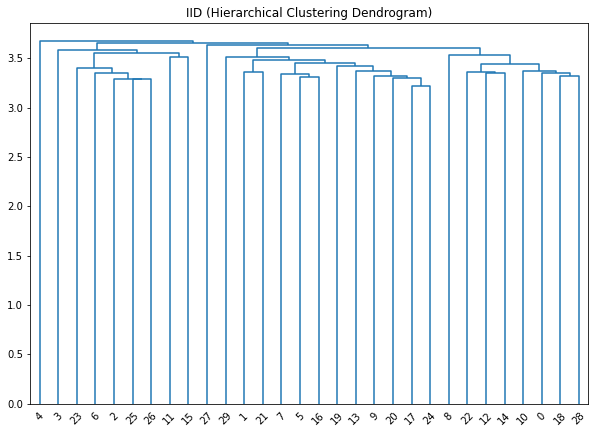

KeyboardInterrupt: Interrupted by user

In [54]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

for w_ls,topic in zip(w_ls_list,['IID','Non IID','Non IID(one shard)']):
    w_ls = w_ls.to('cpu')
    # 轉換為numpy陣列以使用Scikit-Learn
    w_ls_np = w_ls.numpy()

    # --- Silhouette Method ---

    # 紀錄silhouette_scores
    silhouette_scores = []

    # 試驗不同的k值
    for k in range(2, 11):  # 從2到10
        kmeans = KMeans(n_clusters=k).fit(w_ls_np)
        labels = kmeans.labels_
        score = silhouette_score(w_ls_np, labels)
        silhouette_scores.append(score)

    # 找出具有最高silhouette_score的k值
    best_k_silhouette = np.argmax(silhouette_scores) + 2
    print(f"Best K using Silhouette Method in {topic}: {best_k_silhouette}")

    # --- Hierarchical Clustering ---

    # 進行階層聚類
    Z = linkage(w_ls_np, 'ward')

    # 畫出樹狀圖（Dendrogram）
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    plt.title(f'{topic} (Hierarchical Clustering Dendrogram)')
    plt.show()

    # 在樹狀圖中，您可以選擇一個適當的層次，該層次將給出一個合適的K值。
    # 假設在樹狀圖中您選擇了K = x
    best_k_hierarchical = int(input("Enter the best K from the Dendrogram: "))
    print(f"Best K using Hierarchical Clustering: {best_k_hierarchical}")


In [88]:
from collections import Counter
Counter(cluster_labels)
print(cluster_labels)

[0 4 8 0 6 2 0 6 2 8 2 7 5 5 4 3 1 0 1 3 8 4 3 0 0 5 6 7 1 7]


In [82]:
import numpy as np
from sklearn.cluster import KMeans
# 評估不同群數的 K-Means 分群結果
scores = []
for n_clusters in range(2 , 10):
    # org_dist = org_dist.numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(org_dist)
    score = silhouette_score(org_dist, labels)  # 使用輪廓分數評分
    scores.append((n_clusters, score))
    
best_n_clusters = max(scores, key=lambda x: x[1])[0]  # 找出最佳群數
print("Best number of clusters:", best_n_clusters)
# 進行 K-Means 分群
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = best_kmeans.fit_predict(org_dist)
# 繪製分群結果
plot_2d(org_dist, 'Non-IID (one shard)',cluster_labels)


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Window

Best number of clusters: 9


c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Kevin\anaconda3\envs\kevin\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [95]:
dc = torch.quantile(dist_ls, torch.tensor(0.068))
rho = torch.tensor([(dist_matrix[i] < dc).sum().item() for i in range(num_vectors)])

print(rho)
for r in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print(torch.quantile(rho.float(), r))
# print(torch.nonzero(rho >= torch.quantile(rho.float(), 0.8)).squeeze())

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)
tensor(2.)


In [109]:
rho_neighbor = [torch.nonzero(dist_matrix[i] < dc).squeeze().tolist() for i in range(num_vectors)]
rho = torch.tensor([(len(indices)) for indices in rho_neighbor])

In [124]:
for i in range(num_vectors):
    mask = rho >= rho[i]
    if org_dist[i, mask].size(0) >= 2:
        # Get the second smallest distance from org_dist[i, mask]
        sorted_distances = org_dist[i, mask].sort()[0]
        delta[i] = sorted_distances[1]  # Second smallest distance
    else:
        delta[i] = torch.max(org_dist[i])
print(delta)

tensor([0.2287, 0.2601, 0.2400, 0.2423, 0.2380, 0.2372, 0.2427, 0.2478, 0.2619,
        0.2645, 0.2372, 0.2436, 0.2606, 0.2606, 0.2601, 0.2515, 0.2653, 0.2753,
        0.2653, 0.2527, 0.2400, 0.2741, 0.2515, 0.2423, 0.2287, 0.2610, 0.2380,
        0.2488, 0.2771, 0.2436])


In [643]:
print(rho_neighbor)

[[1, 4, 13, 16, 19, 28, 34, 38, 39, 42, 45, 46, 47, 62, 63, 66, 68, 73, 76, 81, 85, 86, 87, 93, 95, 97], [7, 9, 24, 26, 27, 29, 55, 56, 94], [0, 4, 13, 16, 19, 25, 28, 32, 34, 38, 39, 42, 45, 46, 47, 62, 63, 66, 68, 73, 76, 81, 85, 86, 87, 93, 95, 97], [18, 33, 36, 43, 60, 65, 75, 79, 88, 98], [11, 22, 30, 34, 40, 44, 45, 63, 74, 76, 80, 85, 89, 96], [0, 2, 13, 16, 28, 34, 38, 39, 42, 45, 46, 47, 62, 63, 66, 76, 85, 86, 87, 93, 97], [19, 28, 38, 53, 68, 81, 93, 95], [8, 14, 17, 20, 23, 48, 51, 64, 70], [1, 9, 24, 26, 27, 29, 55, 56, 94], [7, 14, 17, 20, 23, 34, 45, 48, 51, 64, 70, 76], [1, 8, 24, 26, 27, 29, 55, 56, 94], [31, 37, 61, 67, 69, 83, 84, 91, 92], [4, 22, 30, 34, 40, 44, 45, 47, 63, 74, 76, 80, 85, 87, 89, 96], [13, 25, 32, 34, 41, 42, 45, 47, 52, 54, 58, 59, 63, 73, 76, 78, 82, 85, 86, 87], [0, 2, 5, 13, 14, 16, 25, 32, 34, 36, 39, 41, 42, 43, 44, 45, 46, 47, 49, 52, 54, 58, 59, 60, 62, 63, 66, 71, 73, 76, 77, 78, 82, 85, 86, 87, 97], [7, 9, 14, 17, 20, 23, 25, 32, 34, 41, 

In [143]:
import torch

X = w_ls

# 求均值和標準差（按列計算，也就是 dim=0）
mean_val = torch.mean(X, dim=0)
std_val = torch.std(X, dim=0)

# 標準化
X_normalized = (X - mean_val) / std_val


print("Mean:", mean_val)
print("Std:", std_val)
print("Max:", max_val)
print("Min:", min_val)


Mean: tensor([ 0.0481,  0.0480,  0.2230,  ...,  0.0277, -0.0093, -0.0265],
       device='cuda:0')
Std: tensor([0.0114, 0.0100, 0.0073,  ..., 0.0093, 0.0184, 0.0164], device='cuda:0')
Max: tensor([0.0761, 0.0669, 0.2423,  ..., 0.0454, 0.0565, 0.0409], device='cuda:0')
Min: tensor([ 0.0245,  0.0251,  0.2036,  ...,  0.0046, -0.0406, -0.0578],
       device='cuda:0')


In [140]:
rho = [torch.exp(-(dist_matrix**2) / (2 * dc**2)).sum().item() for i in range(num_vectors)]
# def gaussian_kernel(dist_matrix, dc):
#     return torch.exp(-(dist_matrix**2) / (2 * dc**2))

# # Assuming you have dist_matrix and dc
# num_vectors = dist_matrix.shape[0]

# rho = torch.zeros(num_vectors)
# for i in range(num_vectors):
#     rho[i] = gaussian_kernel(dist_matrix[i], dc).sum().item()

# print(rho)


In [608]:
def weights_normal(w_ls):
    w_ls = w_ls.to('cpu')
    num_vectors = w_ls.shape[0]

    # 標準化
    mean_val = torch.mean(w_ls, dim=0)
    std_val = torch.std(w_ls, dim=0)

    # 檢查 std_val 是否為 0
    if torch.any(std_val == 0).item():
        print("Warning: Zero standard deviation found. Skipping normalization for those features.")
        std_val[std_val == 0] = 1.0  # 用1替代0，或者你可以選擇跳過這些特徵
    
    w_ls = (w_ls - mean_val) / (std_val + 1e-8)  # 添加一個小數以增加數值穩定性
    return w_ls

In [647]:
print(org_dist_ls[0])

tensor([[0.0000, 2.1010, 2.1133,  ..., 2.1341, 2.4701, 2.1146],
        [2.1010, 0.0000, 2.1165,  ..., 2.1898, 2.4394, 2.1655],
        [2.1133, 2.1165, 0.0000,  ..., 2.1706, 2.4826, 2.2216],
        ...,
        [2.1341, 2.1898, 2.1706,  ..., 0.0000, 2.5054, 2.1596],
        [2.4701, 2.4394, 2.4826,  ..., 2.5054, 0.0000, 2.4998],
        [2.1146, 2.1655, 2.2216,  ..., 2.1596, 2.4998, 0.0000]])


In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 假設 org_dist 是一個 NxN 的 NumPy 陣列，N 是資料點的數量。
# 這個矩陣應該是對稱的，對角線元素為 0。
# 使用 org_dist 計算最近的 k 鄰居。
k = 10
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='precomputed').fit(org_dist_ls[2])
distances, indices = nbrs.kneighbors(org_dist)

# 由於我們想要分 10 群，將最近的 k 鄰居用作分群依據。
# 這裡我們只是簡單地用 NumPy 的 array 標記每個群。
clusters = {}
for i in range(10):
    clusters[i] = []
    
for idx, neighbors in enumerate(indices):
    vote = np.bincount(neighbors // 10).argmax()
    clusters[vote].append(idx)

# clusters 現在包含 10 個群的資料點索引。
# 你可以使用這些索引來檢索原始資料或模型權重。


NameError: name 'org_dist_ls' is not defined

In [ ]:
def dfs(node, visited, adj_matrix):
    cluster = []
    stack = [node]
    while stack:
        current = stack.pop()
        if current not in visited:
            visited.add(current)
            cluster.append(current)
            neighbors = np.where(adj_matrix[current] == 1)[0]
            stack.extend(neighbors)
    return cluster

def min_distance_between_clusters(cluster1, cluster2, dist_matrix):
    distances = dist_matrix[np.ix_(cluster1, cluster2)]
    return distances.min()

def dfs_cluster(w , clients_ndata, clients, args):
    device = 'cuda:0' if args.gpu else 'cpu'
    w_ls = []
    ndata = sum(clients_ndata)
    num_vectors = len(w)
    labels = np.full(num_vectors, -1)
    dist_matrix = np.zeros((num_vectors, num_vectors))
    for i, client_ndata in enumerate(clients_ndata):
        if args.w :
            w_flat = torch.cat([l.view(-1) for l in w[i].values()]) * (client_ndata / ndata)
        else:
            w_flat = torch.cat([l.view(-1) for l in w[i].values()])
        w_ls.append(w_flat)
        for j in range(i + 1, num_vectors):
            total_dist = 0
            for (k,i_v),j_v in zip(w[i].items(),w[j].values()):
                lw = 0.8 if 'conv' in k else 0.2
                ww = 0.4 if 'weight' in k else 0.1
                total_dist += torch.norm(i_v - j_v)*ww*lw
            dist_matrix[i, j] = total_dist.to('cpu').numpy()
            dist_matrix[j, i] = dist_matrix[i, j]
    X = torch.stack(w_ls).to('cpu')

    # 動態調整dc使dc更具適應性，以反映數據的實際分佈
    dc = max(np.min(np.where(dist_matrix != 0, dist_matrix, np.inf), axis=1))
    print(f"dc: {round(dc,4)}")
    # 考慮節點的密度和中心性(該點與其他點的平均距離)
    densities = np.sum(dist_matrix <= dc, axis=1)
    # 找到距離小於或等於dc的鄰居，並以與其鄰居的距離的平均值當作中心性
    mask = (dist_matrix <= dc) & (dist_matrix > 0)
    centralities = np.sum(dist_matrix * mask, axis=1) / np.sum(mask, axis=1)
    neighbors_id = [np.where(row)[0] for row in mask]

    # 使用密度和局部中心性來更新鄰接矩陣
    adj_matrix = np.zeros_like(dist_matrix)
    for i in range(num_vectors):
        if densities[i] >= np.median(densities) and centralities[i] <= np.median(centralities):
            adj_matrix[i, neighbors_id[i]] = 1 # closest_indices
    
    # DFS algo
    visited = set()
    clusters = []
    shuffle_idx = np.random.permutation(num_vectors) # add random start point
    for i in shuffle_idx:
        if i not in visited:
            cluster = dfs(i, visited, adj_matrix)
            clusters.append(cluster)
    # 合併距離較近的小群
    merged_clusters = []
    merged = set()
    random.shuffle(clusters) # add shuffle for merged
    for i, cluster1 in enumerate(clusters):
        if i in merged:
            continue
        close_clusters = [i]
        for j, cluster2 in enumerate(clusters):
            if j != i and j not in merged:
                distance = min_distance_between_clusters(cluster1, cluster2, dist_matrix)
                # 使用先前計算的dc作為閾值
                if distance < dc:  
                    close_clusters.append(j)
                    merged.add(j)
        merged_cluster = []
        for idx in close_clusters:
            merged_cluster.extend(clusters[idx])
        merged_clusters.append(merged_cluster)
    clusters = merged_clusters
    # 後處理：移除雜訊
    min_cluster_size = 3  # 可以根據需要調整
    valid_clusters = []
    noise = []
    for cluster in clusters:
        if len(cluster) >= min_cluster_size:
            valid_clusters.append(cluster)
        else:
            noise.extend(cluster)
    print(f'valid clusters: {valid_clusters}')
    print(f'noise: {noise}')
    for cluster_idx, cluster in enumerate(valid_clusters):
        for p_idx in cluster:
            labels[p_idx] = cluster_idx
    print(f'labels: {labels}')
    # 輸出centers
    if args.w :
        centers = torch.stack([X[labels == k].sum(dim=0) for k in range(max(labels)+1)])
    else:
        centers = torch.stack([X[labels == k].mean(dim=0) for k in range(max(labels)+1)])
    #校正labels至int[0,len(centers)]，並保留-1(noise)
    labels_ls = list(set([label for label in labels.tolist() if label != -1]))
    labels_revise = [-1 if label == -1 else labels_ls.index(label) for label in labels.tolist()]
    # 指派client至對應的cluster
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in zip(clients,labels_revise)]
    
    #當centers存在nan時，則center_revise只存放無nan的centers
    filter_centers = [cw for cw in centers if not torch.isnan(cw).any() and not (cw == 0).all()]
    if len(filter_centers) != 0:
        center_revise = torch.stack(filter_centers)
    else:
        print(f'center has nan: {centers}')
    # center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any() and not (cw == 0).any()])
    # 將flatten過的centers按K(num_cluster)，逐一還原成OrderedDict([('layer',tensor(layer))])
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s).to(device) # transfer to gpu
            start_idx += numel
        centers_ls.append(centers_od)

    return centers_ls , labels_revise , dict(membership)

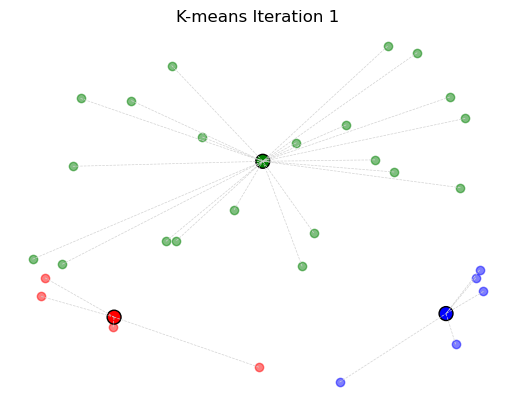

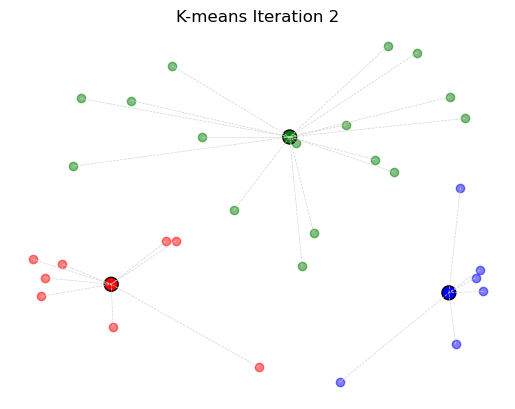

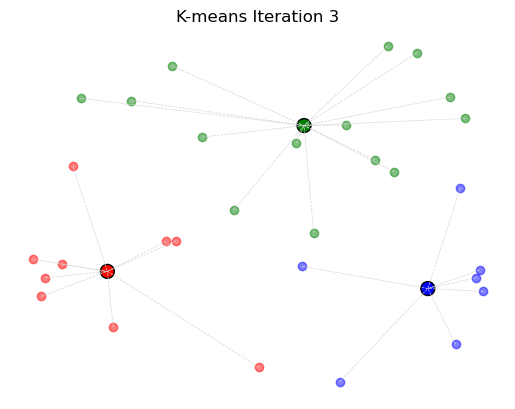

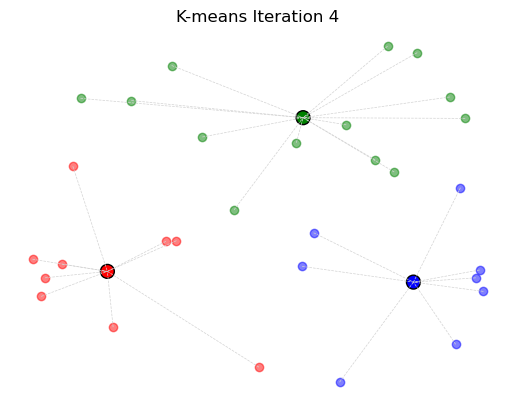

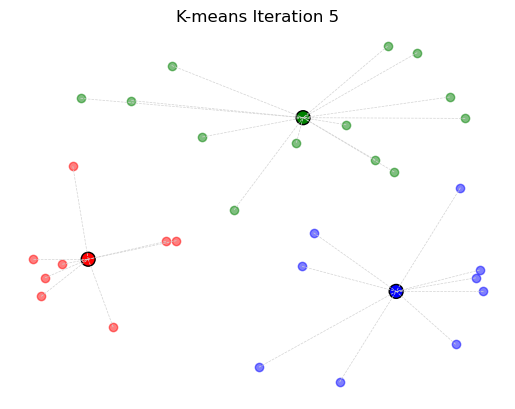

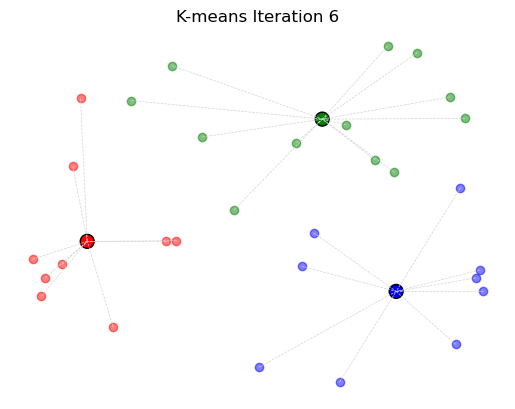

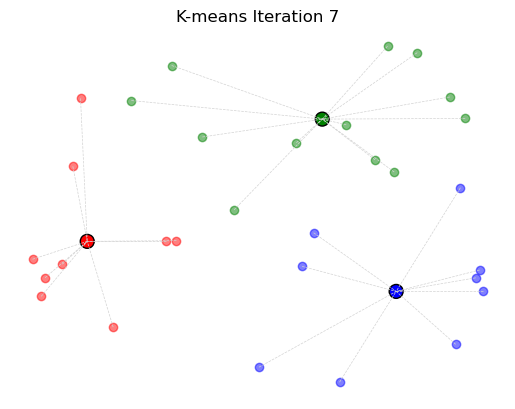

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 設定群集中心和元素的數量
seed_num = 3
dot_num = 30

# 初始元素
x = np.random.randint(0, 500, dot_num)
y = np.random.randint(0, 500, dot_num)
# 初始群集中心
kx = np.random.randint(0, 500, seed_num)
ky = np.random.randint(0, 500, seed_num)

# 計算兩點之間的距離
def dis(x, y, kx, ky):
    return int(((kx-x)**2 + (ky-y)**2)**0.5)

# 對每筆元素進行分群
def cluster(x, y, kx, ky):
    team = []
    for i in range(seed_num):
        team.append([])
    mid_dis = 99999999
    for i in range(dot_num):
        for j in range(seed_num):
            distant = dis(x[i], y[i], kx[j], ky[j])
            if distant < mid_dis:
                mid_dis = distant
                flag = j
        team[flag].append([x[i], y[i]])
        mid_dis = 99999999
    return team

# 對分群完的元素找出新的群集中心
def re_seed(team, kx, ky):
    sumx = 0
    sumy = 0
    new_seed = []
    for index, nodes in enumerate(team):
        if nodes == []:
            new_seed.append([kx[index], ky[index]])
            continue
        for node in nodes:
            sumx += node[0]
            sumy += node[1]
        new_seed.append([int(sumx/len(nodes)), int(sumy/len(nodes))])
        sumx = 0
        sumy = 0
    nkx = []
    nky = []
    for i in new_seed:
        nkx.append(i[0])
        nky.append(i[1])
    return nkx, nky

# k-means 分群
def kmeans(x, y, kx, ky, fig, results=[]):
    team = cluster(x, y, kx, ky)
    nkx, nky = re_seed(team, kx, ky)
    
    results.append({
        'data_points': [(x[i], y[i]) for i in range(dot_num)],
        'initial_centroids': [(kx[i], ky[i]) for i in range(seed_num)],
        'new_centroids': [(nkx[i], nky[i]) for i in range(seed_num)],
        'clusters': team
    })

    # 判斷群集中心是否不再更動
    if nkx == list(kx) and nky == list(ky):
        return results
    else:
        fig += 1
        return kmeans(x, y, nkx, nky, fig, results)

results = kmeans(x, y, kx, ky, fig=0)

colors = ['red', 'green', 'blue']

def plot_kmeans_iteration_clean(iteration_data, iter_num):
    fig, ax = plt.subplots()
    
    # 繪製群集中心
    initial_centroids = iteration_data['initial_centroids']
    new_centroids = iteration_data['new_centroids']
    clusters = iteration_data['clusters']
    
    for idx, cluster in enumerate(clusters):
        if not cluster:  # Skip empty clusters
            continue
        
        # 繪製資料點
        x_vals, y_vals = zip(*cluster)
        ax.scatter(x_vals, y_vals, color=colors[idx], alpha=0.5, label=f"Cluster {idx + 1}", marker='o')
        
        # 連接資料點與其群集中心
        for point in cluster:
            ax.plot([point[0], new_centroids[idx][0]], [point[1], new_centroids[idx][1]], 
                    color='lightgrey', linestyle='--', linewidth=0.5)
    
    # 繪製新的群集中心
    new_centroid_x, new_centroid_y = zip(*new_centroids)
    ax.scatter(new_centroid_x, new_centroid_y, color=colors, s=100, edgecolor='black', label="Centroids", marker='o')

    ax.set_title(f"K-means Iteration {iter_num}")
    # ax.axis('off')  # Turn off axis
    
    plt.show()

# Visualizing all iterations with clean visuals
for idx, iteration_data in enumerate(results):
    plot_kmeans_iteration_clean(iteration_data, idx + 1)


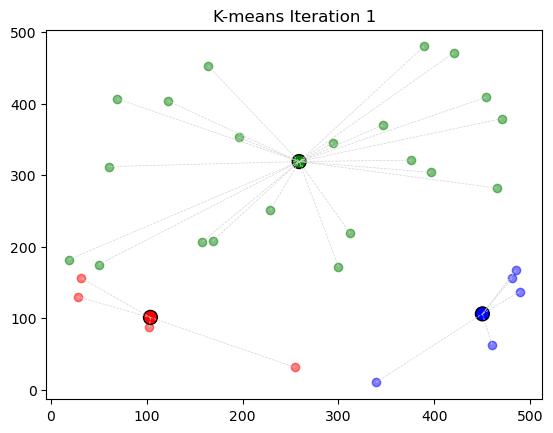

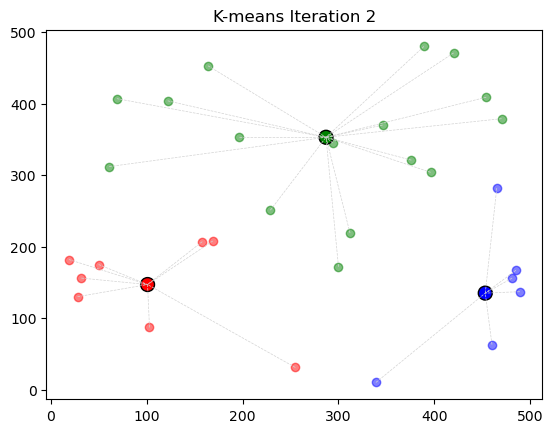

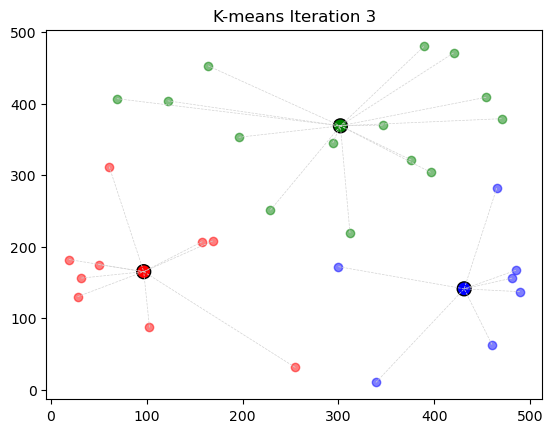

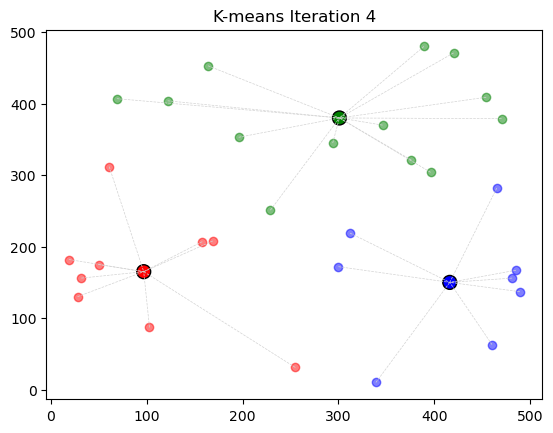

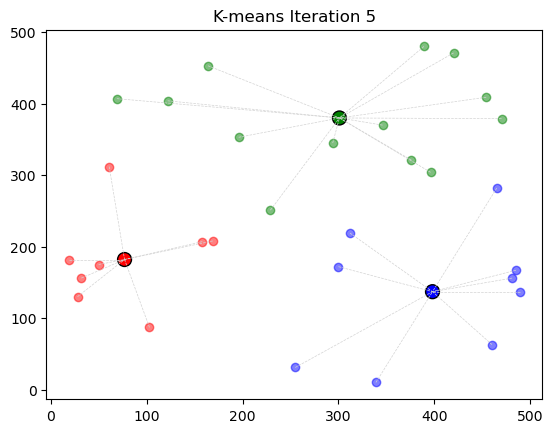

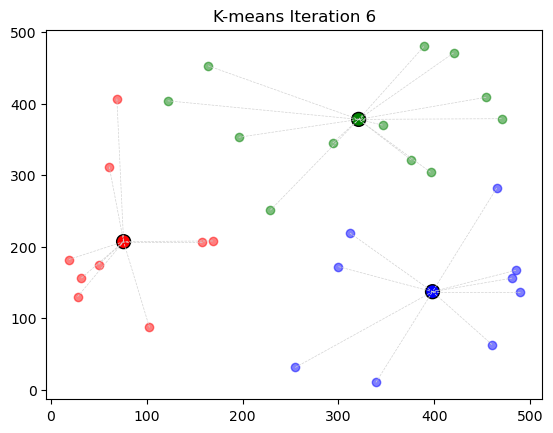

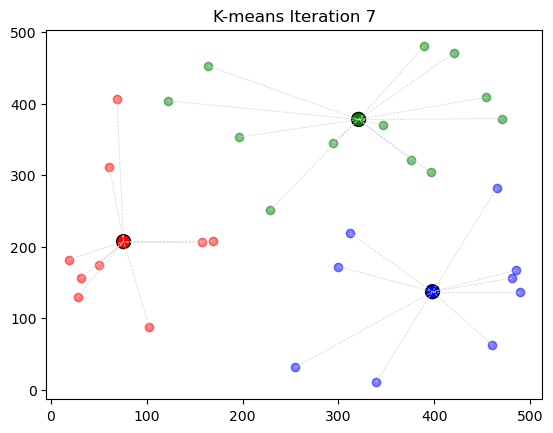

In [2]:
def plot_kmeans_iteration_clean(iteration_data, iter_num):
    fig, ax = plt.subplots()
    
    # 繪製群集中心
    initial_centroids = iteration_data['initial_centroids']
    new_centroids = iteration_data['new_centroids']
    clusters = iteration_data['clusters']
    
    for idx, cluster in enumerate(clusters):
        if not cluster:  # Skip empty clusters
            continue
        
        # 繪製資料點
        x_vals, y_vals = zip(*cluster)
        ax.scatter(x_vals, y_vals, color=colors[idx], alpha=0.5, label=f"Cluster {idx + 1}", marker='o')
        
        # 連接資料點與其群集中心
        for point in cluster:
            ax.plot([point[0], new_centroids[idx][0]], [point[1], new_centroids[idx][1]], 
                    color='lightgrey', linestyle='--', linewidth=0.5)
    
    # 繪製新的群集中心
    new_centroid_x, new_centroid_y = zip(*new_centroids)
    ax.scatter(new_centroid_x, new_centroid_y, color=colors, s=100, edgecolor='black', label="Centroids", marker='o')

    ax.set_title(f"K-means Iteration {iter_num}")
    # ax.axis('off')  # Turn off axis
    
    plt.show()
for idx, iteration_data in enumerate(results):
    plot_kmeans_iteration_clean(iteration_data, idx + 1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data is relatively concentrated
data_concentrated, _ = make_blobs(n_samples=300, centers=1, cluster_std=0.5, center_box=(-10, 10))

# 2. Number of clusters chosen is too many
data_two_clusters, _ = make_blobs(n_samples=[150, 150], centers=[[2, 2], [-2, -2]], cluster_std=0.5)
kmeans_too_many = KMeans(n_clusters=5).fit(data_two_clusters)

# 3. No clear structure in the data
data_no_structure = np.random.rand(300, 2) * 10 - 5
kmeans_no_structure = KMeans(n_clusters=3).fit(data_no_structure)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Data is relatively concentrated
axes[0].scatter(data_concentrated[:, 0], data_concentrated[:, 1], alpha=0.7)
axes[0].set_title("資料分佈相對集中")

# Number of clusters chosen is too many
axes[1].scatter(data_two_clusters[:, 0], data_two_clusters[:, 1], c=kmeans_too_many.labels_, alpha=0.7)
axes[1].scatter(kmeans_too_many.cluster_centers_[:, 0], kmeans_too_many.cluster_centers_[:, 1], c='red', marker='X')
axes[1].set_title("選擇的群數太多")

# No clear structure in the data
axes[2].scatter(data_no_structure[:, 0], data_no_structure[:, 1], c=kmeans_no_structure.labels_, alpha=0.7)
axes[2].scatter(kmeans_no_structure.cluster_centers_[:, 0], kmeans_no_structure.cluster_centers_[:, 1], c='red', marker='X')
axes[2].set_title("資料本身沒有明確的分群結構")

plt.tight_layout()
plt.show()


: 

In [31]:
import json
import numpy as np
import matplotlib.pyplot as plt
import json

# First, we need to load the data again as the kernel was reset previously.
with open('../save/json/mnist/fedsem/test/dist.json', "r") as file:
    dist_data = json.load(file)

distances = dist_data['distance_from_centers']

# Define a function to get the adjusted colors for the points
def get_adjusted_colors(assignments, base_colors):
    colors = [base_colors[cluster_id] for cluster_id in assignments]
    adjusted_colors = []
    for color, cluster_id in zip(colors, assignments):
        adjusted_intensity = 1 - (assignments.count(cluster_id) / len(assignments))
        if color == "red":
            adjusted_colors.append((1, adjusted_intensity, adjusted_intensity))
        elif color == "yellow":
            adjusted_colors.append((1, 1, adjusted_intensity))
        elif color == "green":
            adjusted_colors.append((adjusted_intensity, 1, adjusted_intensity))
    return adjusted_colors

# Simulate K-means clustering using the provided distances
assignments = []  # List of lists to store cluster assignments for each iteration
centers_list = []  # List of lists to store cluster centers for each iteration

for iteration_distances in distances:
    current_assignments = [np.argmin(point_distances) for point_distances in iteration_distances]
    assignments.append(current_assignments)
    
    # Calculate centers for this iteration
    centers = []
    for cluster_id in range(3):
        cluster_points = points[np.array(current_assignments) == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            centers.append(center)
        else:
            centers.append(np.array([np.nan, np.nan]))  # If there are no points for a center, append NaN values
    centers_list.append(centers)

colors = ['red', 'yellow', 'green']

# Initial data without clustering
plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c='grey', marker='o', s=50, alpha=0.6)
plt.title('Initial Data')
plt.show()

# Iterations
for idx in range(3):
    plt.figure(figsize=(5, 5))
    plt.scatter(points[:, 0], points[:, 1], c=get_adjusted_colors(assignments[idx], colors), marker='o', s=50, alpha=0.6)
    for cluster_id, center in enumerate(centers_list[idx]):
        if not np.isnan(center).any():
            plt.scatter(center[0], center[1], c=colors[cluster_id], marker='o', edgecolors='black', s=100)
            
            # Drawing light gray dashed lines connecting each point to the cluster center
            cluster_points = points[np.array(assignments[idx]) == cluster_id]
            for point in cluster_points:
                plt.plot([point[0], center[0]], [point[1], center[1]], c='lightgray', linestyle='--', linewidth=0.5)
        
    plt.title(f'Iteration {idx + 1}')
    plt.show()

# # Plotting
# colors = ['red', 'yellow', 'green']
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# # Initial data without clustering
# axes[0].scatter(points[:, 0], points[:, 1], c='grey', marker='o', s=50, alpha=0.6)
# axes[0].set_title('Initial Data')

# # Iterations
# for idx, ax in enumerate(axes[1:]):
#     ax.scatter(points[:, 0], points[:, 1], c=get_adjusted_colors(assignments[idx], colors), marker='o', s=50, alpha=0.6)
#     for cluster_id, center in enumerate(centers_list[idx]):
#         if not np.isnan(center).any():
#             ax.scatter(center[0], center[1], c=colors[cluster_id], marker='o', edgecolors='black', s=100)
            
#             # Drawing light gray dashed lines connecting each point to the cluster center
#             cluster_points = points[np.array(assignments[idx]) == cluster_id]
#             for point in cluster_points:
#                 ax.plot([point[0], center[0]], [point[1], center[1]], c='lightgray', linestyle='--', linewidth=0.5)
        
#     ax.set_title(f'Iteration {idx + 1}')

# plt.tight_layout()
# plt.show()


NameError: name 'points' is not defined

In [5]:
import plotly.graph_objects as go
import torch
import numpy as np
from sklearn.metrics import pairwise_distances
org_dist_ls = []
for w_ls,topic in zip(w_ls_list,['IID','Non-IID(two shards)','Non-IID(one shard)','Non-IID(unbalanced)']): #rw_list
    # w_ls = weights_normal(w_ls)
    num_vectors = w_ls.shape[0]
    w_ls_np = w_ls.to('cpu').numpy()
    # 標準化
    # mean_val = torch.mean(w_ls, dim=0)
    # std_val = torch.std(w_ls, dim=0)
    # w_ls = (w_ls - mean_val) / std_val
    # dist_matrix = torch.zeros((num_vectors, num_vectors))
    # dist_ls = []
    # 計算距離矩陣，可以選擇其他方法eg:['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
    dist_matrix = pairwise_distances(w_ls_np, metric='euclidean')
    dist_ls = torch.tensor(dist_matrix[np.triu_indices(num_vectors, k=1)])
    dist_matrix = torch.tensor(dist_matrix)
    # for i in range(num_vectors):
    #     dist_matrix[i, i+1:] = torch.sqrt(torch.sum((w_ls[i] - w_ls[i+1:]) ** 2, dim=1))
    #     dist_matrix[i+1:, i] = dist_matrix[i, i+1:]
    #     dist_ls.append(dist_matrix[i, i+1:])
    # dist_ls = torch.cat(dist_ls)
    org_dist = dist_matrix
    org_dist_ls.append(org_dist)
    non_zero_indices = torch.nonzero(dist_matrix)
    dist_matrix = dist_matrix[non_zero_indices[:, 0], non_zero_indices[:, 1]].reshape(num_vectors, num_vectors - 1)
    # mean = torch.mean(dist_matrix)
    # std = torch.std(dist_matrix)
    # dist_matrix = (dist_matrix - mean) / std
    dc_per = [0.05, 0.068, 0.1, 0.15, 0.2] # 0.5(可分群)
    # gm_per = [0.9]# [0.8,0.85,0.9,0.95,0.97]
    plot_2d(org_dist,topic)
    # plot_pca_2d(w_ls,topic)
    # plot_pca_3d(w_ls,topic)
    
    for i, dc in enumerate(torch.quantile(dist_ls, torch.tensor(dc_per))):
        print(f'cut off distance({dc_per[i]}):{round(dc.item(),4)}')
        # 計算rho:距離目標點<dc的點數
        rho_neighbor = [torch.nonzero(dist_matrix[i] < dc).squeeze().tolist() for i in range(num_vectors)]
        rho = torch.tensor([(dist_matrix[i] < dc).sum().item() for i in range(num_vectors)])
        # rho = torch.tensor([(len(indices)) for indices in rho_neighbor])
        # 每個點到"其他所有 rho 值大於自身的點"中最小距離，當不存在時取和自己最遠距離的點的距離
        delta = torch.zeros(num_vectors)
        for i in range(num_vectors):
            mask = rho > rho[i]
            if org_dist[i, mask].size(0):
                delta[i] = torch.min(org_dist[i, mask])
            else:
                delta[i] = torch.max(org_dist[i])
        print('Rho values:',rho)
        print("Delta values:", delta)
        d_per = [0.6] # [0.4,0.5,0.6,0.7,0.8]
        r_per = [0.6] # [0.4,0.5,0.6]
        for r in r_per:
            for d in d_per:
                rd_idxs = torch.where((rho >= torch.quantile(rho.float(), r)) & (delta >= torch.quantile(delta, d)))[0]
                print(f'cluster centers:{rd_idxs.tolist()}')
                plot_rho_delta(rho,delta,rd_idxs,topic)
        # gamma = torch.tensor([(r*d).item() for r,d in zip(rho,delta)])
        # sorted_gamma, gamma_indices = torch.sort(gamma)
        # print("Sorted gamma(large 10):", sorted_gamma[-10:])
        # print("Sorted gamma(large 10) indices:", gamma_indices.tolist()[-10:])
        # for i,gm in enumerate(torch.quantile(gamma, torch.tensor(gm_per)).tolist()):
        #     print(f'gamma({gm_per[i]}): {gm}')
        #     plot_rho_delta(rho,delta,gamma,gm,topic)

cut off distance(0.05):3.2416
Rho values: tensor([ 0,  3,  0,  4,  0,  0,  0,  0, 10,  0,  0,  3,  0,  0,  3,  0,  0,  2,
         2,  4,  0,  0,  0,  4,  0,  0,  0,  4,  0,  5])
Delta values: tensor([3.2527, 3.2204, 3.4170, 3.2163, 3.3773, 3.2479, 3.2623, 3.3422, 3.4829,
        3.2591, 3.2578, 3.1986, 3.2430, 3.3816, 3.2244, 3.2503, 3.2621, 3.2323,
        3.2371, 3.2211, 3.3247, 3.2838, 3.4063, 3.2160, 3.2503, 3.2565, 3.2888,
        3.2187, 3.2816, 3.2082])
cluster centers:[2, 4, 6, 7, 8, 13, 16, 20, 21, 22, 26, 28]


cut off distance(0.068):3.2488
Rho values: tensor([ 0,  3,  0,  5,  0,  1,  0,  0, 11,  0,  1,  5,  3,  0,  4,  0,  0,  2,
         2,  6,  0,  0,  0,  6,  0,  0,  0,  5,  0,  6])
Delta values: tensor([3.2527, 3.2204, 3.4170, 3.2106, 3.3773, 3.2479, 3.2623, 3.3422, 3.4829,
        3.2591, 3.2435, 3.1986, 3.2430, 3.3816, 3.2244, 3.2503, 3.2621, 3.2323,
        3.2371, 3.2211, 3.3247, 3.2771, 3.4063, 3.2160, 3.2503, 3.2565, 3.2888,
        3.2149, 3.2816, 3.2082])
cluster centers:[8]


cut off distance(0.1):3.2587
Rho values: tensor([ 1,  4,  0, 10,  0,  1,  0,  0, 14,  0,  2,  5,  5,  0,  7,  2,  0,  3,
         5,  7,  0,  0,  0,  8,  1,  1,  0,  6,  0,  6])
Delta values: tensor([3.2527, 3.2204, 3.4170, 3.2163, 3.3773, 3.2479, 3.2623, 3.3422, 3.4829,
        3.2591, 3.2435, 3.1986, 3.2430, 3.3816, 3.2244, 3.2503, 3.2621, 3.2323,
        3.2371, 3.2106, 3.3247, 3.2771, 3.4063, 3.2160, 3.2503, 3.2565, 3.2888,
        3.2149, 3.2816, 3.2082])
cluster centers:[8]


cut off distance(0.15):3.2702
Rho values: tensor([ 3,  8,  0, 12,  0,  1,  2,  0, 15,  1,  4,  9,  8,  0, 11,  3,  1,  5,
         5, 11,  0,  0,  0, 11,  3,  1,  0,  8,  0, 10])
Delta values: tensor([3.2527, 3.2204, 3.4170, 3.2163, 3.3773, 3.2479, 3.2623, 3.3422, 3.4829,
        3.2591, 3.2435, 3.1986, 3.2430, 3.3811, 3.2244, 3.2503, 3.2621, 3.2323,
        3.2371, 3.2106, 3.3247, 3.2771, 3.4063, 3.2160, 3.2503, 3.2565, 3.2888,
        3.2149, 3.2816, 3.2082])
cluster centers:[8]


cut off distance(0.2):3.282
Rho values: tensor([ 4, 11,  0, 13,  0,  1,  3,  0, 17,  3,  5, 14, 11,  0, 13,  6,  3,  7,
         7, 13,  0,  2,  0, 11,  3,  3,  0,  9,  2, 13])
Delta values: tensor([3.2527, 3.2204, 3.4170, 3.2155, 3.3773, 3.2479, 3.2623, 3.3422, 3.4829,
        3.2591, 3.2435, 3.1986, 3.2430, 3.3811, 3.2244, 3.2503, 3.2621, 3.2323,
        3.2371, 3.2086, 3.3247, 3.2771, 3.4063, 3.2160, 3.2503, 3.2565, 3.2888,
        3.2149, 3.2816, 3.2082])
cluster centers:[8]


cut off distance(0.05):2.3073
Rho values: tensor([0, 1, 0, 5, 2, 1, 0, 0, 7, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 3, 5, 0, 0,
        5, 4, 0, 0, 6, 0])
Delta values: tensor([3.1879, 2.2562, 2.7738, 2.0073, 2.2404, 2.0798, 2.5272, 2.6146, 3.5930,
        2.8914, 3.0229, 2.6868, 2.1375, 2.2330, 2.6293, 3.2227, 2.7576, 2.6172,
        2.1607, 2.7792, 2.2048, 2.1318, 2.5539, 2.6436, 2.0115, 2.0833, 3.0596,
        2.6717, 2.1897, 3.4932])
cluster centers:[8]


cut off distance(0.068):2.3483
Rho values: tensor([0, 1, 0, 6, 3, 2, 0, 0, 9, 0, 0, 0, 4, 4, 0, 0, 0, 0, 1, 0, 5, 5, 0, 0,
        6, 5, 0, 0, 9, 0])
Delta values: tensor([3.1879, 2.2562, 2.7738, 2.0073, 2.2404, 2.0798, 2.5272, 2.6146, 3.5930,
        2.8914, 3.0229, 2.6868, 1.4013, 2.2330, 2.6293, 3.2227, 2.7576, 2.6172,
        2.1607, 2.7792, 2.2048, 2.1318, 2.5539, 2.6436, 2.0115, 2.2103, 3.0596,
        2.6717, 3.6407, 3.4932])
cluster centers:[8, 28]


cut off distance(0.1):2.5878
Rho values: tensor([ 0,  3,  0,  9,  5,  2,  2,  0, 13,  0,  1,  1,  6,  7,  0,  0,  0,  1,
         2,  0,  6,  5,  2,  0,  7,  7,  0,  0,  9,  0])
Delta values: tensor([3.1879, 2.2562, 2.7738, 2.0319, 2.2404, 2.0798, 2.5272, 2.6146, 3.5930,
        2.8914, 3.0229, 2.5727, 2.1375, 2.2330, 2.6293, 3.2227, 2.7576, 2.6172,
        2.1607, 2.7792, 2.2048, 2.0833, 2.5539, 2.6436, 1.2156, 2.2103, 3.0596,
        2.6717, 2.1897, 3.4734])
cluster centers:[8]


cut off distance(0.15):2.6959
Rho values: tensor([ 0,  7,  0, 12, 11,  5,  3,  2, 16,  0,  1,  2,  6,  9,  1,  0,  0,  2,
         3,  0,  6,  8,  3,  1, 12, 10,  0,  1, 11,  0])
Delta values: tensor([3.1732, 2.2562, 2.7738, 2.0319, 2.3870, 2.0798, 2.5272, 2.6146, 3.5930,
        2.8914, 2.4553, 2.5727, 2.1375, 2.2330, 2.6293, 3.2227, 2.7576, 2.6172,
        2.1607, 2.7792, 2.2048, 2.0833, 2.5539, 2.6436, 2.1094, 2.2103, 3.0596,
        2.6717, 2.0073, 3.4369])
cluster centers:[8]


cut off distance(0.2):2.8089
Rho values: tensor([ 0, 12,  2, 12, 13,  5,  3,  2, 20,  0,  1,  3,  9, 12,  1,  0,  2,  4,
         6,  1,  9, 11,  4,  1, 12, 13,  0,  4, 12,  0])
Delta values: tensor([3.1732, 2.2562, 2.7738, 2.0319, 2.3870, 2.0798, 2.5272, 2.6146, 3.5930,
        2.8914, 2.4553, 2.5727, 2.1375, 2.2330, 2.6293, 3.2227, 2.7576, 2.6172,
        2.1607, 2.7792, 2.2048, 2.0833, 2.5539, 2.6436, 2.1094, 2.2103, 3.0596,
        2.6717, 2.1897, 3.4369])
cluster centers:[8]


cut off distance(0.05):0.2652
Rho values: tensor([2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 1,
        2, 1, 1, 0, 1, 2])
Delta values: tensor([1.5163, 1.5318, 1.4693, 1.5212, 1.5343, 1.4339, 1.4365, 0.2760, 0.2441,
        1.4786, 1.4421, 1.5358, 1.5270, 1.5227, 0.2619, 1.5369, 1.4739, 1.5274,
        1.4178, 1.5691, 0.2728, 1.5622, 1.5318, 0.2601, 1.5675, 1.4147, 0.2362,
        0.2659, 1.4263, 1.5722])
cluster centers:[1, 4, 11, 12, 13, 15, 17, 19, 21, 22, 24, 29]


cut off distance(0.068):0.8534
Rho values: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
Delta values: tensor([1.5163, 1.5318, 1.4693, 1.5212, 1.5343, 1.5579, 1.5369, 1.5722, 1.5362,
        1.4786, 1.5698, 1.5358, 1.5270, 1.5227, 1.5647, 1.5369, 1.4739, 1.5274,
        1.5000, 1.5691, 1.5119, 1.5622, 1.5318, 1.5558, 1.5675, 1.5039, 1.5241,
        1.5363, 1.5275, 1.5722])
cluster centers:[5, 6, 7, 10, 14, 15, 19, 21, 23, 24, 27, 29]


cut off distance(0.1):1.4054
Rho values: tensor([5, 4, 7, 5, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 5, 2, 5,
        2, 2, 2, 2, 2, 2])
Delta values: tensor([1.3838, 0.2299, 1.4693, 1.3889, 1.4429, 1.4339, 1.4365, 1.4471, 1.4461,
        0.1787, 1.4421, 1.4214, 1.4187, 1.4355, 0.2619, 1.4247, 1.4739, 1.4406,
        1.4178, 1.4676, 1.4289, 1.3964, 1.4494, 1.3974, 1.4568, 1.4147, 1.4343,
        1.4264, 1.4263, 1.4693])
cluster centers:[2, 4, 6, 7, 8, 10, 16, 17, 19, 22, 24, 29]


cut off distance(0.15):1.4289
Rho values: tensor([ 9,  5, 11,  9,  2,  2,  2,  2,  2, 10,  2,  4,  6,  2,  5,  3, 13,  2,
         5,  2,  2,  6,  2,  7,  2,  5,  2,  3,  3,  2])
Delta values: tensor([1.3838, 0.2299, 0.2032, 1.3889, 1.4429, 1.4339, 0.2376, 1.4471, 1.4461,
        0.1787, 1.4421, 0.2489, 1.4187, 1.4355, 0.2619, 0.2241, 1.4739, 1.4406,
        1.4178, 1.4634, 0.2728, 0.2601, 1.4494, 1.3974, 1.4568, 1.4147, 1.4343,
        1.4264, 1.4263, 1.4693])
cluster centers:[16]


cut off distance(0.2):1.4364
Rho values: tensor([10,  6, 18, 10,  2,  4,  2,  2,  2, 14,  2,  6,  8,  3,  5,  6, 19,  2,
         5,  2,  5,  7,  2,  7,  2,  6,  4,  5,  6,  2])
Delta values: tensor([1.3838, 0.2299, 0.2032, 1.3889, 0.2362, 1.4339, 0.2376, 0.2774, 0.2793,
        0.1787, 0.2412, 0.2489, 1.4187, 1.4355, 0.2619, 0.2291, 1.4739, 0.2254,
        0.2521, 1.4634, 0.2728, 1.3964, 0.2310, 1.3974, 1.4568, 1.4147, 1.4343,
        0.2969, 1.4263, 1.4693])
cluster centers:[12, 16, 21, 23, 25, 28]


cut off distance(0.05):3.2267
Rho values: tensor([8, 4, 0, 3, 2, 3, 0, 0, 0, 5, 0, 0, 0, 4, 2, 0, 4, 0, 0, 2, 0, 0, 0, 0,
        2, 0, 0, 0, 5, 0])
Delta values: tensor([4.7745, 2.5708, 3.3547, 3.1756, 2.9637, 2.9502, 3.9987, 4.2137, 4.0120,
        3.2279, 3.7684, 3.4711, 4.0473, 2.9761, 2.9144, 4.0755, 2.9944, 3.6331,
        4.0052, 3.1039, 3.8361, 3.5859, 4.0027, 4.5249, 3.1452, 3.5278, 3.4401,
        4.0901, 3.1711, 3.9141])
cluster centers:[0]


cut off distance(0.068):3.2622
Rho values: tensor([10,  5,  0,  4,  3,  4,  0,  0,  0,  6,  0,  0,  0,  6,  4,  0,  7,  0,
         0,  3,  0,  0,  0,  0,  3,  0,  0,  0,  5,  0])
Delta values: tensor([4.7745, 2.5708, 3.3547, 3.1756, 2.9637, 2.9502, 3.9987, 4.2137, 4.0120,
        3.0895, 3.7684, 3.4711, 4.0473, 2.9761, 2.9144, 4.0755, 2.9944, 3.6331,
        4.0052, 3.1039, 3.8361, 3.5859, 4.0027, 4.5249, 3.1452, 3.5278, 3.4401,
        4.0901, 2.7013, 3.9141])
cluster centers:[0]


cut off distance(0.1):3.3749
Rho values: tensor([11,  5,  2,  5,  5,  8,  0,  0,  0,  8,  0,  0,  0,  8,  7,  0, 11,  0,
         0,  5,  0,  0,  0,  0,  6,  0,  0,  0,  7,  0])
Delta values: tensor([4.7745, 2.5708, 3.3547, 3.0259, 2.9637, 2.9502, 3.7928, 3.9611, 3.8596,
        3.0895, 3.6369, 3.4711, 4.0473, 2.9761, 2.9144, 4.0173, 4.6193, 3.6331,
        3.8348, 3.1039, 3.5534, 3.3963, 3.9610, 4.3317, 3.1452, 3.4900, 3.4401,
        3.7926, 2.7013, 3.9141])
cluster centers:[0, 16]


cut off distance(0.15):3.5083
Rho values: tensor([11,  8,  7,  7,  9, 11,  0,  0,  0,  8,  0,  2,  0, 10, 10,  0, 13,  0,
         0, 11,  0,  1,  0,  0, 11,  2,  2,  0,  9,  0])
Delta values: tensor([2.9944, 2.5708, 3.3547, 3.0259, 2.9637, 3.3449, 3.7397, 3.9611, 3.8419,
        2.7013, 3.6369, 3.4711, 3.9360, 2.9761, 3.1817, 3.8333, 4.6193, 3.6331,
        3.8348, 3.3010, 3.5534, 3.3963, 3.9082, 4.3010, 3.2556, 3.4900, 3.4401,
        3.7926, 3.1452, 3.9141])
cluster centers:[16]


cut off distance(0.2):3.5916
Rho values: tensor([12, 10, 12, 10, 11, 14,  0,  0,  0, 11,  0,  5,  0, 10, 11,  0, 14,  0,
         0, 14,  1,  2,  0,  0, 11,  8,  5,  0, 13,  0])
Delta values: tensor([2.9502, 2.5708, 3.3547, 3.0259, 2.9637, 4.5732, 3.7166, 3.9611, 3.8419,
        2.7013, 3.6369, 3.4711, 3.9360, 2.9144, 3.1817, 3.8333, 4.6193, 3.6331,
        3.8348, 4.5249, 3.5534, 3.3963, 3.9082, 4.2538, 3.1452, 3.4900, 3.4401,
        3.7926, 3.1515, 3.9141])
cluster centers:[5, 16, 19]


In [76]:
sorted_delta, delta_indices = torch.sort(delta)
sorted_rho, rho_indices = torch.sort(rho)
sorted_gamma, gamma_indices = torch.sort(gamma)
print("Sorted delta:", sorted_delta)
print("Sorted delta indices:", delta_indices)
print("Sorted rho:", sorted_rho)
print("Sorted rho indices:", rho_indices)
print("Sorted gamma:", sorted_gamma)
print("Sorted gamma indices:", gamma_indices)

Sorted delta: tensor([6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12,
        6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12,
        6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12,
        6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12, 6.7543e+12,
        6.7543e+12, 6.7543e+12, 6.7543e+12])
Sorted delta indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26])
Sorted rho: tensor([ 0, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25])
Sorted rho indices: tensor([26,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25])
Sorted gamma: tensor([0.0000e+00, 1.6886e+14, 1.6886e+14, 1.6886e+14, 1.6886e+14, 1.6886e+14,
        1.6886e+14, 1.6886e+14, 1.6886e+14, 1.6886e+14, 1.6886e+14, 1.6886e+14,
        1.6886e+14

Q:根據"Clustering by fast search and find of density peaks"算法，如何找出聚類中心?

A:根據"Clustering by fast search and find of density peaks"算法，可以使用以下步驟找到聚類中心：

計算每個點的局部密度（rho值）：以每個點為中心，在一定半徑範圍內計算該區域內的點數。這個半徑可以通過手動設置或使用自適應方法來確定。

計算每個點的delta值：對於每個點，找到比它密度更高且距離最近的點，計算它們之間的距離作為該點的delta值。

在rho-delta圖上找到聚類中心：以rho值作為橫軸，delta值作為縱軸，畫出散點圖。在圖中的右上角，通常可以找到一些密度和距離都較高的點，這些點被視為聚類中心。

可選：對聚類中心進行進一步的處理和調整。例如，可以根據特定的閾值，將離聚類中心較近且密度較低的點劃分為噪音點或者隨機分佈的點。

通過這些步驟，"Clustering by fast search and find of density peaks"算法能夠找到具有高密度和適當距離特徵的點作為聚類中心。

Algorithm: Clustering by fast search and find of density peaks
Input: 
    Dataset X={x1, x2,..., xn}
    Cutoff distance dc

// Step 1: Compute Density
for each data point xi in X do
    ρi = count of points in X whose distance to xi is less than dc

// Step 2: Compute Distance
for each data point xi in X do
    δi = minimum distance from xi to any point xj where ρj > ρi
    if no such point exists, δi = maximum distance from xi to any point in X

// Step 3: Find Clustering Centers
Clustering Centers = Data points with relatively high ρ and δ

// Step 4: Assign Clusters
for each data point xi in X in descending order of ρi do
    if xi is a Clustering Center then
        assign xi to a new cluster
    else
        assign xi to the same cluster as its nearest neighbor with higher density

Output: 
    Cluster assignment for each data point in X


Algorithm: Clustering by fast search and find of density peaks

Input: D = {d1, d2, ..., dn} // 資料集
       dc // 截斷距離

Output: Clusters C = {c1, c2, ..., ck}

Steps:
1. 初始化:
   對於每個點 di ∈ D, 計算其密度 ρ(di) 為與其它所有點 dj 的距離小於或等於 dc 的點的數量。

2. 計算最近的更高密度的點的距離:
   對於每個點 di ∈ D, 計算其到擁有更高密度的點的最小距離 δ(di) ，如果不存在更高密度的點，則 δ(di) 為無窮大。

3. 選擇聚類中心:
   選擇 ρ(di) 和 δ(di) 同時較大的點作為聚類中心，即選擇 δ(di) > δc and ρ(di) > ρc 的點 di，其中 δc 和 ρc 是閾值。

4. 將每個點分配到最近的聚類中心:
   對於每個非聚類中心的點 di ∈ D, 將其分配到最近的聚類中心。

End Algorithm

In [126]:
import torch

# 創建一個隨機的 torch.tensor
tensor = torch.tensor([3, 1, 5, 2, 4])

# 找到最小值和最大值
min_value = torch.min(tensor)
max_value = torch.max(tensor)

print(min_value)
print(max_value)

print("Minimum Value:", min_value.item())
print("Maximum Value:", max_value.item())


tensor(1)
tensor(5)
Minimum Value: 1
Maximum Value: 5


In [123]:
np.random.uniform(-0.01, 0.01, (3,2))

array([[-0.00705045, -0.00441855],
       [ 0.00619465, -0.00438041],
       [-0.00141509,  0.00594186]])

In [114]:
print(w_ls[0]['fc2.bias'])
print(w_ls[1]['fc2.bias'])
print(w_ls[2]['fc2.bias'])

tensor([ 0.9089, -0.5715, -0.1522,  0.6271, -1.0567, -0.5158,  0.3183, -0.5195,
         0.3999, -0.4921])
tensor([ 0.5176, -1.7585, -1.5778, -0.5464,  0.4550,  0.5913,  0.2606,  0.2271,
        -0.0620,  1.0565])
tensor([-0.8290,  1.4498, -0.7055, -0.3471, -1.7803, -0.4898,  1.6260, -1.8667,
        -0.7882, -0.4080])


In [98]:
import copy
import torch
import numpy as np
from collections import defaultdict, OrderedDict

def kmeans_flat(w , clients_ndata, clients , centers , args_num_clusters, args_km, args_gpu):
    device = 'cuda:0' if args_gpu else 'cpu'
    w_ls = []
    ndata = sum(clients_ndata)
    for client_weights , client_ndata in zip(w,clients_ndata):
        if args_km == 'w':
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()]) * (client_ndata / ndata)
        else:
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)

    X = torch.stack(w_ls).to('cpu') # reduce gpu memory consumption
    num_samples = X.size(0)
    
    # 隨機初始化群集中心
    if centers == 1:
        centers = copy.deepcopy(X[torch.randperm(num_samples)[:args_num_clusters]])
        K = args_num_clusters
    else:
        K = len(centers)
        c_ls = []
        for centers_weights in centers:
            c_flat = torch.cat([l.view(-1) for l in centers_weights.values()])
            c_ls.append(c_flat)
        centers = torch.stack(copy.deepcopy(c_ls)).to('cpu')
    
    for i in range(20):
        # X_cpu = X.to(device) # reduce gpu memory consumption
        # 計算每個client到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centers) ** 2, dim=2)) #X_cpu 
        
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        # 更新群集中心
        new_centers = torch.stack([X[labels == k].mean(dim=0) for k in range(K)])

        # 檢查是否收斂
        if torch.all(torch.eq(centers, new_centers)):
            break
        centers = new_centers
    
    #校正labels至int[0,len(centers)]
    labels_ls = list(set(labels.tolist()))
    labels_revise = [labels_ls.index(label) for label in labels.tolist()]
    # 指派client至對應的cluster
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in zip(clients,labels_revise)]
    
    #當centers存在nan時，則center_revise只存放無nan的centers
    center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any()])
    
    # 將flatten過的centers按K(num_cluster)，逐一還原成OrderedDict([('layer',tensor(layer))])
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s).to(device) # transfer to gpu
            start_idx += numel
        centers_ls.append(centers_od)
        
    return centers_ls , labels_revise , dict(membership)

In [101]:
centers , labels , membership = kmeans_flat(X , clients_ndata, clients , centers , args_num_clusters, args_km, args_gpu)

In [ ]:
import copy
import torch
import numpy as np
from collections import defaultdict, OrderedDict

def kmeans_flat_chatgpt(w, clients_ndata, clients, centers, args):
    device = 'cuda:0' if args.gpu else 'cpu'
    w_ls = []

    ndata = sum(clients_ndata)
    for client_weights, client_ndata in zip(w, clients_ndata):
        if args.km == 'w':
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()]) * (client_ndata / ndata)
        else:
            w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)

    X = torch.stack(w_ls).to('cpu')  # reduce gpu memory consumption
    num_samples, num_features = X.size()

    if centers == 1:
        centers = copy.deepcopy(X[torch.randperm(num_samples)[:args.num_clusters]])
        K = args.num_clusters
    else:
        K = len(centers)
        c_ls = []
        for centers_weights in centers:
            c_flat = torch.cat([l.view(-1) for l in centers_weights.values()])
            c_ls.append(c_flat)
        centers = torch.stack(copy.deepcopy(c_ls)).to('cpu')

    for i in range(args.max_iters):
        distances = torch.sqrt(torch.sum((X[:, None] - centers) ** 2, dim=2))

        labels = torch.argmin(distances, dim=1)
        new_centers = torch.stack([X[labels == k].mean(dim=0) for k in range(K)])

        if torch.all(torch.eq(centers, new_centers)):
            break
        centers = new_centers

    labels_ls = list(set(labels.tolist()))
    labels_revise = [labels_ls.index(label) for label in labels.tolist()]

    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in zip(clients, labels_revise)]

    center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any()])

    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx = 0
        centers_od = OrderedDict()
        for k, s in zip(layer_name, layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s).to(device)
            start_idx += numel
        centers_ls.append(centers_od)

    return centers_ls, labels_revise, dict(membership)


In [46]:
import torch
import torch.nn as nn

# 假設 log_probs 是模型的預測，labels 是真實的標籤
log_probs = torch.tensor([[0.1, 0.8, 0.1], [0.9, 0.2, 0.1]])
labels = torch.tensor([1, 0])  # 真實標籤

# 定義交叉熵損失函數
criterion = nn.CrossEntropyLoss()

# 計算損失
loss = criterion(log_probs, labels)
print('loss:',loss)
print(loss.item())  # 輸出計算出的損失

loss: tensor(0.6777)
0.6777293682098389


In [10]:
s1 = "11 35 84 87 21 43  8 73  4  1 94 13 50 40 80 12 52 88 61 96 93 83 32 62 55 10 60 59 49 71"
s2 = "35 23  5 89 69  1 70 86 22 50 19  3 65 36 44 78 61 63 68 15 53 14 99 82 52 16 74 48 10 38"
s1 = set(s1.split(" "))
s2 = set(s2.split(" "))

In [13]:
s = s1.intersection(s2)
# s = {'35', '50', '61', '1', '10', '52'}

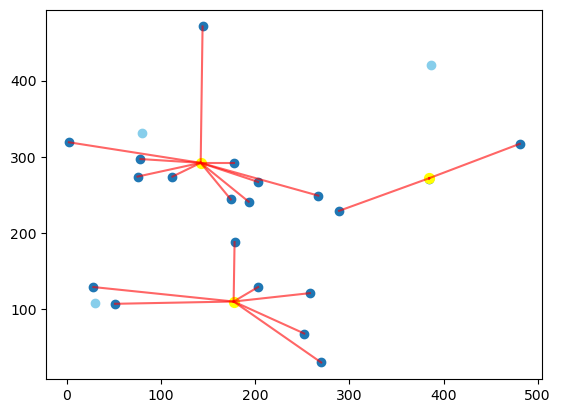

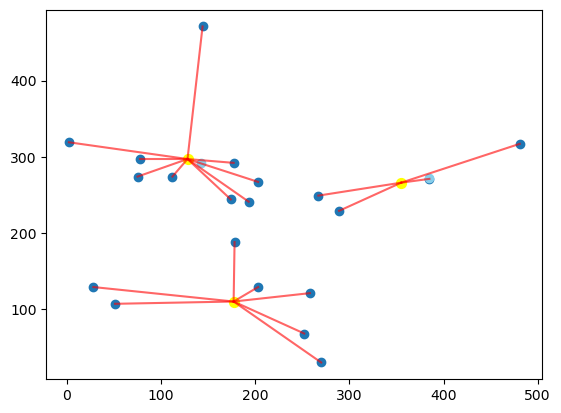

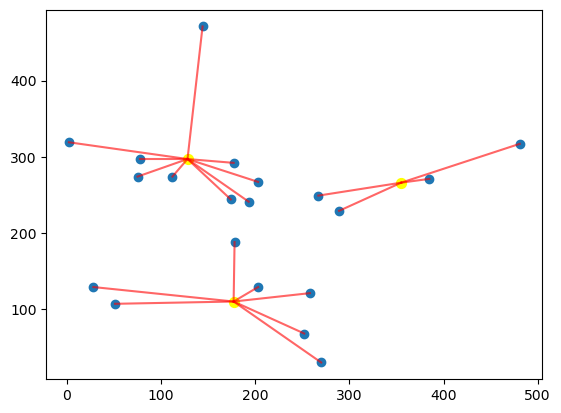

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# 群集中心和元素的數量
seed_num = 3
dot_num = 20

# 初始元素
x = np.random.randint(0, 500, dot_num)
y = np.random.randint(0, 500, dot_num)
# 初始群集中心
kx = np.random.randint(0, 500, seed_num)
ky = np.random.randint(0, 500, seed_num)


# 兩點之間的距離
def dis(x, y, kx, ky):
    return int(((kx-x)**2 + (ky-y)**2)**0.5)

# 對每筆元素進行分群
def cluster(x, y, kx, ky):
    team = []
    for i in range(3):
        team.append([])
    mid_dis = 99999999
    for i in range(dot_num):
        for j in range(seed_num):
            distant = dis(x[i], y[i], kx[j], ky[j])
            if distant < mid_dis:
                mid_dis = distant
                flag = j
        team[flag].append([x[i], y[i]])
        mid_dis = 99999999
    return team

# 對分群完的元素找出新的群集中心
def re_seed(team, kx, ky):
    sumx = 0
    sumy = 0
    new_seed = []
    for index, nodes in enumerate(team):
        if nodes == []:
            new_seed.append([kx[index], ky[index]])
        for node in nodes:
            sumx += node[0]
            sumy += node[1]
        new_seed.append([int(sumx/len(nodes)), int(sumy/len(nodes))])
        sumx = 0
        sumy = 0
    nkx = []
    nky = []
    for i in new_seed:
        nkx.append(i[0])
        nky.append(i[1])
    return nkx, nky

# k-means 分群
def kmeans(x, y, kx, ky, fig):
    team = cluster(x, y, kx, ky)
    nkx, nky = re_seed(team, kx, ky)
    
    # plot: nodes connect to seeds
    cx = []
    cy = []
    line = plt.gca()
    for index, nodes in enumerate(team):
        for node in nodes:
            cx.append([node[0], nkx[index]])
            cy.append([node[1], nky[index]])
        for i in range(len(cx)):
            line.plot(cx[i], cy[i], color='r', alpha=0.6)
        cx = []
        cy = []
    
    # 繪圖
    feature = plt.scatter(x, y)
    k_feature = plt.scatter(kx, ky , color = 'skyblue')
    nk_feaure = plt.scatter(np.array(nkx), np.array(nky), color = 'yellow',s=50)
    plt.savefig('../others/kmeans_%s.png' % fig)
    plt.show()

    # 判斷群集中心是否不再更動
    if nkx == list(kx) and nky == (ky):
        return
    else:
        fig += 1
        kmeans(x, y, nkx, nky, fig)


kmeans(x, y, kx, ky, fig=0)


In [6]:
import torch
# 把kmeans_flat的輸入改為OrderedDict()，再逐層轉成view(-1)後分群聚合
from collections import defaultdict,OrderedDict
X=[]
num_clients = 30
num_cluster = 3
for i in range(num_clients):
    w = OrderedDict([
        # ('conv1.weight', torch.randn(32, 1, 5, 5)),
        # ('conv1.bias', torch.randn(32)),
        # ('conv2.weight', torch.randn(64, 32, 5, 5)),
        # ('conv2.bias', torch.randn(64)),
        # ('fc1.weight', torch.randn(512, 3136)),
        # ('fc1.bias', torch.randn(512)),
        # ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(3))
    ])
    X.append(w)

        
def kmeans_flat(w, K , max_iterations):
    w_ls = []
    for client_weights in w:
        w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)
    X = torch.stack(w_ls)
    num_samples = X.size(0)
    num_features = X.size(1)
    # pca.inverse_transform(X_pca)
    # 隨機初始化群集中心
    centers = X[torch.randperm(num_samples)[:K]]
    for i in range(max_iterations):
        # 計算每個樣本到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centers) ** 2, dim=2))
        print('distances:',distances)
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        # 更新群集中心
        new_centers = torch.stack([X[labels == k].mean(dim=0) for k in range(K)])
        # 檢查是否收斂
        if torch.all(torch.eq(centers, new_centers)):
            break
        
        centers = new_centers
        print('centers:',centers)

    
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in enumerate(labels.tolist())]
    
    center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any()])
    
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    centers_ls = []
    for i in range(center_revise.size(0)):
        start_idx=0
        centers_od = OrderedDict()
        for k,s in zip(layer_name,layer_size):
            numel = s.numel()
            centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s)
            start_idx += numel
        centers_ls.append(centers_od)
    return centers_ls , labels , membership

centers , labels , membership = kmeans_flat(X, num_cluster , 10)
print(membership)
print(labels)
# lw = torch.cat([l.view(-1) for l in X[0].values()])
# center = torch.cat([l.view(-1) for l in centers[labels[0]].values()])
# print(torch.norm(lw - center))

distances: tensor([[2.3082, 3.7943, 1.0388],
        [3.0097, 2.1112, 2.4257],
        [2.9222, 3.6504, 2.0175],
        [2.8924, 1.8983, 1.3895],
        [1.9725, 2.0888, 0.9681],
        [4.1868, 1.6121, 2.8257],
        [3.8907, 0.0000, 2.9409],
        [0.5728, 3.4091, 1.4199],
        [1.7401, 2.9409, 0.0000],
        [1.7687, 2.2850, 1.8536],
        [2.4308, 2.5152, 2.4881],
        [0.8629, 3.0628, 1.4158],
        [3.7909, 0.8588, 2.9481],
        [2.4729, 1.7732, 2.2917],
        [3.6267, 0.8462, 2.4489],
        [1.2925, 3.8755, 1.0018],
        [2.5864, 1.3630, 1.8786],
        [3.6703, 2.1220, 3.6928],
        [0.0000, 3.8907, 1.7401],
        [1.5978, 2.9640, 2.2339],
        [2.1527, 2.3352, 2.1823],
        [2.3131, 3.7557, 1.0142],
        [1.6184, 2.5652, 1.9284],
        [1.2870, 3.0409, 1.2752],
        [2.2626, 3.8846, 3.1611],
        [1.9737, 1.9481, 1.6118],
        [3.4073, 2.9081, 3.8549],
        [2.3242, 2.4536, 0.6741],
        [2.6886, 2.4837, 2.7632],
   

In [59]:
import torch
import torch.nn as nn

# 假設有三個類別和一個樣本
log_probs = torch.tensor([[1.0,0,0]])  # 對數概率預測
labels = torch.tensor([0])  # 真實標籤

criterion = nn.NLLLoss()  # 建立負對數似然損失函數
loss = criterion(log_probs, labels)  # 計算損失
torch.log(x)
print(loss.item())  # 輸出損失值

-1.0


In [48]:
import torch

x = torch.tensor(2.0)  # 常數
log_x = torch.log(x)   # 對常數取對數
print(log_x.item())

0.6931471824645996


In [11]:
import torch
from collections import defaultdict, OrderedDict
from sklearn.decomposition import PCA

X = []
num_clients = 100
num_cluster = 3

for i in range(num_clients):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    X.append(w)

def flat_pca(w, K, max_iterations):
    w_ls = []
    for client_weights in w:
        w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)
    
    X = torch.stack(w_ls)
    n_components = 50  # Set your desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # X_pca = torch.from_numpy(X_pca)
    
    # Perform k-means clustering on the PCA-transformed data
    # ... (rest of your k-means clustering code)

    # Reconstruction of compressed parameters using inverse_transform
    X_reconstructed = pca.inverse_transform(X_pca)
    print('X_reconstructed:',X_reconstructed)
    X_reconstructed = torch.from_numpy(X_reconstructed)
    print('X_reconstructed.size()',X_reconstructed.size())
    X_test = X_reconstructed[0]
    print('X_test.size()',X_test.size())
    layer_name = w[0].keys()
    layer_size = [v.size() for v in w[0].values()]
    # Update model parameters with the reconstructed parameters
    start_idx=0
    w_od = OrderedDict()
    for k,s in zip(layer_name,layer_size):
        # client_weights[k] = torch.zeros_like(client_weights[k])
        numel = s.numel()
        w_od[k] = X_test[start_idx:start_idx + numel].view(s)
        start_idx += numel
    
    return w_od

client_weights = flat_pca(X, num_cluster, 10)

X_reconstructed: [[-0.60853169  0.20959935 -0.1295839  ...  0.12694749  0.16749145
   0.04768228]
 [-0.80965586  0.61603607 -0.55900816 ... -0.42232018  0.19834045
  -0.03116071]
 [-1.14049928  0.3907201  -0.15268744 ... -0.68083575 -0.24493861
  -0.88276197]
 ...
 [ 0.34058912  0.14547986 -0.80793974 ...  0.58288343  0.5691444
  -0.03248376]
 [-0.59373839  0.80491492 -0.84860807 ... -0.85600114  0.34247529
  -0.08768346]
 [-1.0728728  -0.99756026  0.23396456 ... -0.73324215 -0.67279802
   1.1412399 ]]
X_reconstructed.size() torch.Size([100, 1663370])
X_test.size() torch.Size([1663370])


In [34]:
from collections import OrderedDict
import torch
w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
print(w['fc2.bias'])
a = torch.cat([l.view(-1) for l in w.values()])
a_scal =  torch.cat([l.view(-1) for l in w.values()])  * (0.5)
print(a[-10:])
print(a_scal[-10:])

tensor([-0.7536,  0.6012,  1.6182, -0.8705,  0.3974,  0.5961,  0.4064, -0.8298,
        -0.8290,  0.5731])
tensor([-0.7536,  0.6012,  1.6182, -0.8705,  0.3974,  0.5961,  0.4064, -0.8298,
        -0.8290,  0.5731])
tensor([-0.3768,  0.3006,  0.8091, -0.4353,  0.1987,  0.2981,  0.2032, -0.4149,
        -0.4145,  0.2866])


In [32]:
import torch
import copy
from collections import defaultdict, OrderedDict
X = []
num_clients = 5
n=[600,600,600,600,600]
ndata = sum(n)
for i in range(num_clients):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    X.append(w)


org_w_avg = copy.deepcopy(X[0])
for key in org_w_avg.keys():
    # print('{}.shape: {}'.format(key,w_avg[key].size()))
    for i in range(1, len(X)):
        org_w_avg[key] += X[i][key]
    if key == 'fc2.bias':
        print('before div:',org_w_avg[key])
    org_w_avg[key] = torch.div(org_w_avg[key], len(X))
    if key == 'fc2.bias':
        print('after div:',org_w_avg[key])

w_avg = OrderedDict()
print('keys:',copy.deepcopy(X[0]).keys())
for key in copy.deepcopy(X[0]).keys():
    w_avg[key] = X[0][key]*n[0]
    for i in range(1,len(X)):
        w_avg[key] += X[i][key]*n[i]
    w_avg[key] = torch.div(w_avg[key],ndata)
    if key == 'fc2.bias':
        print(f'w_avg[{key}]:',w_avg[key])

        
# print(w_avg['conv1.weight'].size())

before div: tensor([-1.4797, -2.0230, -0.7546, -2.5338, -5.8837, -3.6349,  2.4408,  0.4814,
         0.1019,  0.4684])
after div: tensor([-0.2959, -0.4046, -0.1509, -0.5068, -1.1767, -0.7270,  0.4882,  0.0963,
         0.0204,  0.0937])
keys: odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
w_avg[fc2.bias]: tensor([-0.2959, -0.4046, -0.1509, -0.5068, -1.1767, -0.7270,  0.4882,  0.0963,
         0.0204,  0.0937])


In [13]:
import numpy as np
a = [2,6,3,4,1,9,10]
a = np.array(a)
b = np.random.choice(a, 2, replace=False)
print(b)

[3 1]


In [53]:
from sklearn.decomposition import PCA
import torch
# 把kmeans_flat的輸入改為OrderedDict()，再逐層轉成view(-1)後分群聚合
from collections import defaultdict,OrderedDict
X=[]
num_clients = 100
num_cluster = 3
for i in range(num_clients):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    X.append(w)

        
def kmeans_flat_pca(w, K , max_iterations):
    w_ls = []
    for client_weights in w:
        w_flat = torch.cat([l.view(-1) for l in client_weights.values()])
        w_ls.append(w_flat)
    X = torch.stack(w_ls)
    print(X.size())
    n_components = 50  # Set your desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca = torch.from_numpy(X_pca)
    num_samples = X_pca.size(0)
    num_features = X_pca.size(1)
    
    # 隨機初始化群集中心
    centers = X_pca[torch.randperm(num_samples)[:K]]
    for i in range(max_iterations):
        # 計算每個樣本到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X_pca[:, None] - centers) ** 2, dim=2))
        
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        # 更新群集中心
        new_centers = torch.stack([X_pca[labels == k].mean(dim=0) for k in range(K)])
        # 檢查是否收斂
        if torch.all(torch.eq(centers, new_centers)):
            break
        
        centers = new_centers
    
    membership = defaultdict(list)
    [membership[label].append(idx) for idx, label in enumerate(labels.tolist())]
    
    center_revise = torch.stack([cw for cw in centers if not torch.isnan(cw).any()])
    
    # layer_name = w[0].keys()
    # layer_size = [v.size() for v in w[0].values()]
    # centers_ls = []
    # for i in range(center_revise.size(0)):
    #     start_idx=0
    #     centers_od = OrderedDict()
    #     for k,s in zip(layer_name,layer_size):
    #         numel = s.numel()
    #         centers_od[k] = center_revise[i][start_idx:start_idx + numel].view(s)
    #         start_idx += numel
    #     centers_ls.append(centers_od)
    # return centers_ls , labels , membership
    return center_revise , labels , membership
    
centers , labels , membership = kmeans_flat_pca(X, num_cluster , 10)
# print(membership)


torch.Size([100, 1663370])


In [54]:
print("centers:",centers)
print('labels:',labels)
print('membershipL',membership)

centers: tensor([[  -4.0039,   17.4813,    3.4504,   -6.1400,    1.8412,   -4.0207,
           10.4600,   11.9856,    6.4282,  -25.2003,    4.7182,   23.6863,
          -15.9461,    8.4527,   -1.7374,   -1.6839,   -3.9015,  -20.0579,
          -21.8146,    1.0884,   10.0970,   -3.4661,    2.0807,    6.3507,
           23.1897,  -13.1234,   -7.8155,  -17.4567,    2.6760,   16.5930,
           -2.2323,   21.4430,   17.2423,   21.3523,   -6.5579,    1.8217,
            5.1229,  -12.2236,    6.9625,   19.9776,   -3.7345,   -4.1809,
            6.8514,    2.5196,    3.1533,   18.3356,    1.6614,  -10.2055,
           18.0895,  -15.6332],
        [   9.7813,  -31.5869,   -9.4579,   12.3703,    4.4537,    5.7869,
          -16.0729,  -22.2291,    2.0873,   47.0263,   -9.5284,  -30.1654,
           21.6283,   -7.7973,   -2.6958,   -2.5523,   13.9290,   34.5112,
           17.2971,   -3.6890,  -17.1755,    7.4910,  -15.4218,   -3.0317,
          -51.5896,   26.6711,   11.8028,   20.3297,    4.3

In [42]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Create client weights data
X = []
num_clients = 100
num_features = 1663370  # Set your desired number of features

for i in range(num_clients):
    client_weights = torch.randn(num_features)
    X.append(client_weights)

X = torch.stack(X).numpy()

# Perform PCA on the client weights
n_components = 50  # Set your desired number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

num_samples = X_pca.shape[0]
print('num_samples:', num_samples)
print('num_components:', n_components)

num_samples: 100
num_components: 50


In [43]:
print(X_pca.shape)

(100, 50)


In [ ]:
def average_weights(w , n): #weighted by client's train dataset
    ndata = sum(n)
    for key in copy.deepcopy(w[0]).keys():
        w_avg[key] = w[0][key]*(n[0]/ndata)
        for i in range(1,len(w)):
            w_avg[key] = w[i][key]*(n[i]/ndata)
    return w_avg

In [28]:
def average_weights(w, n):
    w_avg = copy.deepcopy(w[0])
    total_samples = sum(n)
    for key in w_avg.keys():
        w_avg[key] = torch.zeros_like(w_avg[key])  # Initialize to zeros
        for i in range(len(w)):
            w_avg[key] += w[i][key] * (n[i] / total_samples)
    return w_avg

collections.OrderedDict

In [1]:
clients_weights = {}
for idx in [12,4,24,10,2,7,8,17]:
    clients_weights[idx] = idx+1
print(clients_weights)

{12: 13, 4: 5, 24: 25, 10: 11, 2: 3, 7: 8, 8: 9, 17: 18}


In [334]:
#v = [2 if 'fc' not in k and 'bias' not in k else 0 for k in X[0].keys()]
v = []
for i,k in enumerate(X[0].keys()):
    v.append(0)
    if 'fc' not in k and 'bias' not in k:
        v[i] += 2

0
1
2
3
4
5
6
7


In [318]:
print(X[0].keys())
[0]*len(X[0].keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


[0, 0, 0, 0, 0, 0, 0, 0]

In [283]:
a = OrderedDict([('conv1.weight', torch.randn(2,3)),('conv1.bias', torch.randn(5,2))])
a_keys= a.keys()
a_sizes = [v.size() for v in a.values()]
print(a_sizes)
print(a_keys)
a_flat = torch.cat([l.view(-1) for l in a.values()])

[torch.Size([2, 3]), torch.Size([5, 2])]
odict_keys(['conv1.weight', 'conv1.bias'])


In [295]:
a_restored = OrderedDict()
start_idx = 0
for k,s in zip(a_keys,a_sizes):
    numel = s.numel()
    print(numel)
    a_restored[k] = a_flat[start_idx:start_idx + numel].view(s)
    start_idx += numel
print(a_restored)

6
10
OrderedDict([('conv1.weight', tensor([[-1.0322,  0.6886,  0.1676],
        [-0.3035, -1.0279,  0.5144]])), ('conv1.bias', tensor([[ 2.6230,  0.0495],
        [ 1.0220, -1.1963],
        [ 0.0824,  0.0895],
        [ 0.0056,  0.3993],
        [ 1.4538,  0.5534]]))])


輸入資料如下：
labels: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
pred_labels: tensor([1, 2, 8, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
torch.eq(pred_labels, labels): tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True])
由於label 0出現一次，且預測正確，所以label 0準確度為1.0，而label 1出現2次，且預測正確，所以label 1準確度為1.0，而label 2出現2次，且預測正確，所以label 2準確度為1.0，但label 3出現2次，只有一次預測正確，所以label 3準確度為0.5，以此類推，可能的輸出如下，請撰寫可能的程式碼：
labels_correct = [[1.0],[1.0],[1.0],[0.5],...]

In [23]:
# 除了隨機生成center，也可以選擇現有的clients
import random
import torch
from collections import OrderedDict, defaultdict
X = []
# centers = []
num_clusters = 3
num_clients = 10


# for i in range(num_clusters):
    # w = OrderedDict([
    #     ('conv1.weight', torch.randn(32, 1, 5, 5)),
    #     ('conv1.bias', torch.randn(32)),
    #     ('conv2.weight', torch.randn(64, 32, 5, 5)),
    #     ('conv2.bias', torch.randn(64)),
    #     ('fc1.weight', torch.randn(512, 3136)),
    #     ('fc1.bias', torch.randn(512)),
    #     ('fc2.weight', torch.randn(10, 512)),
    #     ('fc2.bias', torch.randn(10))
    # ])
    # centers.append(w)
for i in range(num_clients):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    X.append(w)    

def kmeans(X, K, vote='weight' , max_iterations=100):
    num_clients = len(X)
    # 計算同一個cluster中的clients的model weights平均
    new_centers = OrderedDict()
    layers_labels = []
    centers = random.sample(X, K)
    layers_weights = [] 
    for layer_name in X[0].keys():
        clients_layer_weights = [client_weights[layer_name] for client_weights in X]
        centers_layer_weights = [center_weights[layer_name] for center_weights in centers]
        clients_lw = torch.stack(clients_layer_weights)
        centers_lw = torch.stack(centers_layer_weights)
        l_dim = tuple(range(1,len(list(clients_lw.size()))+1))[1:] # eg: (2,3,4,5) or (2,3,4) ...
        # 計算每個client的某layer到各群集中心的歐式距離
        for i in range(max_iterations):
            distances = torch.sqrt(torch.sum((clients_lw[:, None] - centers_lw) ** 2, dim=l_dim)) # 計算所有每個客戶端單個layer的weight和各個center對應layer的weight的歐式距離
            labels = torch.argmin(distances, dim=1) # 找到每個client"在此layer"的weight距離最近的center(cluster)
            layers_labels.append(labels.tolist()) #搜集每個client在此layer的weight所屬的cluster
            new_centers[layer_name] = torch.stack([clients_lw[labels == k].mean(dim=0) for k in range(K)]) # 計算各個cluster中的client"在此layer"的weight的平均
            # 上述算法是以"layer"為主，生成K個global model

            if torch.all(torch.eq(centers_lw, new_centers[layer_name])):
                break
            centers_lw = new_centers[layer_name]
        centers_split = [centers_lw[i] for i in range(centers_lw.size(0))]
        layers_weights.append(centers_split)
        if layer_name == list(X[0].keys())[-1]:
            print(layer_name,'\'s weights:',centers_split)
    # new_centers['conv1.weight'].size() = torch.Size([3, 32, 1, 5, 5]) 要轉成 centers_ls[0]['conv1.weight'].size() = torch.Size([32, 1, 5, 5])
    centers_ls = [] 
    for i in range(K):
        od = OrderedDict()
        for j,key in enumerate(X[0].keys()):
            od[key] = layers_weights[j][i]
        centers_ls.append(od)
    
    if len(centers_ls) == 1:
        weight_labels = [0]*num_clients
        weight_membership = defaultdict(list)
        weight_membership[0] = list(range(num_clients))
    else:
        # 可決定各layer的比重，判斷client統整個layer後，所屬的cluster
        if vote != 'eq': 
            v = [2 if 'fc' not in k and 'bias' not in k else 0 for k in X[0].keys()]
            for i in range(len(v)):
                for j in range(v[i]):
                    layers_labels.append(layers_labels[i])
        weight_labels = [max(client,key=client.count) for client in zip(*layers_labels)] #以"client"為主，將所選clients指派到K個cluster
        weight_membership = defaultdict(list)
        [weight_membership[label].append(idx) for idx, label in enumerate(weight_labels)]
    return centers_ls , weight_labels , weight_membership
    
    
centers , weight_labels , weight_membership = kmeans(X, 3, 'weight' , 100)
print('len(centers):',len(centers))
print('weight_labels:',weight_labels)
print('weight_membership:',weight_membership)

fc2.bias 's weights: [tensor([ 0.4977, -0.1628,  0.6665,  0.0406,  0.0630, -0.3617, -0.3766, -0.2730,
         0.2044,  0.7579]), tensor([-0.1284,  0.6789,  0.6016, -1.2429,  0.6175,  0.1046,  0.1810, -0.0226,
         0.4485, -0.2329]), tensor([ 0.5765, -1.3850, -1.2562, -2.0399, -0.3247,  1.3965, -1.5620,  0.1691,
        -0.2881,  0.3917])]
len(centers): 3
weight_labels: [0, 0, 0, 1, 2, 1, 1, 0, 0, 2]
weight_membership: defaultdict(<class 'list'>, {0: [0, 1, 2, 7, 8], 1: [3, 5, 6], 2: [4, 9]})


In [33]:
import torch
import numpy as np

# 創建包含 NaN 的張量
nan_tensor = torch.tensor([float('nan')] * 10)

# 判斷張量中是否包含 NaN 值
has_nan = torch.isnan(nan_tensor).any().item()

print("包含 NaN 的張量：", nan_tensor)
print("是否包含 NaN 值：", has_nan)

包含 NaN 的張量： tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
是否包含 NaN 值： True


In [38]:
lw = [[1,2,3],[4,5],[5]]
print(len(min(lw, key=len)))

1


In [2]:
import torch
global_model = torch.load(f'./save_model/global_model.pt',map_location='cpu')
gm_ls=[]
for i in range(3):
    gm_ls.append(global_model)
print(len(gm_ls))

3


In [3]:
gm_ls = [ global_model for i in range(3)]

'fc2.bias'

In [18]:
def aaa(a , *previous):
    print('a:',a)
    return previous

a=1
pv = 20
print(type(aaa(a,pv)))

a: 1
<class 'tuple'>


In [ ]:
for epoch in tqdm(range(args.epochs)):
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)

    for idx in idxs_users:
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                idxs=user_groups[idx], logger=logger)
        w, loss = local_model.update_weights(
            model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # update global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                idxs=user_groups[idx], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))

    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))

# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

In [ ]:
local_weights, local_losses = [], []
global_model.train()
m = max(int(args.frac * args.num_users), 1)
idxs_users = np.random.choice(range(args.num_users), m, replace=False)
for idx in idxs_users:
    local_model = LocalUpdate(args=args, dataset=train_dataset,
                            idxs=user_groups[idx], logger=logger)
    w, loss = local_model.update_weights(
        model=copy.deepcopy(global_model), global_round=epoch)
    local_weights.append(copy.deepcopy(w))
    local_losses.append(copy.deepcopy(loss))

local_weights, local_losses = [], []
print(f'\n | Global Training Round : {epoch+1} |\n')

global_model.train()
m = max(int(args.frac * args.num_users), 1)
idxs_users = np.random.choice(range(args.num_users), m, replace=False)

for idx in idxs_users:
    local_model = LocalUpdate(args=args, dataset=train_dataset,
                            idxs=user_groups[idx], logger=logger)
    w, loss = local_model.update_weights(
        model=global_model, global_round=epoch)
    local_weights.append(w)
    local_losses.append(loss)


In [91]:
print("center0['f2.bias']:",centers[0]['fc2.bias'].size())
print("center1['f2.bias']:",centers[0]['fc2.weight'].size())
print("center2['f2.bias']:",centers[1]['fc2.bias'])

center0['f2.bias']: torch.Size([10])
center1['f2.bias']: torch.Size([10, 512])
center2['f2.bias']: tensor([ 0.0984, -0.4722,  0.2293, -0.3330,  0.0145, -0.6001,  0.2659, -0.3583,
         0.4264,  0.4737])


In [86]:
w = torch.randn(3,3,2)
print(w.size())
print(w[0])
w_split = [w[i] for i in range(w.size(0))]
print(w_split[0])
# w_split = torch.chunk(w, chunks=3, dim=0)
# print(list(w_split))

torch.Size([3, 3, 2])
tensor([[ 0.1114, -0.5437],
        [-0.6096,  1.6205],
        [-0.5977,  0.9486]])
tensor([[ 0.1114, -0.5437],
        [-0.6096,  1.6205],
        [-0.5977,  0.9486]])


In [55]:
w1= [torch.randn(10, 5),torch.randn(10, 5),torch.randn(10, 5)]
print('w1[0]:',w1[0])
w2= [torch.randn(3,2),torch.randn(3,2),torch.randn(3,2)]
w = [w1,w2]
od_ls = []
for i in range(len(w1)):
    od = OrderedDict()
    for j,key in enumerate(['conv1.weight','conv1.bias']):
        od[key] = w[j][i]
    od_ls.append(od)
print(od_ls[0]['conv1.weight'])

w1[0]: tensor([[ 0.9042,  0.1628,  0.6921,  0.3572, -2.5304],
        [-1.2546,  0.4999, -0.0945, -0.6185, -0.5692],
        [ 1.1760, -1.0611, -0.0838,  1.1463, -0.0308],
        [ 0.4325, -1.2742, -0.1606,  0.0162, -0.2518],
        [ 0.6010, -0.0450, -0.2709,  0.2554, -1.2559],
        [ 0.2189, -0.8680, -0.9349,  0.8943, -0.7807],
        [ 0.2058,  1.2675, -0.0233, -0.2260, -0.1826],
        [ 1.5642,  1.6832,  0.8852, -3.5262, -0.2670],
        [-1.0884,  0.6191,  1.1797, -0.0884,  0.3670],
        [ 1.7372,  0.0471, -0.4384,  0.0666,  0.1855]])
tensor([[ 0.9042,  0.1628,  0.6921,  0.3572, -2.5304],
        [-1.2546,  0.4999, -0.0945, -0.6185, -0.5692],
        [ 1.1760, -1.0611, -0.0838,  1.1463, -0.0308],
        [ 0.4325, -1.2742, -0.1606,  0.0162, -0.2518],
        [ 0.6010, -0.0450, -0.2709,  0.2554, -1.2559],
        [ 0.2189, -0.8680, -0.9349,  0.8943, -0.7807],
        [ 0.2058,  1.2675, -0.0233, -0.2260, -0.1826],
        [ 1.5642,  1.6832,  0.8852, -3.5262, -0.2670],
  

In [1]:
import numpy as np
from torchvision import datasets, transforms
data_dir = '../data/mnist/'
apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.MNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)
num_shards, num_imgs , num_users= 200, 300 , 100
idx_shard = [i for i in range(num_shards)]
dict_users = {i: np.array([]) for i in range(num_users)}
users_label = {i: np.array([]) for i in range(num_users)}
idxs = np.arange(num_shards*num_imgs)
labels = dataset.targets.numpy()

In [2]:
# sort labels
idxs_labels = np.vstack((idxs, labels))
idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
idxs = idxs_labels[0, :]
id_labels = idxs_labels[1, :]

In [ ]:
list(np.where(np.isin(labels, np.array(list(users_label[0]))))[0])

In [17]:
lw = [9,8,7,6,5,4,3,2,1]
selected_users = [2,4,6,8,10,12,14,16,18]
print(list(selected_users).index(2))
print(selected_users.index(2))
lw[list(selected_users).index(2)]

0
0


9

In [18]:
from collections import Counter
# divide and assign 2 shards/client
for i in range(num_users):
    rand_set = set(np.random.choice(idx_shard, 2, replace=False))
    idx_shard = list(set(idx_shard) - rand_set)
    label_ls = np.array([])
    for rand in rand_set:
        label_ls = np.concatenate([label_ls, id_labels[rand*num_imgs:(rand+1)*num_imgs]],axis=0)
        dict_users[i] = np.concatenate(
            (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    # 使用 Counter 計算元素的出現次數
    label_count = Counter(label_ls.tolist())
    # 將 Counter 轉換為字典格式
    label_count_dict = {int(label): count for label, count in label_count.items() if count / label_ls.shape[0] >= 0.1}
    users_label[i] =  set(label_count_dict.keys())

In [22]:
(dict_users[96])

int

In [110]:
import numpy as np

i_arr = np.array([5, 1, 4, 2, 3])
j_arr = np.array([1, 3])
k_arr = np.array([6, 7, 8, 9, 10])

# 找出 j_arr 中的元素在 i_arr 中對應的索引
index_ls = np.where(np.isin(i_arr, j_arr))[0]

# 根據 index_ls 找出在 k_arr 中相對應的元素
result = list(k_arr[index_ls])
print(index_ls)
print(result)

[1 4]
[7, 10]


In [9]:
selected_user = list(np.array([5, 2, 8, 11, 1])) #[5,2,8,11,1]
target_user = 2
selected_user.index(target_user)

1

In [15]:
import numpy as np
users_acc =  {11: 0.99 , 4: 0.97 , 3: 0.985 , 6: 0.95}
np.mean(list(users_acc.values()))

0.9737499999999999

In [8]:
import numpy as np

selected_user = np.array([5, 2, 8, 11, 1])
target_user = 2

target_idx = np.where(selected_user == target_user)[0][0]
print(target_idx)

1


In [4]:
d = {0: 'aaa' , 1: 'bbbb'}
if 2 in d:
    print(d[2])
else:
    print('d[2] not exist')

d[2] not exist


In [337]:
# 要設args.lam 範例程式無法執行
selected_users= [ 2,17 ,42,15 ,11 , 13,21 ,7 ,8 ,23]
for i,idx in enumerate(selected_users):
    local_model = LocalUpdate(args=args, dataset=train_dataset,
        idxs=user_groups[idx], logger=logger)
    w, loss = local_model.update_weights(  # add kmeans cluster with local model weight(layers & dimensions)
        model=copy.deepcopy(global_model_ls[i]), global_round=epoch)
    w = OrderedDict({key: w[key]*0.5*(2-lam) + centers[labels[i]][key]*0.5*lam for key in w.keys()})
    local_weights.append(copy.deepcopy(w))
    local_losses.append(copy.deepcopy(loss))

centers , labels , membership = kmeans(local_weights, args.num_clusters, args.k_vote , args.max_iters)

for cluster in range(args.num_clusters):
    global_weights = centers[cluster]
    global_model.load_state_dict(global_weights)
    

In [336]:
weight_labels

[2, 0, 1, 1, 1, 2, 0, 1, 1, 0]

In [344]:
a = OrderedDict([('conv1.weight',torch.randn(3,2)),('conv1.bias', torch.randn(2,3))])
b = OrderedDict([('conv1.weight',torch.randn(3,2)),('conv1.bias', torch.randn(2,3))])
print(a)
print(b)
lam = 0.8
result = OrderedDict({key: a[key]*0.5*(2-lam) + b[key]*0.5*lam for key in a.keys()})
print(result)
# [OrderedDict([('conv1.weight',torch.randn(2,3)),('conv1.bias', torch.randn(3))]),OrderedDict([('conv1.weight',torch.randn(2,3)),('conv1.bias', torch.randn(3))]),OrderedDict([('conv1.weight',torch.randn(2,3)),('conv1.bias', torch.randn(3))])]

OrderedDict([('conv1.weight', tensor([[ 1.0352, -0.4387],
        [-1.1944, -1.0568],
        [ 1.3865,  0.3966]])), ('conv1.bias', tensor([[-0.9582,  0.1427,  0.1184],
        [ 0.8594,  1.1362, -0.3680]]))])
OrderedDict([('conv1.weight', tensor([[ 1.4136,  0.7666],
        [-0.8328, -2.3570],
        [ 0.5022,  0.8072]])), ('conv1.bias', tensor([[-0.6319,  0.3864,  0.2151],
        [-0.6682, -1.9225,  0.5955]]))])
OrderedDict([('conv1.weight', tensor([[ 1.1866,  0.0434],
        [-1.0498, -1.5769],
        [ 1.0328,  0.5609]])), ('conv1.bias', tensor([[-0.8277,  0.2402,  0.1571],
        [ 0.2483, -0.0873,  0.0174]]))])


In [240]:
K=3
c_od = [OrderedDict()]*K
for i in range(K):
    c_od[i]['key']= torch.randn(32)
print(c_od[2]['key'].size())

torch.Size([32])


In [ ]:
K=3
centers_ls = [OrderedDict()]*K
for key,value in centers.items():
    for i,w in enumerate(value):
        centers_ls[i][key]= w

In [260]:
for kk in centers.keys():
    print(kk,'.size = ',centers_ls[0][kk].size())


conv1.weight .size =  torch.Size([32, 1, 5, 5])
conv1.bias .size =  torch.Size([32])
conv2.weight .size =  torch.Size([64, 32, 5, 5])
conv2.bias .size =  torch.Size([64])
fc1.weight .size =  torch.Size([512, 3136])
fc1.bias .size =  torch.Size([512])
fc2.weight .size =  torch.Size([10, 512])
fc2.bias .size =  torch.Size([10])


In [184]:
vote ='weight'
if vote != 'eq': 
    v = [2, 0, 2, 0, 0, 0, 0, 0]
    for i in range(len(v)):
        for j in range(v[i]):
            layers_labels.append(layers_labels[i])
weight_labels = [max(client,key=client.count) for client in zip(*layers_labels)]
print(weight_labels)
weight_membership = defaultdict(list)
[weight_membership[label].append(idx) for idx, label in enumerate(weight_labels)]
print(dict(weight_membership))

[2, 2, 1, 0, 2, 2, 1, 2, 0, 0]
{2: [0, 1, 4, 5, 7], 1: [2, 6], 0: [3, 8, 9]}


In [119]:
from collections import defaultdict
num_clusters = 3
num_clients = 10

network_weights_list = torch.randn(num_clients, 32, 1, 5, 5,6)  # 範例資料
reference_weights_list = torch.randn(num_clusters, 32, 1, 5, 5,6)  # 範例資料
dim = tuple(range(1,len(list(network_weights_list.size()))+1))[1:]
# 將 network_weights_list 和 reference_weights_list 展開為二為tensor
# network_weights_flat = network_weights_list.view(-1, 32, 1, 5, 5)
# print(network_weights_flat.size())
# reference_weights_flat = reference_weights_list.view(-1, 32, 1, 5, 5)

# 計算距離矩陣
print(network_weights_list.size())
print(reference_weights_list.size())
distances = torch.sqrt(torch.sum((network_weights_list[:, None] - reference_weights_list) ** 2, dim=dim))
# print(distances)
labels = torch.argmin(distances, dim=1)
new_centers = torch.stack([network_weights_list[labels == k].mean(dim=0) for k in range(num_clusters)])

membership = defaultdict(list)
[membership[label].append(idx) for idx, label in enumerate(labels.tolist())]
print(membership)


torch.Size([10, 32, 1, 5, 5, 6])
torch.Size([3, 32, 1, 5, 5, 6])
defaultdict(<class 'list'>, {2: [0, 3, 8], 0: [1, 2, 7], 1: [4, 5, 6, 9]})


In [80]:
for label,clients in indices.items():
    print(clients)
    for c in clients:
        network_weights_list[c]

[0, 1, 2, 3, 6, 8]
[4, 7]
[5, 9]


In [117]:
### important 打平各layer分群後，確認某cluster有哪些client再把client的model各層avg_weights，作為new global model
import torch
from collections import OrderedDict

def kmeans(X, num_clusters, max_iterations=100):
    num_samples = X.size(0)
    num_features = X.size(1)
    
    # 隨機初始化群集中心
    centroids = X[torch.randperm(num_samples)[:num_clusters]]
    for i in range(max_iterations):
        # 計算每個樣本到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centroids) ** 2, dim=2))
        
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        
        # 更新群集中心
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(num_clusters)])
        
        # 檢查是否收斂
        if torch.all(torch.eq(centroids, new_centroids)):
            print('epoch:',i)
            break
        
        centroids = new_centroids
    
    return labels, centroids

# 創建 w_ls 列表
w_ls = []
for i in range(10):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    w_flat = torch.cat([l.view(-1) for l in w.values()])
    w_ls.append(w_flat)

# 將 w_ls 轉換成張量
X = torch.stack(w_ls)

# 聚类
num_clusters = 3
labels, centroids = kmeans(X, num_clusters)

print("Cluster Labels:", labels)
print("Centroids:", centroids)


num_samples: 10
epoch: 1
Cluster Labels: tensor([1, 1, 0, 1, 2, 2, 0, 2, 1, 1])
Centroids: tensor([[ 8.2460e-04,  6.2266e-01, -7.4333e-01,  ..., -1.4818e+00,
         -5.0106e-02, -6.1196e-01],
        [ 2.4458e-01, -2.3825e-01, -2.0295e-01,  ...,  2.8924e-01,
         -1.1405e-01, -8.3564e-01],
        [ 3.9220e-01,  2.8333e-01, -6.0195e-02,  ..., -4.1220e-01,
         -4.9758e-01,  8.0829e-02]])


In [139]:
s = [63,11,15,80,95,48,99,64 ,5,27,51,39,16,43,73,88,92,78,55,33]
c = [0,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,1,0,1,1]
dict(zip(s, c))

{63: 0,
 11: 1,
 15: 1,
 80: 1,
 95: 0,
 48: 0,
 99: 1,
 64: 1,
 5: 0,
 27: 1,
 51: 0,
 39: 1,
 16: 1,
 43: 0,
 73: 1,
 88: 0,
 92: 1,
 78: 0,
 55: 1,
 33: 1}

In [113]:
w_ls = []
for i in range(10):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('conv2.weight', torch.randn(64, 32, 5, 5)),
        ('conv2.bias', torch.randn(64)),
        ('fc1.weight', torch.randn(512, 3136)),
        ('fc1.bias', torch.randn(512)),
        ('fc2.weight', torch.randn(10, 512)),
        ('fc2.bias', torch.randn(10))
    ])
    w_flat = torch.cat([l.view(-1) for l in w.values()])
    w_ls.append(w_flat)
w_ls[0].size()

torch.Size([1663370])

In [111]:
w_ls = []
for i in range(1):
    w = OrderedDict([
        ('conv1.weight', torch.randn(32, 1, 5, 5)),
        ('conv1.bias', torch.randn(32)),
        ('fc1.weight', torch.randn(10, 6272)),
        ('fc1.bias', torch.randn(10)),
    ])
    for l in w.values():
        print(l)
        print('view:',l.view(-1))
#     w_flat = torch.cat([l.view(-1) for l in w.values()])
#     w_ls.append(w_flat)

# # 將 w_ls 轉換成張量
# X = torch.stack(w_ls)


tensor([[[[-0.4606,  2.3660, -0.7099,  0.6999, -0.9202],
          [ 1.1535, -1.2861, -0.0267,  0.0611,  0.6047],
          [-0.8528, -3.2970, -1.5987,  1.8320, -1.2759],
          [-0.8382, -1.6471,  0.3558, -1.4126,  0.1293],
          [ 0.0649,  1.1171, -0.2725,  0.0477, -0.6777]]],


        [[[ 0.7212, -0.1185, -1.4998,  0.1161, -0.5035],
          [ 0.6376, -0.4704, -0.8770,  0.3769, -1.0272],
          [-0.8122,  0.3351,  1.7355, -1.0683, -1.3690],
          [ 2.2899, -0.8504, -0.5923,  0.3720,  0.0095],
          [ 0.6432,  0.3366, -0.3833, -0.1243,  0.7911]]],


        [[[-0.9446,  1.6223, -0.5363,  0.6772,  0.5268],
          [-0.1440, -3.1503, -0.0527, -1.1162,  0.9284],
          [-1.0511,  1.0410, -0.0432,  0.6992,  2.3342],
          [-0.0586, -0.3167,  0.2830,  0.2440, -0.6195],
          [ 0.4020, -0.6903, -0.7554, -0.7307,  0.7115]]],


        [[[-0.8852,  0.7743, -1.2024,  0.3699, -0.1038],
          [ 0.1881, -1.1917,  1.0342,  0.6700, -0.9712],
          [ 0.4532,

In [84]:
import torch

def kmeans(X, num_clusters, max_iterations=100):
    num_samples = X.size(0)
    
    # 隨機初始化群集中心
    centroids = X[torch.randperm(num_samples)[:num_clusters]]
    
    for i in range(max_iterations):
        # 計算每個樣本到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centroids) ** 2, dim=2))
        
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        
        # 更新群集中心
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(num_clusters)])
        
        # 檢查是否收斂
        if torch.all(torch.eq(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return labels, centroids

# 輸入資料 X，每行表示一個資料點，特徵數量為 2（與 distances 的列數相同）
X = torch.tensor([[x1, x2] for x1, x2 in zip([-5.0,1.0,9.0, 4.0, 7.0], [-5.0,2.0, 9.0, 5.0, 8.0])])

# 聚類數量
num_clusters = 3

# 執行 KMeans 聚類
labels, centroids = kmeans(X, num_clusters)

# 輸出結果
print("Cluster Labels:", labels)
print("Centroids:", centroids)


Cluster Labels: tensor([2, 1, 0, 0, 0])
Centroids: tensor([[ 6.6667,  7.3333],
        [ 1.0000,  2.0000],
        [-5.0000, -5.0000]])


In [93]:
import torch
from collections import OrderedDict

def kmeans(X, num_clusters, max_iterations=100):
    num_samples = X.size(0)
    num_features = X.size(1)
    
    # 隨機初始化群集中心
    centroids = X[torch.randperm(num_samples)[:num_clusters]]
    
    for i in range(max_iterations):
        # 計算每個樣本到各群集中心的歐式距離
        distances = torch.sqrt(torch.sum((X[:, None] - centroids) ** 2, dim=2))
        
        # 找到最近的群集中心
        labels = torch.argmin(distances, dim=1)
        
        # 更新群集中心
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(num_clusters)])
        
        # 檢查是否收斂
        if torch.all(torch.eq(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return labels, centroids

# 示例数据
conv1_weight = torch.tensor([[[[ 9.1921e-02,  8.9624e-02, -3.3047e-02, -6.2400e-02,  1.1776e-01],
          [-3.0729e-02, -1.7365e-01,  1.9672e-01, -7.4977e-03,  1.2744e-02],
          [ 8.5042e-02, -1.9035e-01, -2.3279e-03, -1.1545e-01, -1.1518e-01],
          [-1.0608e-02,  1.7343e-01, -1.1577e-01,  1.0968e-01, -1.5720e-01],
          [-1.8657e-01, -1.8082e-01, -1.3856e-01, -1.8207e-01,  1.6689e-01]]],
        [[[ 7.0148e-02, -3.7595e-02,  1.0203e-01,  1.2754e-01, -2.5074e-02],
          [ 2.7140e-02, -5.0784e-02, -1.9058e-01, -1.2097e-01, -1.6356e-01],
          [-2.0072e-01,  4.1080e-02, -4.4056e-02, -2.0058e-01, -4.2128e-02],
          [-8.1411e-02, -9.8991e-03, -1.3560e-02, -1.4079e-01, -3.7912e-02],
          [-5.1216e-02, -1.8679e-01,  3.3662e-02,  1.6669e-03, -1.5696e-01]]]])

conv2_weight = torch.tensor([[[[ 2.5646e-02, -3.0884e-02, -5.8886e-03,  1.0928e-02,  7.5196e-03],
          [-1.1335e-02,  1.3693e-02, -1.9997e-03,  1.4366e-02, -3.9529e-02],
          [ 1.5920e-02, -6.5620e-03, -2.2541e-02, -6.6601e-03,  3.4653e-03],
          [-1.1731e-02, -1.8512e-03,  3.5148e-02, -7.8949e-03, -3.0446e-02],
          [ 2.3462e-02,  3.2421e-02,  1.5013e-02,  8.4391e-04, -2.8007e-02]]],
        [[[ 2.5242e-02, -4.5554e-03, -2.5291e-02,  1.4826e-02, -2.8415e-02],
          [-1.3998e-02,  7.0376e-03,  4.3196e-03, -3.2188e-02,  1.9564e-02],
          [-2.9035e-02, -2.4360e-02, -3.5468e-03, -2.7957e-02, -1.7319e-02],
          [-3.9566e-05, -6.6674e-03,  2.0996e-02,  2.3687e-02, -1.0714e-02],
          [-6.3214e-03, -3.2282e-02, -1.2126e-02,  3.2472e-02, -3.5154e-02]]]])

# 將權重張量展平為一維
conv1_weight_flat = conv1_weight.view(conv1_weight.size(0), -1)
conv2_weight_flat = conv2_weight.view(conv2_weight.size(0), -1)

# 將展平的權重張量組合成一個輸入資料張量
X = torch.cat([conv1_weight_flat, conv2_weight_flat])

# 聚类
num_clusters = 2
labels, centroids = kmeans(X, num_clusters)

print("Cluster Labels:", labels)
print("Centroids:", centroids)


Cluster Labels: tensor([0, 1, 1, 1])
Centroids: tensor([[ 0.0919,  0.0896, -0.0330, -0.0624,  0.1178, -0.0307, -0.1736,  0.1967,
         -0.0075,  0.0127,  0.0850, -0.1903, -0.0023, -0.1155, -0.1152, -0.0106,
          0.1734, -0.1158,  0.1097, -0.1572, -0.1866, -0.1808, -0.1386, -0.1821,
          0.1669],
        [ 0.0403, -0.0243,  0.0236,  0.0511, -0.0153,  0.0006, -0.0100, -0.0628,
         -0.0463, -0.0612, -0.0713,  0.0034, -0.0234, -0.0784, -0.0187, -0.0311,
         -0.0061,  0.0142, -0.0417, -0.0264, -0.0114, -0.0622,  0.0122,  0.0117,
         -0.0734]])


In [1]:
import numpy as np
m=2
num_users=10
client_ids = list(range(num_users))
for round in range(10):
    print('round:',round+1)
    print('select client id:',np.random.choice(client_ids, m, replace=False))

round: 1
select client id: [2 0]
round: 2
select client id: [9 5]
round: 3
select client id: [8 0]
round: 4
select client id: [6 3]
round: 5
select client id: [5 4]
round: 6
select client id: [3 1]
round: 7
select client id: [6 8]
round: 8
select client id: [1 6]
round: 9
select client id: [4 5]
round: 10
select client id: [9 1]


In [14]:
import os,json
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
color = ['b','r','y','m','g','c']
plt.figure()
plt.title('Testing Accuracy vs Communication rounds')


path_to_json_files = '../save/json/'
json_file_names = [filename for filename in os.listdir(path_to_json_files) if filename.endswith('.json')]
for i,json_file_name in enumerate(json_file_names):
    with open(os.path.join(path_to_json_files, json_file_name)) as json_file:
        json_text = json.load(json_file)
        fn_idx = json_file_name.find('iid')
        plt.plot(range(len(json_text['test_accuracy'])), json_text['test_accuracy'],\
            c = color[i],ls=':',label = json_file_name[fn_idx:-5])
plt.legend(loc=0)
plt.axhline(y=0.99, c='gray',ls='--')
plt.ylabel('Testing Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('../save/img/test_acc_%s.png'%json_file_name[-15:-5])

In [33]:
import matplotlib.colors as mcolors
colorls = list(mcolors.TABLEAU_COLORS.keys())
colorls = list(map(lambda st: str.replace(st, "tab:", ""), colorls))
print(colorls)

['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


In [28]:
jn = '12345678901234567890'
jn[5:-5]+"({})".format(jn[9:11])


'6789012345(01)'